### Import libraries

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone
from scipy.stats import beta, linregress
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import time
from tqdm import tqdm
import os
import glob
import warnings
import itertools
import gc

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU Name; {torch.cuda.get_device_name(0)}")
    
    warnings.filterwarnings("ignore")

Using Device: cuda
GPU Name; NVIDIA GeForce RTX 3060 Ti


### Data Preparation Function

In [2]:
def download_btc_data(start_year, end_year, timeframe, symbol = 'BTC/USDT'):
    """
    Args:
        start_year (int): 시작 연도
        end_year (int): 종료 연도
        timeframe (str): 데이터 간격 ('1m', '10m' ,'1d')
        symbol (str): 코인 심볼 (기본 BTC/USDT)
    """
    
    save_dir = "data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[INFO] Directory '{save_dir}' created")

    # Create Binance object
    binance = ccxt.binance({
        'enableRateLimit': True,
        'options': {'defaultType': 'future'}
    })

    # Check wheather Binance support timeframe
    if timeframe not in binance.timeframes:
        print(f"[ERROR] '{timeframe} is not a valid timeframe")
        return

    print(f"Target: {symbol} | Timeframe: {timeframe} | Period: {start_year} ~ {end_year}")
    
    safe_symbol = symbol.replace("/", "")

    for year in range(start_year, end_year + 1):
        # Set file path including data folder
        filename = f"{safe_symbol}_{timeframe}_{year}.csv"
        file_path = os.path.join(save_dir, filename)
        
        # Check file existence
        if os.path.exists(file_path):
            print(f"[SKIP] '{filename}' already exists")
            continue
        
        print(f"\n[INFO] Downloading Year: {year}")
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo = timezone.utc)
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo = timezone.utc)

        since = int(start_date.timestamp() * 1000)
        end_timestamp = int(end_date.timestamp() * 1000)

        year_ohlcvs = []

        approx_counts = {
            '1m': 525600, '1d': 365 # 10m Data Not Support in Binance API
        }
        total_candles = approx_counts.get(timeframe, 10000)

        pbar = tqdm(total = total_candles, desc = f"{year} Progress", unit = "candle")

        while since < end_timestamp:
            try:
                ohlcvs = binance.fetch_ohlcv(symbol, timeframe = timeframe, since = since, limit = 1000)

                if not ohlcvs:
                    break

                year_ohlcvs.extend(ohlcvs)

                current_last_time = ohlcvs[-1][0]
                since = current_last_time + 1

                pbar.update(len(ohlcvs))

                if current_last_time >= end_timestamp:
                    break

                time.sleep(0.05)

            except Exception as e:
                print(f"[ERROR] {e}, Retryung")
                time.sleep(3)
                continue

        pbar.close()

        if year_ohlcvs:
            df = pd.DataFrame(year_ohlcvs, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms', utc = True)

            df = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]

            df.set_index('datetime', inplace = True)
            df.drop(columns = ['timestamp'], inplace = True)
            
            df.to_csv(file_path)
            print(f"[SUCCESS] Saved {file_path} (Rows: {len(df)})")
        else:
            print(f"[FAIL] No data for {year}")
            
            
def resample_to_10m(start_year, end_year, symbol = 'BTC/USDT'):
    """
    Transform 1m data to 10m data and store to csv file
    """
    save_dir = "data"
    safe_symbol = symbol.replace("/", "")
    
    print(f"Starting Resampling: {symbol} (1m -> 10m) | {start_year} ~ {end_year}")
    
    for year in range(start_year, end_year + 1):
        input_filename = f"{safe_symbol}_1m_{year}.csv"
        input_path = os.path.join(save_dir, input_filename)
        
        output_filename = f"{safe_symbol}_10m_{year}.csv"
        output_path = os.path.join(save_dir, output_filename)
        
        if not os.path.exists(input_path):
            print(f"[SKIP] Source file not found: {input_filename}")
            continue
        
        if os.path.exists(output_path):
            print(f"[SKIP] Target file already exists: {output_filename}")
            continue
        
        print(f"\n[PROCESSING] {input_filename} -> {output_filename}")
        
        try:
            df = pd.read_csv(input_path)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace = True)
            
            ohlcv_dict = {
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            }
            
            df_10m = df.resample('10min').apply(ohlcv_dict)
            
            df_10m.dropna(inplace = True)
            
            df_10m.to_csv(output_path)
            print(f"[DONE] Saved {output_filename} (Rows: {len(df_10m)})")
            
        except Exception as e:
            print(f"[ERROR] Failed to process {year}: {e}")

In [3]:
# Prepare BTC Data for 1m, 1d, 10m
download_btc_data(2020, 2024, timeframe = '1m')
download_btc_data(2020, 2024, timeframe = '1d')
resample_to_10m(2020, 2024)

Target: BTC/USDT | Timeframe: 1m | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1m_2020.csv' already exists
[SKIP] 'BTCUSDT_1m_2021.csv' already exists
[SKIP] 'BTCUSDT_1m_2022.csv' already exists
[SKIP] 'BTCUSDT_1m_2023.csv' already exists
[SKIP] 'BTCUSDT_1m_2024.csv' already exists
Target: BTC/USDT | Timeframe: 1d | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1d_2020.csv' already exists
[SKIP] 'BTCUSDT_1d_2021.csv' already exists
[SKIP] 'BTCUSDT_1d_2022.csv' already exists
[SKIP] 'BTCUSDT_1d_2023.csv' already exists
[SKIP] 'BTCUSDT_1d_2024.csv' already exists
Starting Resampling: BTC/USDT (1m -> 10m) | 2020 ~ 2024
[SKIP] Target file already exists: BTCUSDT_10m_2020.csv
[SKIP] Target file already exists: BTCUSDT_10m_2021.csv
[SKIP] Target file already exists: BTCUSDT_10m_2022.csv
[SKIP] Target file already exists: BTCUSDT_10m_2023.csv
[SKIP] Target file already exists: BTCUSDT_10m_2024.csv


### MF-DFA Function

In [4]:
def mfdfa(data_array, scales, q_list, poly_order = 2):
    """
    Fuction for MFDFA by using Pytorch

    Args:
        batch_data: (Batch_Size, Window_Size) tensor
    """
    if isinstance(data_array, torch.Tensor):
        data_array = data_array.detach().cpu().numpy()
    elif isinstance(data_array, (pd.DataFrame, pd.Series)):
        data_array = data_array.values
    data_array = np.array(data_array)
    
    if data_array.ndim == 1:
        data_array = data_array.reshape(1, -1)
        
    batch_size, N = data_array.shape
    profile = np.cumsum(data_array - np.mean(data_array, axis = 1, keepdims = True), axis = 1)
    
    F_q_s = []
    valid_scales = []
    
    for s in scales:
        if N // s < 4: continue
        valid_scales.append(s)
        N_s = N // s
        
        seg_f = profile[:, :N_s*s].reshape(batch_size, N_s, s)
        seg_b = profile[:, -N_s*s:].reshape(batch_size, N_s, s)
        segments = np.concatenate([seg_f, seg_b], axis = 1)
        
        x_axis = np.linspace(-1, 1, s)
        
        X_design = np.vstack([x_axis**i for i in range(poly_order+1)]).T
        pinv_X = np.linalg.pinv(X_design)
        
        beta = np.matmul(segments, pinv_X.T)
        trend = np.matmul(beta, X_design.T)
        
        resid = segments - trend
        F2 = np.mean(resid**2, axis = 2)
        F2 = np.maximum(F2, 1e-20)
        
        F_vals = []
        for q in q_list:
            if abs(q) < 1e-5:
                f_q = np.exp(0.5 * np.mean(np.log(F2), axis = 1))
            else:
                f_q = np.mean(F2**(q/2), axis = 1)**(1/q)
            F_vals.append(f_q)
            
        F_q_s.append(np.stack(F_vals, axis = 1))
    
    if not F_q_s: return None, None
    
    F_output = np.stack(F_q_s, axis = 2)
    
    return np.array(valid_scales), F_output

def mfdfa_features(price_series, device, window, step):
    print(f"[INFO] Extracting MFDFA Features (Window: {window})")
    
    if isinstance(price_series, pd.DataFrame):
        price_series = price_series.iloc[:, 0]
    
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values
    
    windows = []
    indices = []
    
    BATCH_SIZE =   64
    feature_list = []
    
    q_list = np.linspace(-5, 5, 15)
    scales = np.unique(np.logspace(np.log10(10), np.log10(window//4), 10).astype(int))
    
    for t in tqdm(range(window, len(values), step)):
        seg = values[t-window : t]
        windows.append(seg)
        indices.append(log_ret.index[t])
        
        if len(windows) >= BATCH_SIZE:
            batch_tensor = torch.tensor(np.array(windows), dtype = torch.float32).to(device)
            s_vals, F_tensor = mfdfa(batch_tensor, scales, q_list)
            
            if F_tensor is not None:
                F_np = F_tensor
                log_s = np.log(s_vals)
                
                for i in range(len(F_np)):
                    h_q = []
                    for i_q in range(len(q_list)):
                        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i, i_q, :]))
                        h_q.append(slope)
                        
                    h_q = np.array(h_q)
                    delta_H = np.max(h_q) - np.min(h_q)
                    q_arr = np.array(q_list)
                    tau = q_arr * h_q - 1
                    alpha = np.gradient(tau, q_arr)
                    
                    delta_alpha = np.max(alpha) - np.min(alpha)
                    alpha_0 = alpha[len(q_list)//2]
                    
                    feature_list.append([delta_H, delta_alpha, alpha_0])
                    
            windows = []
    if len(feature_list) != len(indices):
        min_len = min(len(feature_list), len(indices))
        feature_list = feature_list[:min_len]
        indices = indices[:min_len]
    
    return pd.DataFrame(feature_list, columns = ['delta_H', 'delta_alpha', 'alpha_0'], index = indices).dropna()


def compute_spectrum(price_series, q_list):
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values

    N = len(values)
    min_scale = 30
    max_scale = N // 10
    scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), 30).astype(int))

    s_vals, F_batch = mfdfa(values, scales, q_list, poly_order = 2)

    if F_batch is None: return None

    F_np = F_batch[0]
    log_s = np.log(s_vals)
    h_q = []

    for i_q in range(len(q_list)):
        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i_q, :]))
        h_q.append(slope)

    h_q = np.array(h_q)
    delta_H = np.max(h_q) - np.min(h_q)
    q_arr = np.array(q_list)
    tau = q_arr * h_q - 1
    alpha = np.gradient(tau, q_arr)
    delta_alpha = np.max(alpha) - np.min(alpha)
    f_alpha = q_arr * alpha - tau
    alpha_0 = alpha[len(q_list)//2]

    return{
        'scales': s_vals, 'F_q_s': F_np, 'H_q': h_q,
        'tau_q': tau, 'alpha': alpha, 'f_alpha': f_alpha,
        'delta_H': delta_H, 'delta_alpha': delta_alpha,
        'alpha_0': alpha_0
    }

### LSTM Model

In [5]:
class FlattenLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        
        return self.fc(out[:, -1, :])
    
class FlattenBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenBiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first = True,
            bidirectional = True
        )
        self.fc = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        
        return self.fc(out[:, -1, :])

def prepare_flatten_features(df_base, mfdfa_df, lags=144):
    print(f"Data Preprocessing: Creating Lags={lags} (Safe & Optimized)")
    
    # ---------------------------------------------------------
    # 1. MF-DFA 전처리
    # ---------------------------------------------------------
    # 타임존 제거
    if df_base.index.tz is not None: df_base.index = df_base.index.tz_localize(None)
    
    mfdfa_cols = ['delta_H', 'delta_alpha', 'alpha_0']
    mfdfa_subset = mfdfa_df[mfdfa_cols].copy()
    
    if mfdfa_subset.index.tz is not None: mfdfa_subset.index = mfdfa_subset.index.tz_localize(None)
    
    # 10분 단위 데이터를 '일별(Daily)'로 강제 압축
    # resample('1D').last()를 사용하여 하루 중 마지막 값을 그날의 대표값으로 사용
    # 이렇게 하면 하루에 데이터가 딱 1개만 남으므로 600만 개로 폭발하는 것을 막습니다.
    mfdfa_daily = mfdfa_subset.resample('1D').last()
    
    # 시간을 00:00:00으로 통일
    mfdfa_daily.index = pd.to_datetime(mfdfa_daily.index).normalize()
    
    # Data Leakage 방지를 위한 Shift (어제 데이터를 오늘 사용)
    mfdfa_shifted = mfdfa_daily.shift(1)
    
    # ---------------------------------------------------------
    # 2. 데이터 병합
    # ---------------------------------------------------------
    # df_base에 임시 날짜 키 생성
    df_base['date_key'] = df_base.index.normalize()
    
    # Left Join: (44,000행) x (1행/일) -> 44,000행 유지 
    merged_data = pd.merge(df_base, mfdfa_shifted, 
                           left_on='date_key', right_index=True, 
                           how='left')
    
    merged_data.drop(columns=['date_key'], inplace=True)
    
    # 결측치 채우기 (앞의 값으로 채움)
    merged_data[mfdfa_cols] = merged_data[mfdfa_cols].fillna(method='ffill')
    
    # ---------------------------------------------------------
    # 3. 변수 생성 및 메모리 최적화
    # ---------------------------------------------------------
    merged_data['Future_RV_24h'] = (merged_data['return']**2).rolling(window=144).sum().shift(-144)
    merged_data['Future_Vol_24h'] = np.sqrt(merged_data['Future_RV_24h'])
    merged_data['Past_RV'] = (merged_data['return']**2).rolling(window=144).sum()
    
    merged_data['Base_Vol'] = merged_data['gm_vol'].fillna(method='ffill')
    merged_data['Target_Residual'] = merged_data['Future_Vol_24h'] - merged_data['Base_Vol']
    
    cols_needed = ['Target_Residual', 'Base_Vol', 'Future_Vol_24h', 'return'] + ['Past_RV', 'close'] + mfdfa_cols
    data = merged_data[cols_needed].copy()
    
    # float32 변환 (메모리 절약)
    for col in data.select_dtypes(include=['float64']).columns:
        data[col] = data[col].astype('float32')
        
    data.dropna(inplace=True)
    
    # ---------------------------------------------------------
    # 4. Lag Feature 생성
    # ---------------------------------------------------------
    base_features = ['Past_RV', 'close'] + mfdfa_cols
    feature_dfs = [data]
    all_feature_cols = []
    
    for lag in tqdm(range(1, lags + 1), desc="Generating Lags"):
        shifted = data[base_features].shift(lag)
        shifted.columns = [f"{col}_lag{lag}" for col in base_features]
        feature_dfs.append(shifted)
        all_feature_cols.extend(shifted.columns)

    # 메모리 청소
    del merged_data, mfdfa_shifted, mfdfa_daily
    gc.collect()

    # 병합
    data_final = pd.concat(feature_dfs, axis=1)
    data_final.dropna(inplace=True)
    
    print(f"Final Data shape: {data_final.shape}")
    
    return data_final, all_feature_cols

def run_rolling_flatten_lstm(full_data, feature_cols, train_window = 4320, test_days = 30):
    print(f"\n[INFO] Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
    y_full = full_data[['Residual']].values
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(y_full)
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    loss_history = []
    
    input_dim =len(feature_cols)
    model = FlattenLSTM(input_dim, hidden_dim = 128, num_layers = 2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    test_len = int(test_days * 144) 
    total_len = len(full_data)
    
    if total_len < train_window + test_len:
        print("데이터 부족으로 가능한 최대 기간만 수행합니다.")
        start_idx = train_window
    else:
        # 정확히 테스트 기간만큼만 뒤에서부터 실행
        start_idx = total_len - test_len

    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    print(f" -> 예측 구간: 약 {test_days}일 ({total_len - start_idx} steps)")
    
    start_idx = train_window
    end_idx = len(full_data)
    
    sim_start = start_idx
    
    pbar = tqdm(range(sim_start, end_idx), desc = "Rolling Update")
    
    for t in pbar:
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model(X_input).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['Base_Vol'] + final_df['Predicted_Residual']
    
    return final_df, loss_history

def run_rolling_flatten_bilstm(full_data, feature_cols, train_window = 4320, test_days = 30):
    print("\n[INFO] Bi-LSTM Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
    y_full = full_data[['Residual']].values
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(y_full)
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    
    input_dim = len(feature_cols)
    
    model = FlattenBiLSTM(input_dim, hidden_dim = 128, num_layers = 2).to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    test_len = int(test_days * 144)
    total_len = len(full_data)
    
    if total_len < train_window + test_len:
        print("Perform Minimum Length because of Lack of Data")
        start_idx = train_window
    else:
        start_idx = total_len - test_len
        
    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    print(f" -> 예측 구간: 약 {test_days}일 ({total_len - start_idx} steps)")
    
    sim_start = start_idx
    end_idx = len(full_data)
    
    pbar = tqdm(range(sim_start, end_idx), desc = "Bi-LSTM Rolling Update")
    
    for t in pbar:
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model(X_input).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
    
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['Base_Vol'] + final_df['Predicted_Residual']
    
    return final_df

def run_rolling_flatten_lstm_tuned(full_data, feature_cols, hidden_dim = 128, num_layers = 2, train_window = 4320, test_days = 30):
    print(f"\n[INFO] Rolling Simulation Start")
    
    X_full = full_data[feature_cols].values
    
    full_data['Residual'] = full_data['Future_Vol_24h'] - full_data['Base_Vol']
    y_full = full_data[['Residual']].values
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(X_full)
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(y_full)
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    
    input_dim =len(feature_cols)
    model = FlattenLSTM(input_dim, hidden_dim = hidden_dim, num_layers = num_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    test_len = int(test_days * 144) 
    total_len = len(full_data)
    
    if total_len < train_window + test_len:
        print("데이터 부족으로 가능한 최대 기간만 수행합니다.")
        start_idx = train_window
    else:
        # 정확히 테스트 기간만큼만 뒤에서부터 실행
        start_idx = total_len - test_len

    print(f" -> 총 데이터: {total_len}, 시뮬레이션 시작 인덱스: {start_idx}")
    print(f" -> 예측 구간: 약 {test_days}일 ({total_len - start_idx} steps)")
    
    start_idx = train_window
    
    for t in range(start_idx, total_len):
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model(X_input).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['Base_Vol'] + final_df['Predicted_Residual']
    
    return final_df, []

### GARCH-MIDAS Model

In [6]:
def get_beta_weights(K, w1, w2):
    k_vals = np.linspace(1e-6, 1.0 - 1e-6, K)
    weights = beta.pdf(k_vals, w1, w2)
    return weights / weights.sum()

def garch_midas(train_df, test_df, daily_rv, df_x, midas_k = 30):
    print("[INFO] Running GARCH-MIDAS")
    
    full_df = pd.concat([train_df, test_df])
    
    train_end_idx = train_df.index[-1]
    
    daily_rv_scaled = daily_rv.copy()
    if daily_rv_scaled['rv'].mean() < 0.1:
        daily_rv_scaled['rv'] = daily_rv_scaled['rv'] * 10000

    combined_daily = pd.merge(daily_rv_scaled[['rv']], df_x, left_index = True, right_index = True, how = 'inner')

    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined_daily['midas_rv'] = combined_daily['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    x_col_name = df_x.columns[0]
    combined_daily['exog_x'] = combined_daily[x_col_name].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    combined_daily.dropna(inplace = True)

    merged = full_df.join(combined_daily[['midas_rv', 'exog_x']], how = 'left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)
    
    if merged['return'].abs().mean() < 0.1:
        merged['return_scaled'] = merged['return'] * 100
    else:
        merged['return_scaled'] = merged['return']
        
    mask_train = merged.index <= train_end_idx
    
    train_ret = merged.loc[mask_train, 'return_scaled'].values
    train_midas = merged.loc[mask_train, 'midas_rv'].values
    train_exog = merged.loc[mask_train, 'exog_x'].values
    T_train = len(train_ret)

    
    def objective(params):
        alpha, beta, m, theta, beta_x = params
        
        if alpha + beta >= 0.999 or alpha < 0 or beta < 0:
            return 1e10

        tau = (m**2) + (theta**2 * train_midas) + (beta_x**2 * train_exog)
        tau = np.maximum(tau, 1e-12)
        
        g = np.ones(T_train)
        e2_over_tau = (train_ret**2) / tau
        omega = (1 - alpha - beta)
        
        g[0] = 1.0
        for t in range(1, T_train):
            g[t] = omega + alpha * e2_over_tau[t-1] + beta * g[t-1]
            
        h = tau * g
        llh = 0.5 * (np.log(2 * np.pi) + np.log(h) + (train_ret**2) / h)
        return np.sum(llh)
        
    initial_guess = [0.05, 0.90, 0.1, 0.3, 0.1]
    bounds = [(0, 1), (0, 1), (None, None), (None, None), (None, None)]
    
    try:
        res = minimize(objective, initial_guess, method = 'L-BFGS-B', bounds = bounds)
        best_params = res.x
        success = res.success
        msg = res.message
    except:
        best_params = initial_guess
        success = False
        msg = "Optimization Crash"
        
    alpha, beta, m ,theta, beta_x = best_params
    
    full_ret = merged['return_scaled'].values
    full_midas = merged['midas_rv'].values
    full_exog = merged['exog_x'].values
    T_full = len(full_ret)
    
    tau_full = (m**2) + (theta**2 * full_midas) + (beta_x**2 * full_exog)
    tau_full = np.maximum(tau_full, 1e-12)
    
    g_full = np.ones(T_full)
    e2_over_tau_full = (full_ret**2) / tau_full
    omega = (1 - alpha - beta)
    
    for t in range(1, T_full):
        g_full[t] = omega + alpha * e2_over_tau_full[t-1] + beta * g_full[t-1]
        
    merged['gm_vol'] = np.sqrt(tau_full * g_full)
    
    mask_test = merged.index > train_end_idx
    test_result = merged.loc[mask_test].copy()

    print("-" * 40)
    print(f"[DEBUG] Optimization Result: {msg} (Success: {success})")
    print(f"[DEBUG] Best Parameters:")
    print(f"   - Alpha (GARCH) : {alpha:.6f}")
    print(f"   - Beta  (GARCH) : {beta:.6f}")
    print(f"   - m     (Const) : {m:.6f}  -> (m^2 used: {m**2:.8f})")
    print(f"   - Theta (RV_Wgt): {theta:.6f}  -> (theta^2 used: {theta**2:.8f})")
    print(f"   - W_Exog({x_col_name}): {beta_x:.6f}  -> (w^2 used: {beta_x**2:.8f})")
    
    print(f"[DEBUG] Predicted RV (gm_vol) Stats (Test Period):")
    if len(test_result) > 0:
        print(f"   - Mean: {test_result['gm_vol'].mean():.6f}")
        print(f"   - Min : {test_result['gm_vol'].min():.6f}")
        print(f"   - Max : {test_result['gm_vol'].max():.6f}")
        print(f"   - First 5 values: {test_result['gm_vol'].values[:5]}")
    else:
        print("   - [Warning] Test result is empty.")
    print("-" * 60)
    
    return test_result
    

def garch_midas_tuned(df_10m, daily_rv, df_x, midas_k = 30, dist_type = 'Normal'):
    print("[INFO] Running GARCH-MIDAS")

    combined_daily = pd.merge(daily_rv[['rv']], df_x, left_index = True, right_index = True, how = 'inner')

    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined_daily['midas_rv'] = combined_daily['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    x_col_name = df_x.columns[0]
    combined_daily['exog_x'] = combined_daily[x_col_name].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    combined_daily.dropna(inplace = True)

    merged = df_10m.join(combined_daily[['midas_rv', 'exog_x']], how = 'left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)

    def objective(params):
        m, theta, beta_x = params

        log_tau = m + theta * merged['midas_rv'] + beta_x * merged['exog_x']
        log_tau = np.clip(log_tau, -20, 20)
        tau = np.sqrt(log_tau)

        try:
            am = arch_model(merged['return'] / np.sqrt(tau), vol = 'Garch', p = 1, q = 1, dist = dist_type)
            res = am.fit(disp = 'off')
            return -res.loglikelihood
        except:
            return np.inf
        
    initial_guess = [0.1, 0.1, 0.0]
    result = minimize(objective, initial_guess, method = 'L-BFGS-B')
    best_m, best_theta, best_beta_x = result.x

    print(f"[Optimized] Theta(RV): {best_theta:.4f}, Beta(({x_col_name}): {best_beta_x:.4f})")

    final_log_tau = best_m + best_theta * merged['midas_rv'] + best_beta_x * merged['exog_x']
    final_log_tau = np.clip(final_log_tau, -20, 20)
    merged['tau'] = np.sqrt(final_log_tau)

    am_final = arch_model(merged['return'] / np.sqrt(merged['tau']), vol = 'Garch', p = 1, q = 1, dist = dist_type)
    res_final = am_final.fit(disp = 'off')

    merged['gm_vol'] = np.sqrt(merged['tau'] * res_final.conditional_volatility ** 2)

    return merged

def garch_midas_fit_and_predict(train_df, test_df, dist_type):
    """
    [2. Simplified Engine]
    - 복잡한 계산 로직 제거 (이미 되어 있음)
    - 오로지 최적화(Train)와 예측(Test)만 수행
    """
    train_data = train_df.copy()
    test_data = test_df.copy()
    
    # 수익률 계산 및 스케일링
    for d in [train_data, test_data]:
        if 'return' not in d.columns:
            d['return'] = np.log(d['close'] / d['close'].shift(1))
        
        # [Input Scaling]
        if d['return'].abs().mean() < 0.1:
            d['ret_pct'] = d['return'] * 100
        else:
            d['ret_pct'] = d['return']
    
    train_data.dropna(inplace=True)
    
    if len(train_data) < 500: return None

    # 1. 파라미터 최적화 (Train 데이터만 사용)
    def objective(params):
        m, theta, beta_x = params
        # ★ 미리 계산된 global 컬럼 사용 -> 이미 매일 값이 다름!
        log_tau = m + theta * train_data['midas_rv_global'] + beta_x * train_data['exog_midas_global']
        tau = np.exp(np.clip(log_tau, -10, 10))
        return np.mean((train_data['ret_pct']**2 - tau)**2)

    try:
        res = minimize(objective, [0.1, 0.1, 0.0], method='L-BFGS-B')
        best_m, best_theta, best_beta_x = res.x
        
        # 2. Test 기간 예측 (Walk-Forward)
        # ★ 파라미터(theta)는 고정이지만, midas_rv_global 값은 매일 변함 -> 결과도 매일 변함! (계단 탈출)
        final_log = best_m + best_theta * test_data['midas_rv_global'] + best_beta_x * test_data['exog_midas_global']
        test_data['tau_scaled'] = np.exp(np.clip(final_log, -10, 10))
        
        # 3. GARCH 적용
        # Train Tau 계산 (GARCH 학습용)
        train_log = best_m + best_theta * train_data['midas_rv_global'] + best_beta_x * train_data['exog_midas_global']
        train_tau = np.exp(np.clip(train_log, -10, 10))
        
        train_std_resid = train_data['ret_pct'] / np.sqrt(train_tau)
        am = arch_model(train_std_resid, vol='Garch', p=1, q=1, dist=dist_type, rescale=False)
        res_garch = am.fit(disp='off')
        
        # Test 예측
        test_std_resid = test_data['ret_pct'] / np.sqrt(test_data['tau_scaled'])
        fixed_res = am.fix(res_garch.params, test_std_resid)
        
        # 결과 저장 (Output Scaling 없음)
        test_data['gm_vol'] = np.sqrt(test_data['tau_scaled'] * fixed_res.conditional_volatility**2)
        test_data['return'] = test_data['ret_pct']
        
        return test_data

    except Exception as e:
        return None

def precompute_midas_features(df_target, daily_rv_ignored, mfdfa_df, exog_col, midas_k=60):
    """
    [Final Robust Version]
    - 외부 daily_rv를 믿지 않고, 내부에서 직접 재계산하여 날짜 불일치 원천 차단
    - GARCH 성분이 죽지 않도록 데이터 정합성 확보
    """
    print("[INFO] Pre-computing MIDAS features (Recalculating Daily RV internally)...")
    
    # 1. 10분봉 데이터 정제
    df = df_target.copy()
    if df.index.tz is not None: df.index = df.index.tz_localize(None)
    
    # 수익률 계산 (안전을 위해 재계산)
    df['return'] = np.log(df['close'] / df['close'].shift(1))
    
    # 2. Daily RV "직접" 계산 (이게 핵심! 날짜가 틀릴 수가 없음)
    # 10분봉 수익률 제곱의 합 = 일별 변동성
    dr = (df['return']**2).resample('1D').sum().to_frame('rv')
    dr = dr[dr['rv'] > 0] # 0인 날(데이터 없는 날) 제거
    
    # 3. Exog 데이터 준비
    mf = mfdfa_df.copy()
    if mf.index.tz is not None: mf.index = mf.index.tz_localize(None)
    mf.index = pd.to_datetime(mf.index).normalize()
    mf = mf[~mf.index.duplicated(keep='first')]
    
    if exog_col:
        # 날짜 인덱스 확실하게 맞추기
        df_x = mf[[exog_col]].reindex(dr.index).fillna(method='ffill')
        df_x.columns = ['exog_x']
    else:
        df_x = pd.DataFrame(0.0, index=dr.index, columns=['exog_x'])
    
    # 4. Rolling (MIDAS) 계산
    # [Input Scaling] - 소수점(0.00x)이면 퍼센트 제곱(x.xx)으로 변환
    if dr['rv'].mean() < 0.1:
        rv_input = dr['rv'] * 10000
    else:
        rv_input = dr['rv']
        
    k_vals = np.linspace(1e-6, 1.0 - 1e-6, midas_k)
    weights = beta.pdf(k_vals, 1.0, 5.0)
    weights = weights / weights.sum()
    
    # MIDAS 변수 생성
    midas_rv = rv_input.rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
    exog_midas = df_x['exog_x'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
    
    # DataFrame으로 합치기
    daily_features = pd.DataFrame({
        'midas_rv_global': midas_rv,
        'exog_midas_global': exog_midas
    }, index=dr.index)
    
    # 5. 10분봉에 병합 (Left Join)
    # 10분봉의 날짜(date_key)와 Daily의 날짜(index)를 매칭
    df['date_key'] = df.index.normalize()
    merged = pd.merge(df, daily_features, left_on='date_key', right_index=True, how='left')
    
    merged.index = df.index
    merged.drop(columns=['date_key'], inplace=True)
    
    # ★★★ 진단 로그 출력 (값이 변하는지 확인) ★★★
    print("   [Check] MIDAS Feature Variation (First 5 Days):")
    daily_check = merged['midas_rv_global'].resample('1D').first().dropna().head(5)
    print(daily_check)
    
    # 결측치 채우기 (앞부분 NaN 방지)
    merged[['midas_rv_global', 'exog_midas_global']] = merged[['midas_rv_global', 'exog_midas_global']].fillna(method='ffill').fillna(method='bfill')
    
    # 수익률 스케일링 (LSTM/GARCH용)
    if merged['return'].abs().mean() < 0.1:
        merged['ret_pct'] = merged['return'] * 100
    else:
        merged['ret_pct'] = merged['return']
        
    print(" -> Done. Features recalculated and merged.")
    return merged

def monthly_garch_midas(df_target, mfdfa_df, exog_col = None, midas_k = 30):
    """
    Predict Realized Volatility by using Base Model (GARCH_MIDAS)
    Don't use future data, use past data to estimate parameters
    """
    print(f"[INFO] Base Model Running (Exog: {exog_col if exog_col else 'None'})")
    
    monthly_results = []
    
    month_starts = df_target.resample('MS').first().index
    
    min_train_month = 2
    
    daily_rv_all = (df_target['return']**2).resample('1D').sum().to_frame('rv')
    
    mfdfa_df.index = pd.to_datetime(mfdfa_df.index).normalize()
    
    if exog_col is None:
        df_x_full = pd.DataFrame(0, index = mfdfa_df.index, columns = ['exog_x'])
    else:
        if exog_col not in mfdfa_df.columns:
            raise KeyError(f"Not Exist '{exog_col}' column in MF-DFA data")
        df_x_full = mfdfa_df[[exog_col]].copy()
        df_x_full.columns = ['exog_x']
        
    df_x_full = df_x_full.resample('1D').mean()
    
    print(f"   -> RV 데이터 기간: {daily_rv_all.index.min()} ~ {daily_rv_all.index.max()}")
    print(f"   -> MF-DFA 데이터 기간: {df_x_full.index.min()} ~ {df_x_full.index.max()}")
    
    # 교집합 확인
    common_idx = daily_rv_all.index.intersection(df_x_full.index)
    print(f"   -> 겹치는 날짜 수: {len(common_idx)}일")
    
    if len(common_idx) < 100:
        raise ValueError(f"데이터 날짜가 서로 안 맞습니다! 겹치는 날짜가 {len(common_idx)}개 뿐입니다.")
    
    df_x_full = df_x_full.reindex(daily_rv_all.index).fillna(method = 'ffill').fillna(0)

    pbar = tqdm(range(min_train_month, len(month_starts)), desc = "Monthly Re-fitting")
    
    for i in pbar:
        current_month = month_starts[i]
        next_month = month_starts[i + 1] if i+1 < len(month_starts) else None
        
        train_slice = df_target[:current_month]
        
        if next_month:
            test_slice = df_target[current_month:next_month]
        else:
            test_slice = df_target[current_month:]
            
        try:
            pred_df = garch_midas(
                train_slice, test_slice, daily_rv_all, df_x_full, midas_k
            )
            monthly_results.append(pred_df)
        except Exception as e:
            print(f"\n Error at {current_month.strftime('%Y-%m')}: {e}")
            pass
        
    if len(monthly_results) > 0:
        final_gm_df = pd.concat(monthly_results).sort_index()
        print(f"Complete {len(final_gm_df)} Created")
        return final_gm_df
    else:
        raise ValueError("No result by Failing GARCH0-MDIAS Model Training")
    
def monthly_garch_midas_tuned(df_with_features, dist_type='Normal'):
    """
    [3. Loop Controller]
    - 미리 계산된 데이터(df_with_features)를 받아서 자르고 넘김
    """
    print(f"[INFO] Starting Walk-Forward Validation...")
    
    monthly_results = []
    month_starts = df_with_features.resample('MS').first().index
    min_train_month = 2
    
    pbar = tqdm(range(min_train_month, len(month_starts)), desc="Monthly Re-fitting")
    
    for i in pbar:
        current_month = month_starts[i]
        next_month = month_starts[i + 1] if i+1 < len(month_starts) else None
        
        # Train: 시작 ~ 이번 달 전까지
        train_slice = df_with_features[:current_month]
        
        # Test: 이번 달 한 달
        if next_month:
            test_slice = df_with_features[current_month:next_month]
        else:
            test_slice = df_with_features[current_month:]
            
        if len(test_slice) == 0: continue

        try:
            # 인자 대폭 축소 (이미 데이터 안에 다 있음)
            this_month_vol = garch_midas_fit_and_predict(
                train_slice, test_slice, dist_type
            )
            
            if this_month_vol is not None:
                monthly_results.append(this_month_vol)
                
        except Exception as e:
            pass
        
    if len(monthly_results) > 0:
        final_gm_df = pd.concat(monthly_results).sort_index()
        return final_gm_df
    else:
        raise ValueError("No result generated.")

Found 5 files
  -> Loaded 2020
  -> Loaded 2021
  -> Loaded 2022
  -> Loaded 2023
  -> Loaded 2024

 Running MFDFA
   -> Analyzed Merged (5 Years)
   -> Analyzed 2020
   -> Analyzed 2021
   -> Analyzed 2022
   -> Analyzed 2023
   -> Analyzed 2024


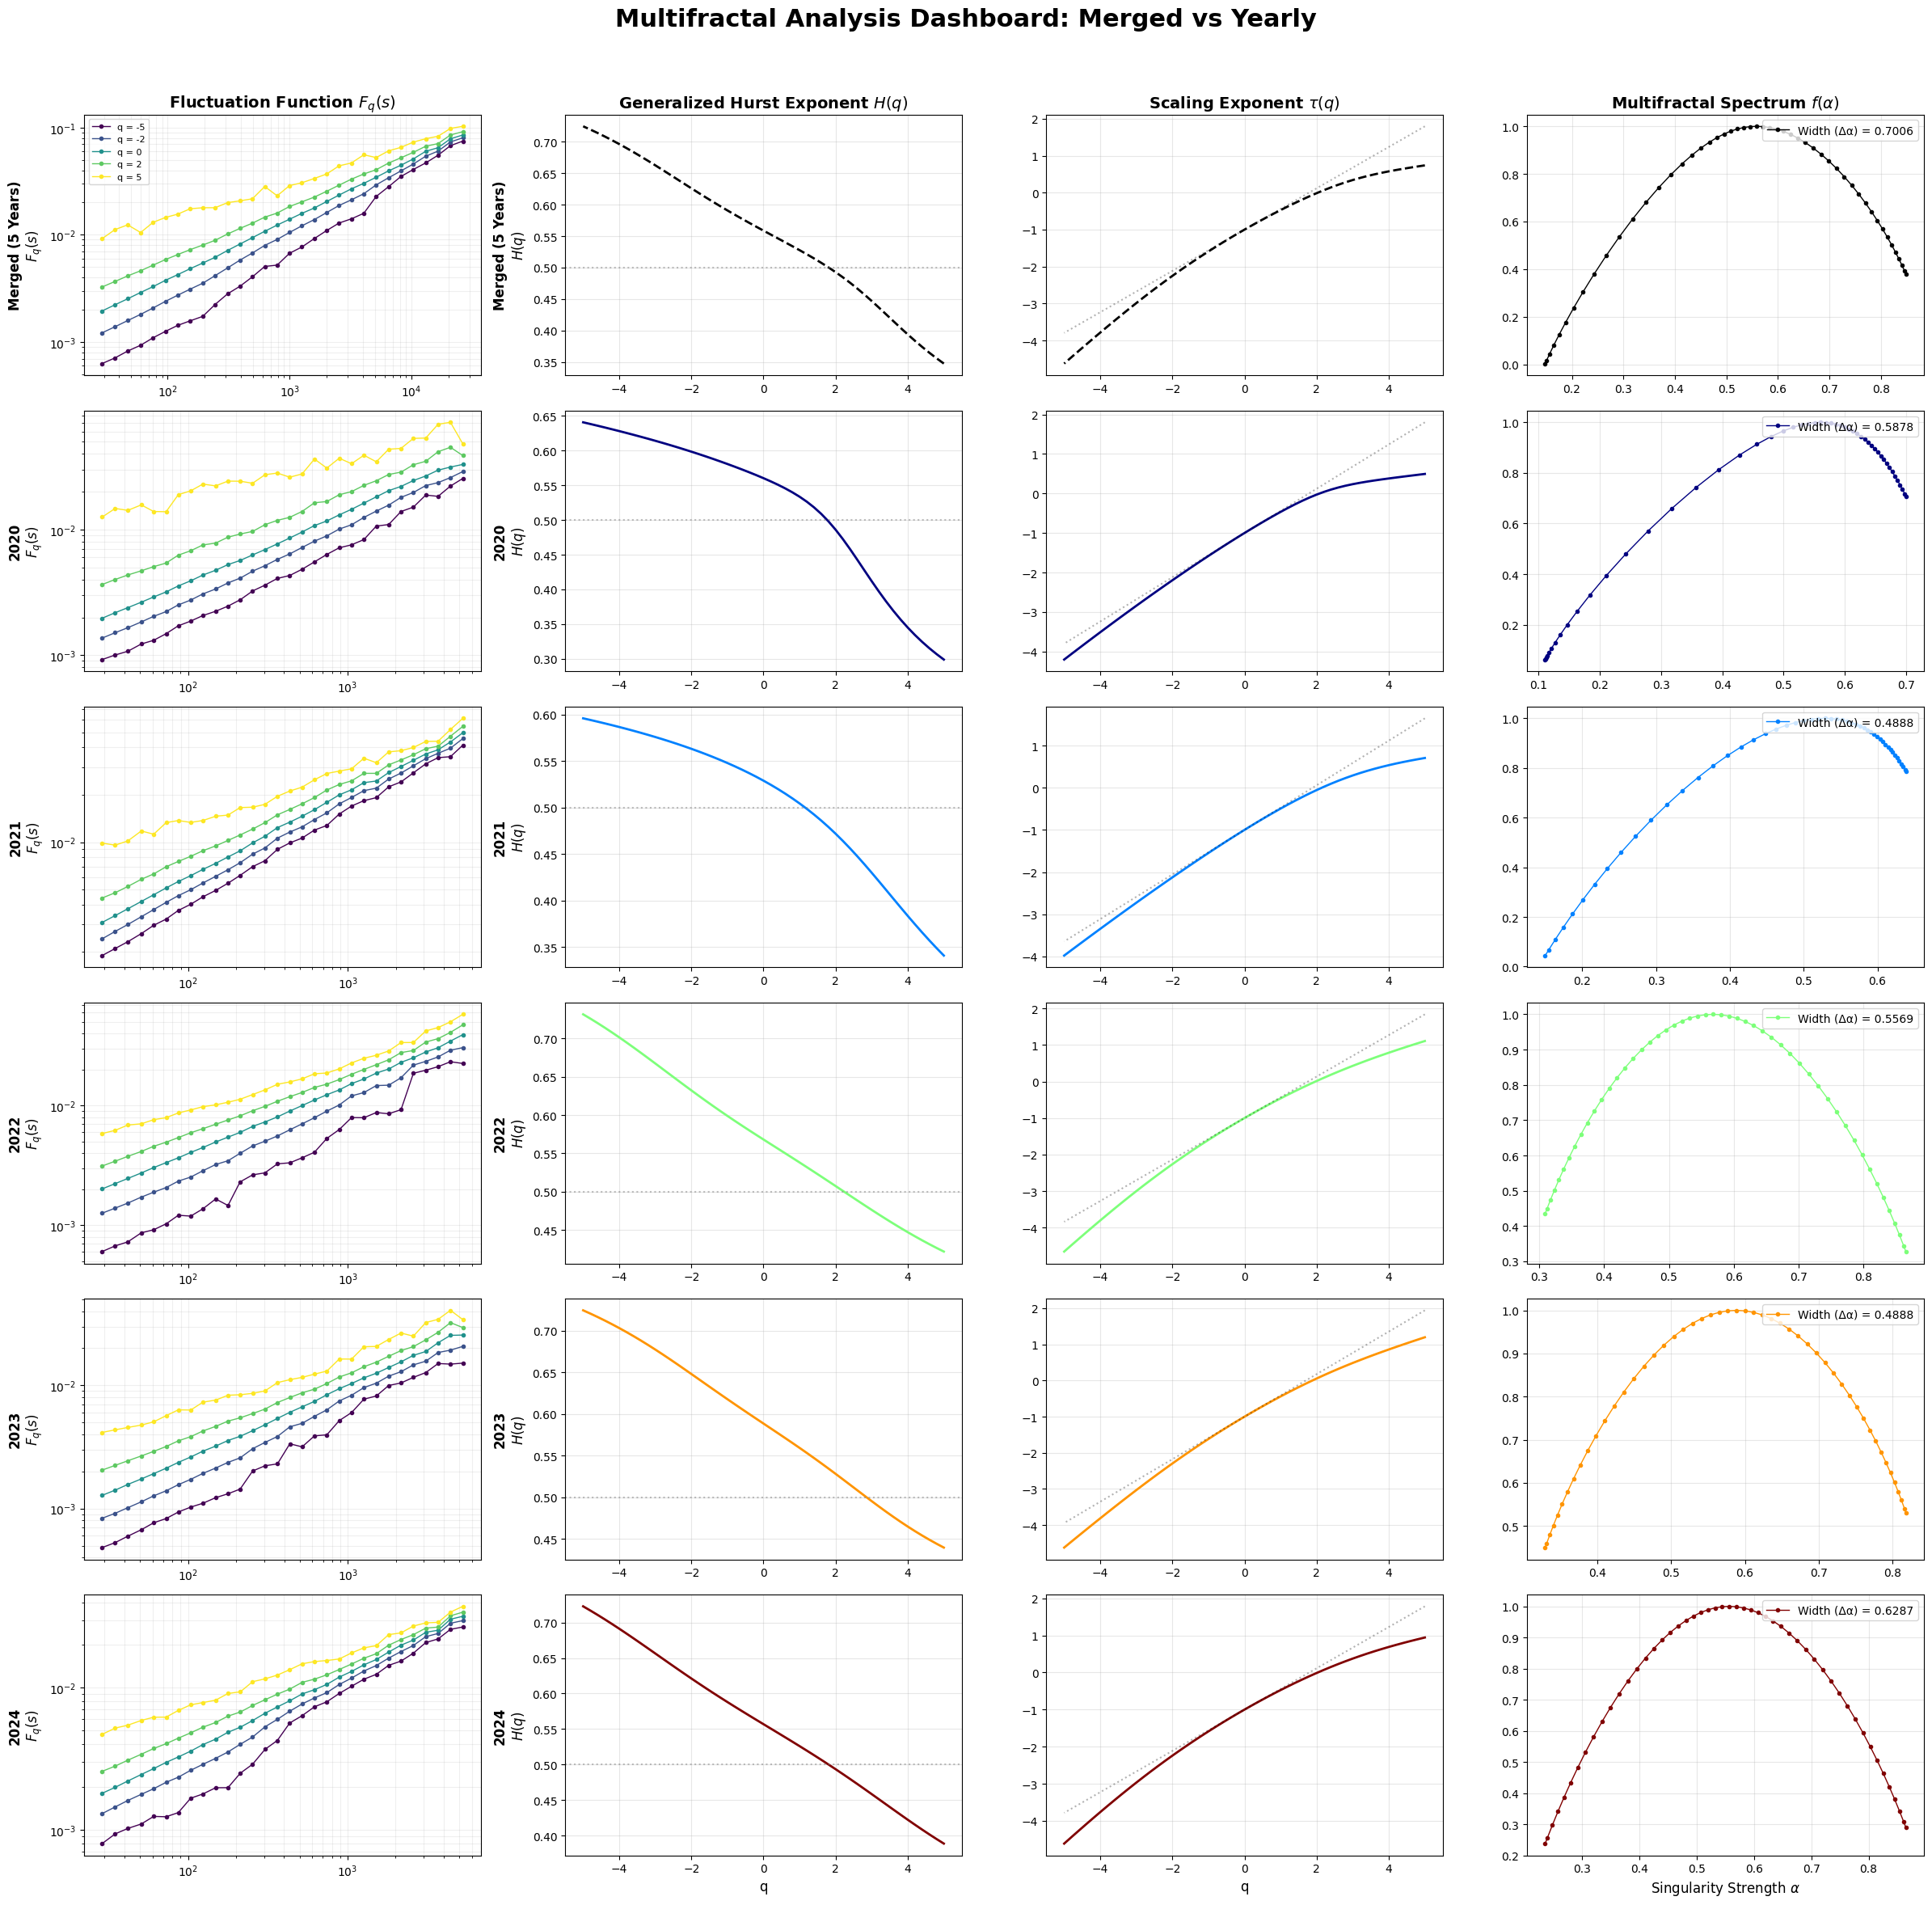

In [7]:
data_dir = "data"
files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

if not files:
    print("No data")
else:
    print(f"Found {len(files)} files")

datasets = {}

for f in files:
    df = pd.read_csv(f, index_col = 'datetime', parse_dates = True)
    if 'return' not in df.columns:
        df['return'] = np.log(df['close']).diff()
    df.dropna(inplace = True)

    year = str(df.index.year[0])
    datasets[year] = df['close']
    print(f"  -> Loaded {year}")

df_all = pd.concat([pd.read_csv(f, index_col = 'datetime', parse_dates = True) for f in files]).sort_index()
if 'return' not in df_all.columns: df_all['return'] = np.log(df_all['close']).diff()
df_all.dropna(inplace = True)
datasets['Merged (5 Years)'] = df_all['close']

keys = sorted([k for k in datasets.keys() if 'Merged' not in k])
keys.insert(0, 'Merged (5 Years)')

q_list = np.linspace(5, -5, 51)
results = {}

print("\n Running MFDFA")
for name in keys:
    res = compute_spectrum(datasets[name], q_list)
    if res: results[name] = res
    print(f"   -> Analyzed {name}")
fig, axes = plt.subplots(len(keys), 4, figsize=(24, 24))
    
    # 전체 제목
plt.subplots_adjust(top=0.95, wspace = 0.3, hspace = 0.4)
fig.suptitle('Multifractal Analysis Dashboard: Merged vs Yearly', fontsize=22, fontweight='bold')
    
    # 색상 맵 (Merged는 검정, 연도는 다채롭게)
cmap = plt.cm.jet(np.linspace(0, 1, len(keys)-1))
q_plots = [-5, -2, 0, 2, 5]
colors_q = plt.cm.viridis(np.linspace(0, 1, len(q_plots)))
    
for i, name in enumerate(keys):
    res = results[name]
        
        # 색상 설정
    if 'Merged' in name:
        color = 'black'
        style = '--'
    else:
        color = cmap[i-1]
        style = '-'
        
    ax0 = axes[i, 0]
    for j, qv in enumerate(q_plots):
        idx = np.argmin(np.abs(q_list - qv))
        ax0.loglog(res['scales'], res['F_q_s'][idx, :], 'o-',
                   color = colors_q[j], markersize = 3, linewidth = 1, label = f'q = {qv}')
        
    ax0.grid(True, which = 'both', alpha = 0.2)
    ax0.set_ylabel(f"{name}\n$F_q(s)$", fontsize = 12, fontweight = 'bold')
    
    if i == 0:
        ax0.set_title("Fluctuation Function $F_q(s)$", fontsize = 14, fontweight = 'bold')
        ax0.legend(fontsize = 8, loc = 'upper left')
            
        # --- (Col 1) H(q) ---
    ax1 = axes[i, 1]
    ax1.plot(q_list, res['H_q'], linestyle=style, color=color, linewidth=2)
    ax1.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel(f"{name}\n$H(q)$", fontsize=12, fontweight='bold')
    if i == 0: ax1.set_title("Generalized Hurst Exponent $H(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 2) tau(q) ---
    ax2 = axes[i, 2]
    ax2.plot(q_list, res['tau_q'], linestyle=style, color=color, linewidth=2)
        
        # Monofractal Reference Line (비교용 점선)
    h2 = res['H_q'][len(q_list)//2] # q=0 근처의 H값 사용
    ax2.plot(q_list, q_list * h2 - 1, 'k:', alpha=0.3, label='Linear Fit')
        
    ax2.grid(True, alpha=0.3)
    if i == 0: ax2.set_title("Scaling Exponent $\\tau(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 3) f(alpha) ---
    ax3 = axes[i, 3]
        # 스펙트럼 너비(Width) 표시
    label_txt = f"Width (Δα) = {res['delta_alpha']:.4f}"
    ax3.plot(res['alpha'], res['f_alpha'], 'o-', markersize=3, color=color, linewidth=1, label=label_txt)
        
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right', fontsize=10, frameon=True)
    if i == 0: ax3.set_title("Multifractal Spectrum $f(\\alpha)$", fontsize=14, fontweight='bold')
        
        # X축 라벨은 맨 마지막 행에만 표시
    if i == len(keys) - 1:
        ax1.set_xlabel('q', fontsize=12)
        ax2.set_xlabel('q', fontsize=12)
        ax3.set_xlabel('Singularity Strength $\\alpha$', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
def plot_results_by_year(eval_df):
    # 스타일 설정
    sns.set_style("whitegrid")
    plt.rcParams['axes.unicode_minus'] = False
    
    # 인덱스 확인
    if not isinstance(eval_df.index, pd.DatetimeIndex):
        eval_df.index = pd.to_datetime(eval_df.index)

    # 컬럼 이름 안전장치 (Hybrid_Vol로 계산됐을 경우 Hybrid_Pred로 복사)
    if 'Hybrid_Pred' not in eval_df.columns and 'Hybrid_Vol' in eval_df.columns:
        eval_df['Hybrid_Pred'] = eval_df['Hybrid_Vol']

    years = eval_df.index.year.unique()
    print(f"\n총 {len(years)}개 연도에 대해 그래프 생성을 시작합니다...")

    for year in years:
        year_df = eval_df[eval_df.index.year == year]
        if len(year_df) == 0: continue
            
        print(f"   -> {year}년도 그래프 생성 중... ({len(year_df)} rows)")

        # 캔버스 생성 (4행 1열)
        fig, axes = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
        
        # (1) Actual
        axes[0].plot(year_df.index, year_df['Future_Vol_24h'], color='black', linewidth=1, label='Actual')
        axes[0].set_title(f'[{year}] 1. Actual Volatility', fontsize=14, fontweight='bold')
        axes[0].legend(loc='upper right')
        
        # (2) Base Model
        axes[1].plot(year_df.index, year_df['Base_Vol'], color='blue', linestyle='--', linewidth=1, label='GARCH-MIDAS')
        axes[1].set_title(f'[{year}] 2. Base Model Prediction', fontsize=14, fontweight='bold')
        axes[1].legend(loc='upper right')
        
        # (3) Hybrid Model
        axes[2].plot(year_df.index, year_df['Hybrid_Pred'], color='red', linewidth=1, label='Hybrid LSTM')
        axes[2].set_title(f'[{year}] 3. Hybrid Model Prediction', fontsize=14, fontweight='bold')
        axes[2].legend(loc='upper right')
        
        # (4) Residual Analysis
        target_res = year_df['Future_Vol_24h'] - year_df['Base_Vol']
        pred_res = year_df['Hybrid_Pred'] - year_df['Base_Vol']
        
        axes[3].plot(year_df.index, target_res, color='gray', alpha=0.5, label='Actual Error')
        axes[3].plot(year_df.index, pred_res, color='red', alpha=0.8, linewidth=1, label='Predicted Error')
        axes[3].axhline(0, color='black', linestyle=':', linewidth=1)
        axes[3].set_title(f'[{year}] 4. Residual Analysis', fontsize=14, fontweight='bold')
        axes[3].legend(loc='upper right')
        
        plt.tight_layout()
        
        # 파일 저장
        save_path = f"result_graph_{year}.png"
        plt.savefig(save_path, dpi=100) # 속도를 위해 dpi 100 권장
        plt.close(fig) # 메모리 해제 (필수!)
        
        print(f"저장 완료: {save_path}")

    print("\n모든 연도 그래프 저장이 완료되었습니다!")

In [9]:
# 2021년 데이터 로드
path_10m = "data/BTCUSDT_10m_2021.csv"

df_10m = pd.read_csv(path_10m)

df_10m.columns = [c.lower().strip() for c in df_10m.columns]

date_cols = None
for col in ['timestamp', 'date', 'datetime', 'open_time']:
    if col in df_10m.columns:
        date_col = col
        break
    
if date_col:
    df_10m[date_col] = pd.to_datetime(df_10m[date_col])
    df_10m.set_index(date_col, inplace = True)
else:
    raise KeyError("Can't find date columns")

if 'return' not in df_10m.columns:
    df_10m['return'] = np.log(df_10m['close']).diff() * 100
    
df_10m.dropna(inplace = True)

print(f"데이터 준비 완료. Shape: {df_10m.shape}")
print(f"기간: {df_10m.index.min()} ~ {df_10m.index.max()}")

# MF-DFA 지표 계산
WINDOW_SIZE = 30 * 144

mfdfa_2021 = mfdfa_features(df_10m['close'], DEVICE, window = WINDOW_SIZE, step = 1)

print(f"Complete Calculation of MF-DFA: {mfdfa_2021.shape}")
print("    -> Included index:", mfdfa_2021.columns.tolist())

데이터 준비 완료. Shape: (52559, 6)
기간: 2021-01-01 00:10:00+00:00 ~ 2021-12-31 23:50:00+00:00
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 48238/48238 [01:20<00:00, 599.27it/s]

Complete Calculation of MF-DFA: (48192, 3)
    -> Included index: ['delta_H', 'delta_alpha', 'alpha_0']


In [10]:
# 로그 분석을 통해 추출한 최종 결과값
data = [
    {
        "Model": "1. Benchmark", 
        "Best_K": 60, 
        "Best_Dist": "Normal", 
        "Best_Lags": 288, 
        "Best_Hidden": 256, 
        "Best_Layers": 2, 
        "Final_RMSE": 0.8818
    },
    {
        "Model": "2. Hybrid (Delta H)", 
        "Best_K": 60, 
        "Best_Dist": "Normal", 
        "Best_Lags": 288, 
        "Best_Hidden": 256, 
        "Best_Layers": 2, 
        "Final_RMSE": 0.8291
    },
    {
        "Model": "3. Hybrid (Delta Alpha)", 
        "Best_K": 60, 
        "Best_Dist": "Normal", 
        "Best_Lags": 288, 
        "Best_Hidden": 256, 
        "Best_Layers": 2, 
        "Final_RMSE": 0.8447
    }
]

# DataFrame 생성 및 RMSE 기준 정렬 (낮은 순)
report_df = pd.DataFrame(data).sort_values(by="Final_RMSE").reset_index(drop=True)

print("="*80)
print("🏅 FINAL TUNING LEADERBOARD (Restored)")
print("="*80)
print(report_df.to_string(index=False))

# 1등 모델 자동 선택
best_model = report_df.iloc[0]
print(f"\n🔥 Winner: {best_model['Model']} (RMSE: {best_model['Final_RMSE']})")

🏅 FINAL TUNING LEADERBOARD (Restored)
                  Model  Best_K Best_Dist  Best_Lags  Best_Hidden  Best_Layers  Final_RMSE
    2. Hybrid (Delta H)      60    Normal        288          256            2      0.8291
3. Hybrid (Delta Alpha)      60    Normal        288          256            2      0.8447
           1. Benchmark      60    Normal        288          256            2      0.8818

🔥 Winner: 2. Hybrid (Delta H) (RMSE: 0.8291)


In [34]:
# ---------------------------------------------------------
# [Case 1] 튜닝 전 (Default Parameters)
# ---------------------------------------------------------
print("1️⃣ Before Tuning (Default Settings)")

# GARCH (기본값 K=30)
df_base_default = monthly_garch_midas_tuned(
    df_10m, mfdfa_2021, 
    exog_col='delta_H', 
    midas_k=30,             # <--- 기본값
    dist_type='Normal'
)

# 데이터 준비 (기본값 Lags=144)
flat_default, feats_default = prepare_flatten_features(
    df_base_default, mfdfa_2021, 
    lags=144                # <--- 기본값
)

# LSTM (기본값 Hidden=128, Layers=2)
res_default, _ = run_rolling_flatten_lstm_tuned(
    flat_default, feats_default, 
    hidden_dim=128,         # <--- 기본값
    num_layers=2, 
    train_window=4320, test_days=30
)

# RMSE 계산
rmse_default = np.sqrt(mean_squared_error(res_default.dropna()['Future_Vol_24h'], 
                                          res_default.dropna()['Base_Vol'] + res_default.dropna()['Predicted_Residual']))
print(f"👉 Default RMSE: {rmse_default:.4f}")


# ---------------------------------------------------------
# [Case 2] 튜닝 후 (Optimized Parameters)
# ---------------------------------------------------------
print("\n2️⃣ After Tuning (Optimized Settings)")

# GARCH (최적값 K=60)
df_base_tuned = monthly_garch_midas_tuned(
    df_10m, mfdfa_2021, 
    exog_col='delta_H', 
    midas_k=60,             # <--- 튜닝된 값
    dist_type='Normal'
)

# 데이터 준비 (최적값 Lags=288)
flat_tuned, feats_tuned = prepare_flatten_features(
    df_base_tuned, mfdfa_2021, 
    lags=288                # <--- 튜닝된 값
)

# LSTM (최적값 Hidden=256)
res_tuned, _ = run_rolling_flatten_lstm_tuned(
    flat_tuned, feats_tuned, 
    hidden_dim=256,         # <--- 튜닝된 값
    num_layers=2, 
    train_window=4320, test_days=30
)

# RMSE 계산
rmse_tuned = np.sqrt(mean_squared_error(res_tuned.dropna()['Future_Vol_24h'], 
                                        res_tuned.dropna()['Base_Vol'] + res_tuned.dropna()['Predicted_Residual']))
print(f"👉 Tuned RMSE: {rmse_tuned:.4f}")

# ---------------------------------------------------------
# 최종 비교
# ---------------------------------------------------------
improvement = (rmse_default - rmse_tuned) / rmse_default * 100
print(f"\n🎉 Performance Improvement: {improvement:.2f}%")

1️⃣ Before Tuning (Default Settings)
[INFO] Base Model Running (Exog: delta_H)


Monthly Re-fitting:  40%|████      | 4/10 [00:00<00:00, 30.38it/s]

   [Skip] Not enough train data: 0


Monthly Re-fitting: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s]


Complete. 39608 rows generated.
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1398.71it/s]


Final Data shape: (39177, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39177, 시뮬레이션 시작 인덱스: 34857
 -> 예측 구간: 약 30일 (4320 steps)
👉 Default RMSE: 1.0097

2️⃣ After Tuning (Optimized Settings)
[INFO] Base Model Running (Exog: delta_H)


Monthly Re-fitting:  50%|█████     | 5/10 [00:00<00:00, 37.11it/s]

   [Skip] Not enough train data: 0
   [Skip] Not enough train data: 1


Monthly Re-fitting: 100%|██████████| 10/10 [00:00<00:00, 18.31it/s]


Complete. 35287 rows generated.
Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1566.37it/s]


Final Data shape: (34712, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 34712, 시뮬레이션 시작 인덱스: 30392
 -> 예측 구간: 약 30일 (4320 steps)
👉 Tuned RMSE: 0.6937

🎉 Performance Improvement: 31.30%


Compare 3 GARCH-MIDAS Model

Running Scenario: 1. Benchmark (No Exog)
------------------------------------------------------------
[INFO] Base Model Running (Exog: None)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:02,  3.48it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070357
   - Beta  (GARCH) : 0.874935
   - m     (Const) : 0.336203  -> (m^2 used: 0.11303257)
   - Theta (RV_Wgt): 0.051714  -> (theta^2 used: 0.00267433)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376082
   - Min : 0.261503
   - Max : 0.848029
   - First 5 values: [0.47415546 0.69017008 0.65569359 0.64247627 0.62816439]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:00<00:03,  2.41it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.062103
   - Beta  (GARCH) : 0.892231
   - m     (Const) : 0.205532  -> (m^2 used: 0.04224327)
   - Theta (RV_Wgt): 0.064726  -> (theta^2 used: 0.00418941)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.306613
   - Min : 0.190824
   - Max : 1.606568
   - First 5 values: [0.30354634 0.299813   0.29090255 0.28378687 0.2831238 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:03,  1.93it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861684
   - m     (Const) : 0.123979  -> (m^2 used: 0.01537083)
   - Theta (RV_Wgt): 0.074426  -> (theta^2 used: 0.00553919)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543995
   - Min : 0.204963
   - Max : 6.421263
   - First 5 values: [0.30991579 0.31544883 0.30378401 0.2970965  0.28743502]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:02<00:03,  1.53it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096769
   - Beta  (GARCH) : 0.860045
   - m     (Const) : 0.185564  -> (m^2 used: 0.03443395)
   - Theta (RV_Wgt): 0.072410  -> (theta^2 used: 0.00524315)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.408303
   - Min : 0.236699
   - Max : 1.186660
   - First 5 values: [0.52610019 0.50789152 0.52992298 0.5081615  0.49579848]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:03<00:04,  1.22it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.091946
   - Beta  (GARCH) : 0.868026
   - m     (Const) : 0.202385  -> (m^2 used: 0.04095977)
   - Theta (RV_Wgt): 0.070854  -> (theta^2 used: 0.00502036)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.287259
   - Min : 0.171566
   - Max : 1.443002
   - First 5 values: [0.3766217  0.36068586 0.34677221 0.33366462 0.32210066]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:04<00:03,  1.04it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096552
   - Beta  (GARCH) : 0.856998
   - m     (Const) : 0.206718  -> (m^2 used: 0.04273230)
   - Theta (RV_Wgt): 0.068571  -> (theta^2 used: 0.00470200)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281450
   - Min : 0.178202
   - Max : 0.735336
   - First 5 values: [0.30824274 0.30020671 0.29190028 0.28064754 0.28564983]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:06<00:03,  1.14s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102260
   - Beta  (GARCH) : 0.839423
   - m     (Const) : 0.191167  -> (m^2 used: 0.03654491)
   - Theta (RV_Wgt): 0.068644  -> (theta^2 used: 0.00471201)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.315242
   - Min : 0.166204
   - Max : 4.021009
   - First 5 values: [0.23984376 0.25339244 0.2411167  0.24786732 0.24966366]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:07<00:02,  1.30s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115619
   - Beta  (GARCH) : 0.824650
   - m     (Const) : 0.200990  -> (m^2 used: 0.04039709)
   - Theta (RV_Wgt): 0.067519  -> (theta^2 used: 0.00455888)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.276555
   - Min : 0.185705
   - Max : 2.138450
   - First 5 values: [0.24055312 0.23378143 0.23521443 0.22974374 0.2455124 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:09<00:01,  1.43s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128878
   - Beta  (GARCH) : 0.784344
   - m     (Const) : 0.216142  -> (m^2 used: 0.04671723)
   - Theta (RV_Wgt): 0.063984  -> (theta^2 used: 0.00409389)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.270550
   - Min : 0.183098
   - Max : 1.174743
   - First 5 values: [0.2431086  0.28121842 0.28172224 0.26733717 0.26086417]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136249
   - Beta  (GARCH) : 0.772030
   - m     (Const) : 0.205650  -> (m^2 used: 0.04229174)
   - Theta (RV_Wgt): 0.065344  -> (theta^2 used: 0.00426990)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296673
   - Min : 0.183403
   - Max : 2.781356
   - First 5 values: [0.29088784 0.32569665 0.30845376 0.30897073 0.30594731]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1350.86it/s]


Final Data shape: (43632, 729)
Rolling LSTM Start (Train Window: 30 days, Test Period: 273)

[INFO] Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


Rolling Update: 100%|██████████| 39312/39312 [09:27<00:00, 69.25it/s]


RMSE Base: 4.2664 -> Hybrid: 0.9516 (77.70% Improved)


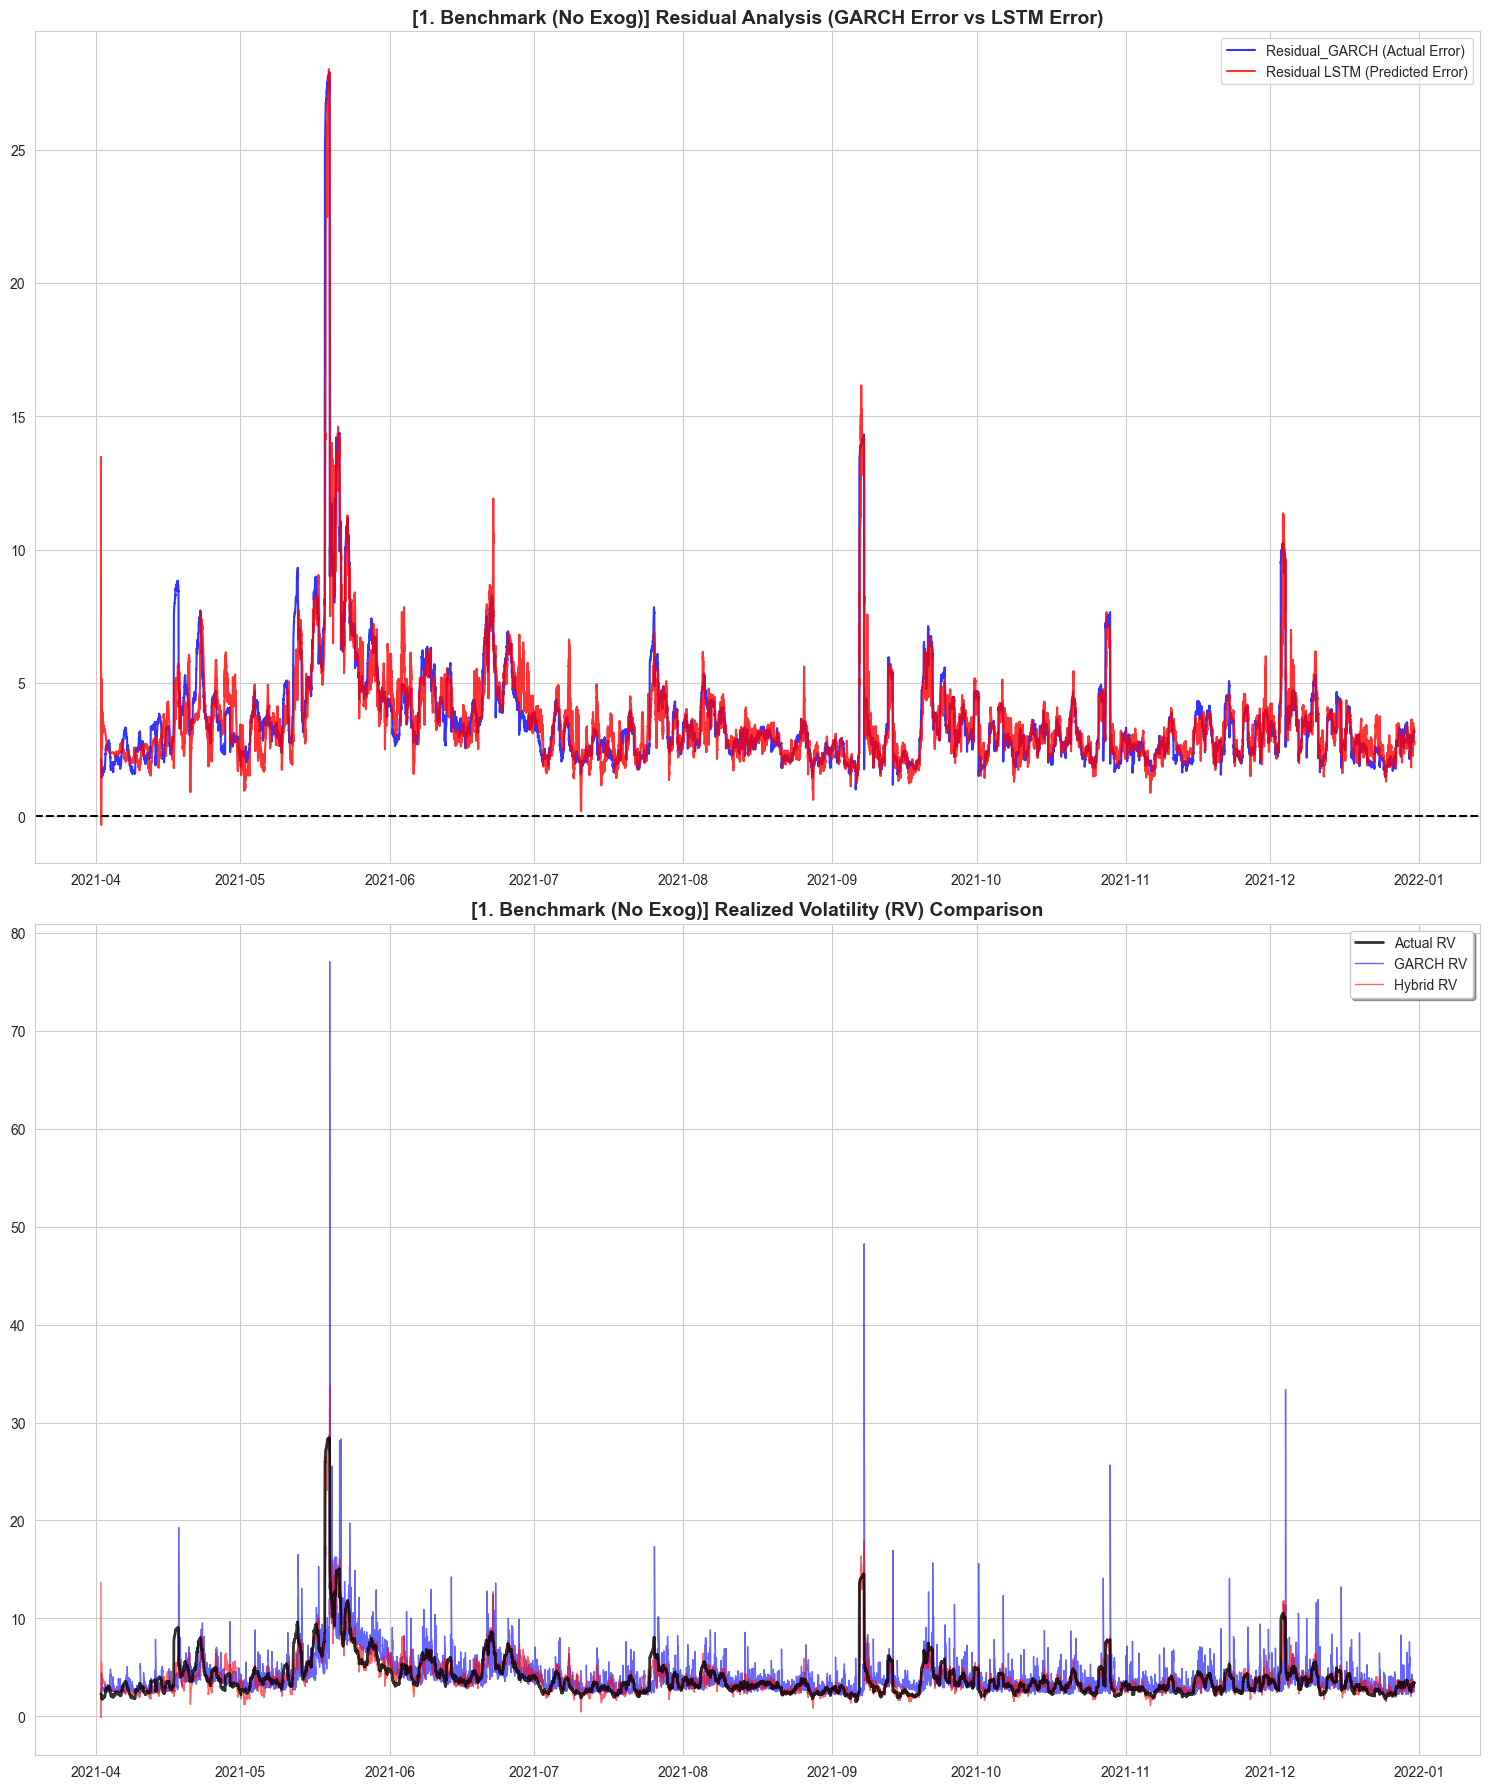


Running Scenario: 2. Hybrid (with Delta H)
------------------------------------------------------------
[INFO] Base Model Running (Exog: delta_H)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:03,  2.28it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070091
   - Beta  (GARCH) : 0.871729
   - m     (Const) : 0.198577  -> (m^2 used: 0.03943296)
   - Theta (RV_Wgt): 0.056993  -> (theta^2 used: 0.00324821)
   - W_Exog(exog_x): 0.523074  -> (w^2 used: 0.27360602)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.377737
   - Min : 0.251858
   - Max : 0.846031
   - First 5 values: [0.48179433 0.69485575 0.66023916 0.64681892 0.63239454]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:05,  1.49it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061719
   - Beta  (GARCH) : 0.891641
   - m     (Const) : 0.108098  -> (m^2 used: 0.01168509)
   - Theta (RV_Wgt): 0.065459  -> (theta^2 used: 0.00428488)
   - W_Exog(exog_x): 0.362040  -> (w^2 used: 0.13107311)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.302600
   - Min : 0.180107
   - Max : 1.599681
   - First 5 values: [0.29957186 0.29581788 0.28684786 0.27968688 0.27903383]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:04,  1.57it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087343
   - Beta  (GARCH) : 0.861706
   - m     (Const) : 0.117793  -> (m^2 used: 0.01387510)
   - Theta (RV_Wgt): 0.074237  -> (theta^2 used: 0.00551107)
   - W_Exog(exog_x): 0.102133  -> (w^2 used: 0.01043110)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.544174
   - Min : 0.205845
   - Max : 6.419716
   - First 5 values: [0.31044161 0.31595478 0.30430841 0.29762971 0.28798523]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.01s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096845
   - Beta  (GARCH) : 0.858459
   - m     (Const) : 0.060421  -> (m^2 used: 0.00365069)
   - Theta (RV_Wgt): 0.069765  -> (theta^2 used: 0.00486716)
   - W_Exog(exog_x): 0.423497  -> (w^2 used: 0.17934956)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.417339
   - Min : 0.259765
   - Max : 1.191374
   - First 5 values: [0.53372062 0.51553709 0.53711044 0.51545559 0.50313979]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:07,  1.45s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092217
   - Beta  (GARCH) : 0.866041
   - m     (Const) : 0.103102  -> (m^2 used: 0.01063001)
   - Theta (RV_Wgt): 0.067214  -> (theta^2 used: 0.00451769)
   - W_Exog(exog_x): 0.416101  -> (w^2 used: 0.17313994)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285561
   - Min : 0.172185
   - Max : 1.444273
   - First 5 values: [0.37353792 0.35734488 0.34322337 0.32993746 0.31823309]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:08<00:07,  1.80s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097124
   - Beta  (GARCH) : 0.854127
   - m     (Const) : 0.101030  -> (m^2 used: 0.01020712)
   - Theta (RV_Wgt): 0.064773  -> (theta^2 used: 0.00419559)
   - W_Exog(exog_x): 0.431719  -> (w^2 used: 0.18638135)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.280920
   - Min : 0.181070
   - Max : 0.734934
   - First 5 values: [0.30638544 0.2981975  0.28976073 0.27835851 0.28346826]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:06,  2.06s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102867
   - Beta  (GARCH) : 0.836327
   - m     (Const) : 0.088582  -> (m^2 used: 0.00784679)
   - Theta (RV_Wgt): 0.065308  -> (theta^2 used: 0.00426513)
   - W_Exog(exog_x): 0.407222  -> (w^2 used: 0.16583001)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.326508
   - Min : 0.167515
   - Max : 4.028238
   - First 5 values: [0.24043493 0.25403885 0.24168602 0.24846983 0.25025957]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:12<00:03,  1.91s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115628
   - Beta  (GARCH) : 0.824545
   - m     (Const) : 0.195121  -> (m^2 used: 0.03807217)
   - Theta (RV_Wgt): 0.067223  -> (theta^2 used: 0.00451888)
   - W_Exog(exog_x): 0.113910  -> (w^2 used: 0.01297558)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277386
   - Min : 0.186576
   - Max : 2.138481
   - First 5 values: [0.2422734  0.23554952 0.23697176 0.23154184 0.24719739]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.27s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128903
   - Beta  (GARCH) : 0.784297
   - m     (Const) : 0.200278  -> (m^2 used: 0.04011116)
   - Theta (RV_Wgt): 0.063423  -> (theta^2 used: 0.00402242)
   - W_Exog(exog_x): 0.179014  -> (w^2 used: 0.03204607)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.271919
   - Min : 0.185358
   - Max : 1.175185
   - First 5 values: [0.24376167 0.28177332 0.28226136 0.26788998 0.26142017]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136233
   - Beta  (GARCH) : 0.772050
   - m     (Const) : 0.203528  -> (m^2 used: 0.04142379)
   - Theta (RV_Wgt): 0.065279  -> (theta^2 used: 0.00426132)
   - W_Exog(exog_x): 0.063402  -> (w^2 used: 0.00401984)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296755
   - Min : 0.183598
   - Max : 2.781206
   - First 5 values: [0.29089162 0.32570109 0.30846527 0.30898545 0.30596511]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1361.33it/s]


Final Data shape: (43632, 729)
Rolling LSTM Start (Train Window: 30 days, Test Period: 273)

[INFO] Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


Rolling Update: 100%|██████████| 39312/39312 [09:28<00:00, 69.17it/s]


RMSE Base: 4.2648 -> Hybrid: 0.9429 (77.89% Improved)


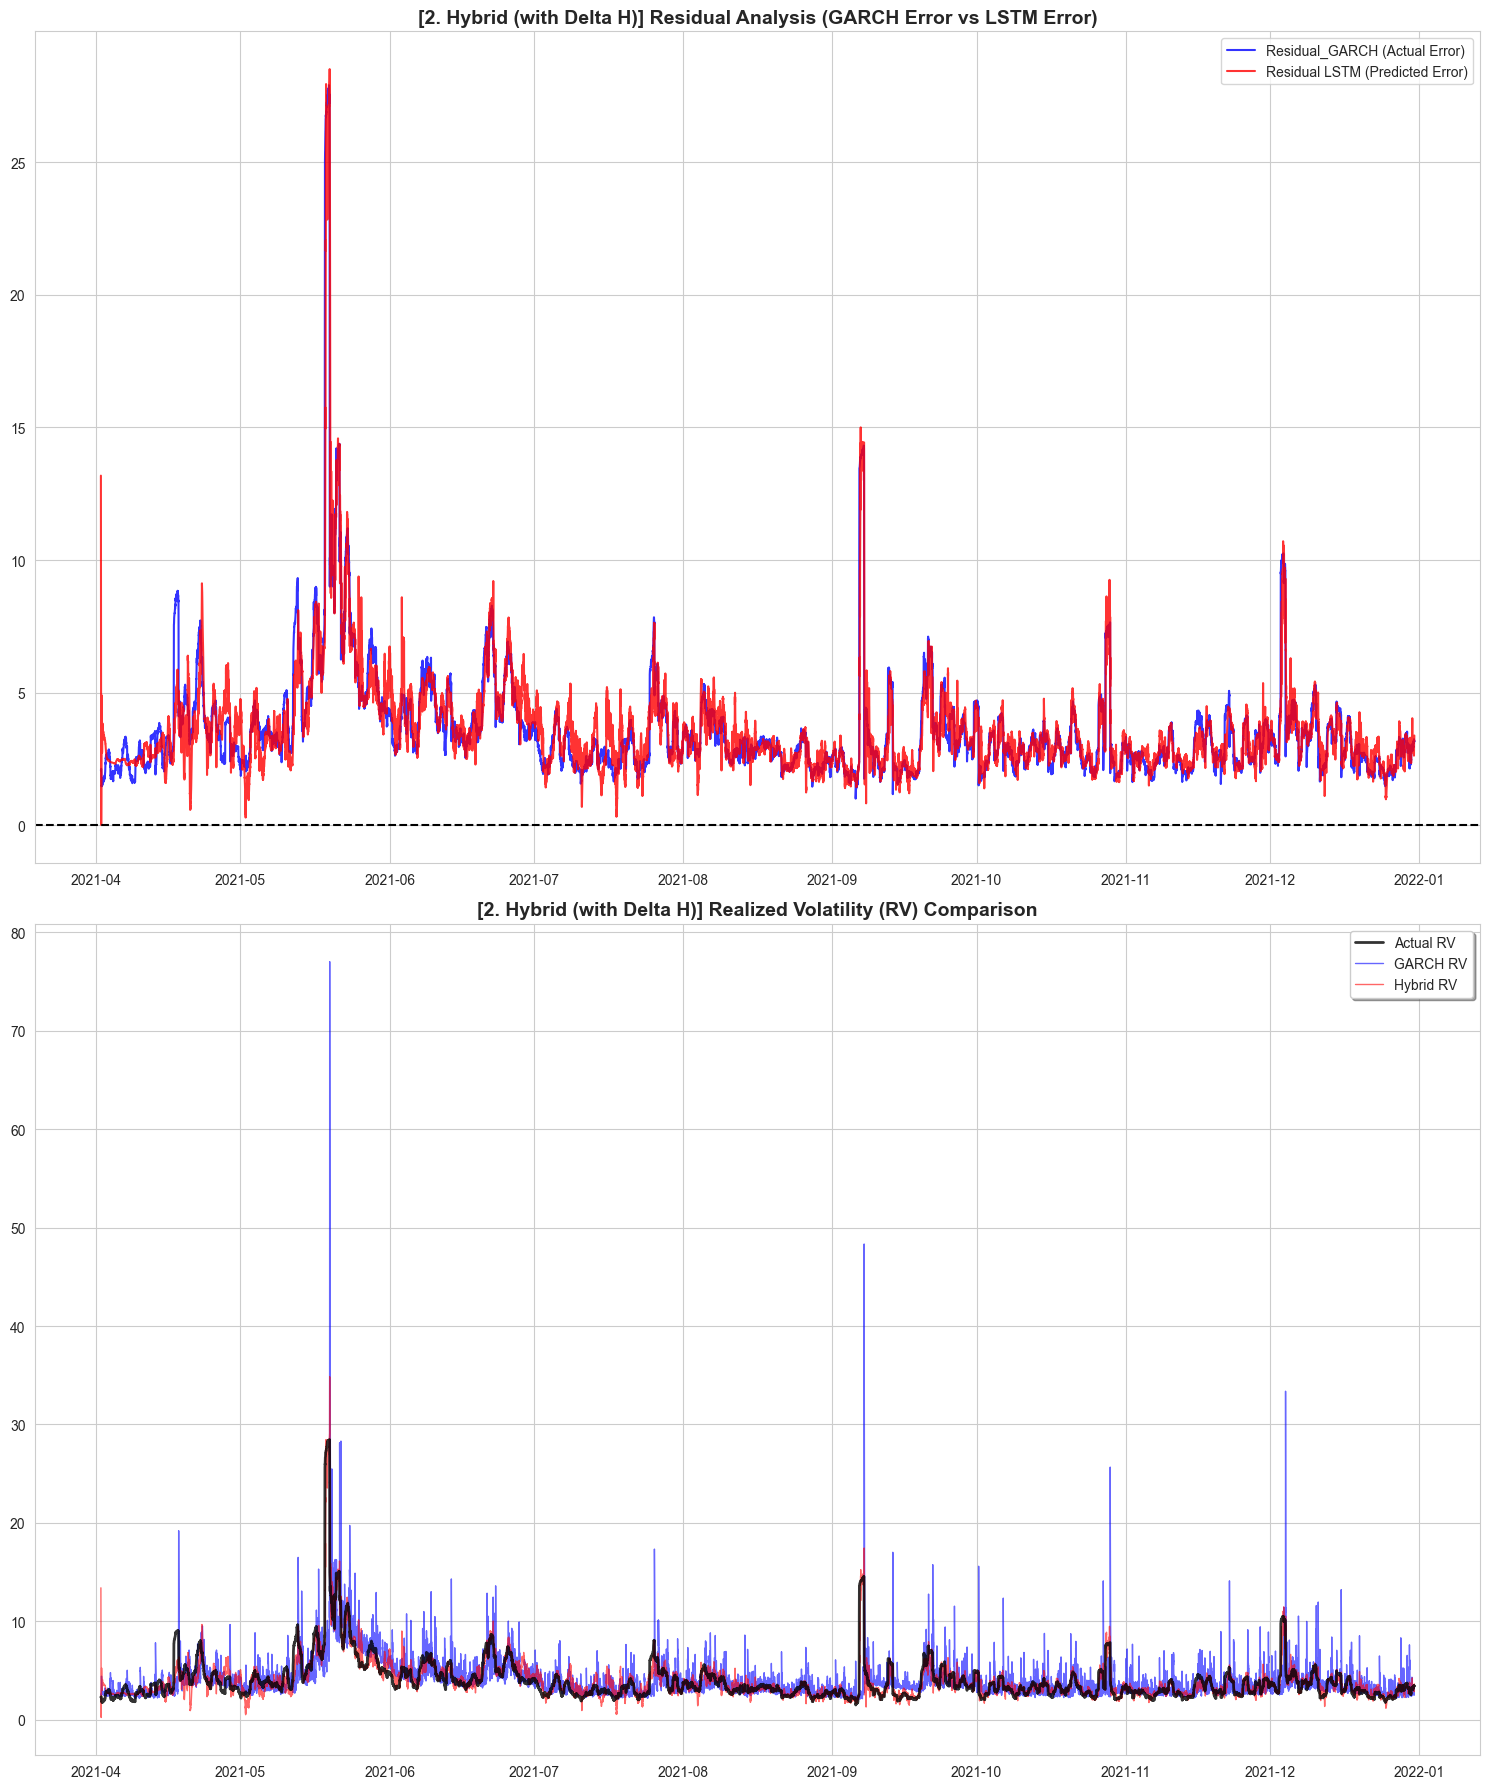


Running Scenario: 3. Hybrid (with Delta Alpha)
------------------------------------------------------------
[INFO] Base Model Running (Exog: delta_alpha)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:03,  2.47it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070106
   - Beta  (GARCH) : 0.872798
   - m     (Const) : 0.256855  -> (m^2 used: 0.06597432)
   - Theta (RV_Wgt): 0.055086  -> (theta^2 used: 0.00303450)
   - W_Exog(exog_x): 0.304598  -> (w^2 used: 0.09277996)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376625
   - Min : 0.254813
   - Max : 0.846042
   - First 5 values: [0.47877908 0.69277914 0.65822367 0.64487822 0.63049825]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:04,  1.69it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061782
   - Beta  (GARCH) : 0.891771
   - m     (Const) : 0.140976  -> (m^2 used: 0.01987426)
   - Theta (RV_Wgt): 0.065164  -> (theta^2 used: 0.00424640)
   - W_Exog(exog_x): 0.228748  -> (w^2 used: 0.05232571)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.303501
   - Min : 0.182793
   - Max : 1.600903
   - First 5 values: [0.3004635  0.29671594 0.28776322 0.28061569 0.27996095]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:02<00:05,  1.27it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861689
   - m     (Const) : 0.123958  -> (m^2 used: 0.01536569)
   - Theta (RV_Wgt): 0.074428  -> (theta^2 used: 0.00553952)
   - W_Exog(exog_x): 0.000382  -> (w^2 used: 0.00000015)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543999
   - Min : 0.204958
   - Max : 6.421263
   - First 5 values: [0.30991454 0.31544766 0.30378296 0.29709548 0.287434  ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.01s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096893
   - Beta  (GARCH) : 0.858214
   - m     (Const) : 0.053827  -> (m^2 used: 0.00289736)
   - Theta (RV_Wgt): 0.069581  -> (theta^2 used: 0.00484153)
   - W_Exog(exog_x): 0.317074  -> (w^2 used: 0.10053579)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.416163
   - Min : 0.258064
   - Max : 1.191219
   - First 5 values: [0.53234143 0.51408126 0.53571251 0.51397258 0.50160634]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:06,  1.32s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092249
   - Beta  (GARCH) : 0.865775
   - m     (Const) : 0.087821  -> (m^2 used: 0.00771255)
   - Theta (RV_Wgt): 0.066967  -> (theta^2 used: 0.00448457)
   - W_Exog(exog_x): 0.321880  -> (w^2 used: 0.10360661)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285382
   - Min : 0.172174
   - Max : 1.444256
   - First 5 values: [0.37323709 0.3570137  0.34286826 0.32956255 0.31784327]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:07<00:06,  1.64s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097177
   - Beta  (GARCH) : 0.853864
   - m     (Const) : 0.089420  -> (m^2 used: 0.00799591)
   - Theta (RV_Wgt): 0.064573  -> (theta^2 used: 0.00416969)
   - W_Exog(exog_x): 0.330372  -> (w^2 used: 0.10914555)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281654
   - Min : 0.182009
   - Max : 0.735256
   - First 5 values: [0.30689694 0.29868622 0.29023287 0.27882272 0.28391236]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:05,  1.98s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102813
   - Beta  (GARCH) : 0.836312
   - m     (Const) : 0.075260  -> (m^2 used: 0.00566407)
   - Theta (RV_Wgt): 0.065191  -> (theta^2 used: 0.00424990)
   - W_Exog(exog_x): 0.311166  -> (w^2 used: 0.09682454)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.325669
   - Min : 0.167784
   - Max : 4.027171
   - First 5 values: [0.24054598 0.25414151 0.24180437 0.24858469 0.25037527]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:13<00:04,  2.21s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115626
   - Beta  (GARCH) : 0.824493
   - m     (Const) : 0.193525  -> (m^2 used: 0.03745199)
   - Theta (RV_Wgt): 0.067158  -> (theta^2 used: 0.00451013)
   - W_Exog(exog_x): 0.094579  -> (w^2 used: 0.00894513)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277453
   - Min : 0.186656
   - Max : 2.138425
   - First 5 values: [0.24239673 0.23567779 0.23710063 0.23167495 0.24732286]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.36s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128875
   - Beta  (GARCH) : 0.784329
   - m     (Const) : 0.192757  -> (m^2 used: 0.03715529)
   - Theta (RV_Wgt): 0.063186  -> (theta^2 used: 0.00399242)
   - W_Exog(exog_x): 0.160381  -> (w^2 used: 0.02572197)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.272954
   - Min : 0.187048
   - Max : 1.175324
   - First 5 values: [0.2443579  0.28227177 0.28275228 0.26840495 0.26194445]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136228
   - Beta  (GARCH) : 0.772053
   - m     (Const) : 0.203473  -> (m^2 used: 0.04140123)
   - Theta (RV_Wgt): 0.065286  -> (theta^2 used: 0.00426221)
   - W_Exog(exog_x): 0.047281  -> (w^2 used: 0.00223545)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296772
   - Min : 0.183630
   - Max : 2.781154
   - First 5 values: [0.29089949 0.32570717 0.30847283 0.30899325 0.30597332]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 706.06it/s]


Final Data shape: (43632, 729)
Rolling LSTM Start (Train Window: 30 days, Test Period: 273)

[INFO] Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


Rolling Update: 100%|██████████| 39312/39312 [09:37<00:00, 68.03it/s]


RMSE Base: 4.2648 -> Hybrid: 0.9681 (77.30% Improved)


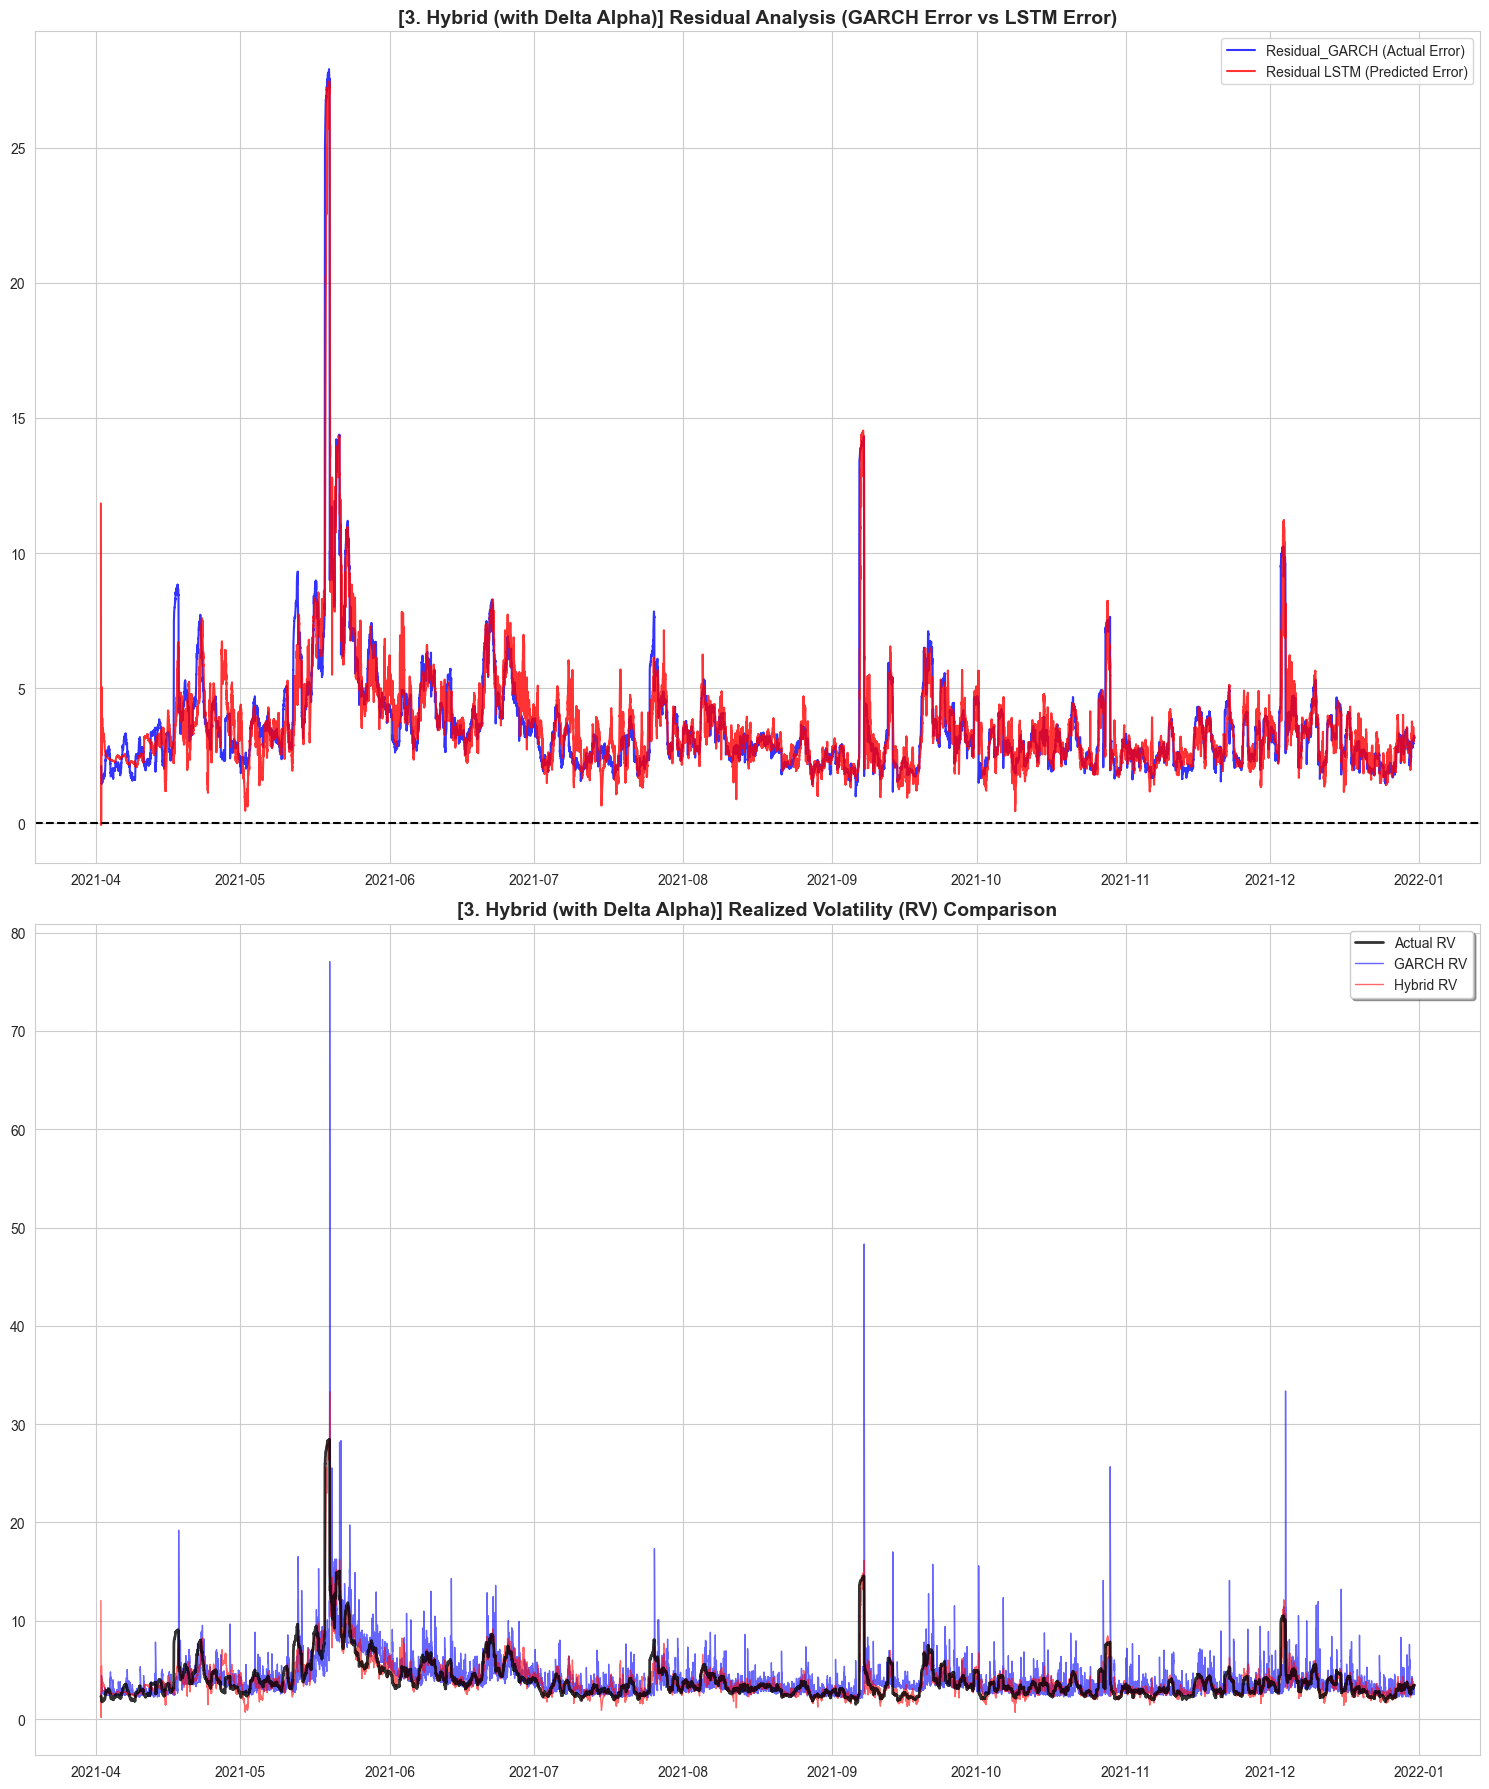


Final Leaderboard
                          Model  RMSE_Base  RMSE_Hybrid  Improvement (%)
0        1. Benchmark (No Exog)   4.266418     0.951555        77.696618
1      2. Hybrid (with Delta H)   4.264763     0.942868        77.891675
2  3. Hybrid (with Delta Alpha)   4.264791     0.968118        77.299745


In [12]:
def plot_model_result(eval_df, model_name):
    sns.set_style(style = "whitegrid")

    fig, axes = plt.subplots(2, 1, figsize = (15, 18))

    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
        
    # daily_df = eval_df[['Residual', pred_col]].resample('1D').mean()
    
    axes[0].plot(eval_df.index, eval_df['Residual'],
                 label = 'Residual_GARCH (Actual Error)', color = 'blue', alpha = 0.8)
    axes[0].plot(eval_df.index, eval_df[pred_col],
                 label = 'Residual LSTM (Predicted Error)', color = 'red', alpha = 0.8)
    axes[0].set_title(F"[{model_name}] Residual Analysis (GARCH Error vs LSTM Error)", fontsize = 14, fontweight = 'bold')
    axes[0].axhline(0, color = 'black', linestyle = '--')
    axes[0].legend(loc = 'upper right')
    
    actual_vol = eval_df['Future_Vol_24h']
    garch_vol = eval_df['Base_Vol'] * 12
    
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    axes[1].plot(eval_df.index, actual_vol, label = 'Actual RV', color = 'black', alpha = 0.8, linewidth = 2, zorder = 2)
    axes[1].plot(eval_df.index, garch_vol, label = 'GARCH RV', color = 'blue', alpha = 0.6, linewidth = 1, zorder = 1)
    axes[1].plot(eval_df.index, hybrid_vol, label = 'Hybrid RV', color = 'red', alpha = 0.6, linewidth = 1, zorder = 1)
    
    axes[1].set_title(f"[{model_name}] Realized Volatility (RV) Comparison", fontsize = 14, fontweight = 'bold')
    axes[1].legend(loc = 'upper right', frameon = True, shadow = True)
    
    plt.tight_layout()
    plt.show()

scenarios = {
    "1. Benchmark (No Exog)": None,
    "2. Hybrid (with Delta H)": "delta_H",
    "3. Hybrid (with Delta Alpha)": "delta_alpha"
}

results_summary = []

print("="*80)
print("Compare 3 GARCH-MIDAS Model")
print("="*80)

for model_name, exog_col in scenarios.items():
    print(f"\nRunning Scenario: {model_name}")
    print('-'*60)
    
    try:
        df_base = monthly_garch_midas(df_10m ,mfdfa_2021, exog_col = exog_col)
    except Exception as e:
        print(f"Error: {e}")
        continue
    
    flat_data, features = prepare_flatten_features(df_base, mfdfa_2021, lags = 144)
    
    TRAIN_WINDOW = 4320
    
    TEST_DAYS = (len(flat_data) - TRAIN_WINDOW) // 144
    
    print(f"Rolling LSTM Start (Train Window: 30 days, Test Period: {TEST_DAYS})")
    
    final_result, loss_history = run_rolling_flatten_lstm(
        flat_data, features, train_window = TRAIN_WINDOW, test_days =TEST_DAYS
    )
    
    eval_df = final_result.dropna()
    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
    else:
        raise KeyError(f"예측 컬럼을 찾을 수 없습니다! 현재 컬럼 목록: {eval_df.columns.tolist()}")
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
    rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], hybrid_vol))
    improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
    
    print(f"RMSE Base: {rmse_base:.4f} -> Hybrid: {rmse_hybrid:.4f} ({improvement:.2f}% Improved)")
    
    results_summary.append({
        "Model": model_name,
        "RMSE_Base": rmse_base,
        "RMSE_Hybrid": rmse_hybrid,
        "Improvement (%)": improvement
    })
    
    plot_model_result(eval_df, model_name)
    
print("\n" + "="*80)
print("Final Leaderboard")
print(pd.DataFrame(results_summary))

Compare 3 GARCH-MIDAS Model

Running Scenario: 1. Benchmark (No Exog)
------------------------------------------------------------
[INFO] Base Model Running (Exog: None)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:02,  3.50it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070357
   - Beta  (GARCH) : 0.874935
   - m     (Const) : 0.336203  -> (m^2 used: 0.11303257)
   - Theta (RV_Wgt): 0.051714  -> (theta^2 used: 0.00267433)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376082
   - Min : 0.261503
   - Max : 0.848029
   - First 5 values: [0.47415546 0.69017008 0.65569359 0.64247627 0.62816439]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:00<00:03,  2.40it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.062103
   - Beta  (GARCH) : 0.892231
   - m     (Const) : 0.205532  -> (m^2 used: 0.04224327)
   - Theta (RV_Wgt): 0.064726  -> (theta^2 used: 0.00418941)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.306613
   - Min : 0.190824
   - Max : 1.606568
   - First 5 values: [0.30354634 0.299813   0.29090255 0.28378687 0.2831238 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:03,  1.92it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861684
   - m     (Const) : 0.123979  -> (m^2 used: 0.01537083)
   - Theta (RV_Wgt): 0.074426  -> (theta^2 used: 0.00553919)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543995
   - Min : 0.204963
   - Max : 6.421263
   - First 5 values: [0.30991579 0.31544883 0.30378401 0.2970965  0.28743502]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:02<00:03,  1.52it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096769
   - Beta  (GARCH) : 0.860045
   - m     (Const) : 0.185564  -> (m^2 used: 0.03443395)
   - Theta (RV_Wgt): 0.072410  -> (theta^2 used: 0.00524315)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.408303
   - Min : 0.236699
   - Max : 1.186660
   - First 5 values: [0.52610019 0.50789152 0.52992298 0.5081615  0.49579848]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:03<00:04,  1.22it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.091946
   - Beta  (GARCH) : 0.868026
   - m     (Const) : 0.202385  -> (m^2 used: 0.04095977)
   - Theta (RV_Wgt): 0.070854  -> (theta^2 used: 0.00502036)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.287259
   - Min : 0.171566
   - Max : 1.443002
   - First 5 values: [0.3766217  0.36068586 0.34677221 0.33366462 0.32210066]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:04<00:03,  1.04it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096552
   - Beta  (GARCH) : 0.856998
   - m     (Const) : 0.206718  -> (m^2 used: 0.04273230)
   - Theta (RV_Wgt): 0.068571  -> (theta^2 used: 0.00470200)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281450
   - Min : 0.178202
   - Max : 0.735336
   - First 5 values: [0.30824274 0.30020671 0.29190028 0.28064754 0.28564983]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:06<00:03,  1.14s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102260
   - Beta  (GARCH) : 0.839423
   - m     (Const) : 0.191167  -> (m^2 used: 0.03654491)
   - Theta (RV_Wgt): 0.068644  -> (theta^2 used: 0.00471201)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.315242
   - Min : 0.166204
   - Max : 4.021009
   - First 5 values: [0.23984376 0.25339244 0.2411167  0.24786732 0.24966366]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:07<00:02,  1.30s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115619
   - Beta  (GARCH) : 0.824650
   - m     (Const) : 0.200990  -> (m^2 used: 0.04039709)
   - Theta (RV_Wgt): 0.067519  -> (theta^2 used: 0.00455888)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.276555
   - Min : 0.185705
   - Max : 2.138450
   - First 5 values: [0.24055312 0.23378143 0.23521443 0.22974374 0.2455124 ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:09<00:01,  1.43s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128878
   - Beta  (GARCH) : 0.784344
   - m     (Const) : 0.216142  -> (m^2 used: 0.04671723)
   - Theta (RV_Wgt): 0.063984  -> (theta^2 used: 0.00409389)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.270550
   - Min : 0.183098
   - Max : 1.174743
   - First 5 values: [0.2431086  0.28121842 0.28172224 0.26733717 0.26086417]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136249
   - Beta  (GARCH) : 0.772030
   - m     (Const) : 0.205650  -> (m^2 used: 0.04229174)
   - Theta (RV_Wgt): 0.065344  -> (theta^2 used: 0.00426990)
   - W_Exog(exog_x): 0.100000  -> (w^2 used: 0.01000000)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296673
   - Min : 0.183403
   - Max : 2.781356
   - First 5 values: [0.29088784 0.32569665 0.30845376 0.30897073 0.30594731]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1326.88it/s]


Final Data shape: (43632, 729)
Rolling Bi-LSTM Start (Train Window: 30 days, Test Period: 273)

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


Bi-LSTM Rolling Update: 100%|██████████| 39312/39312 [18:04<00:00, 36.24it/s]


RMSE Base: 4.2664 -> Hybrid: 0.9271 (78.27% Improved)


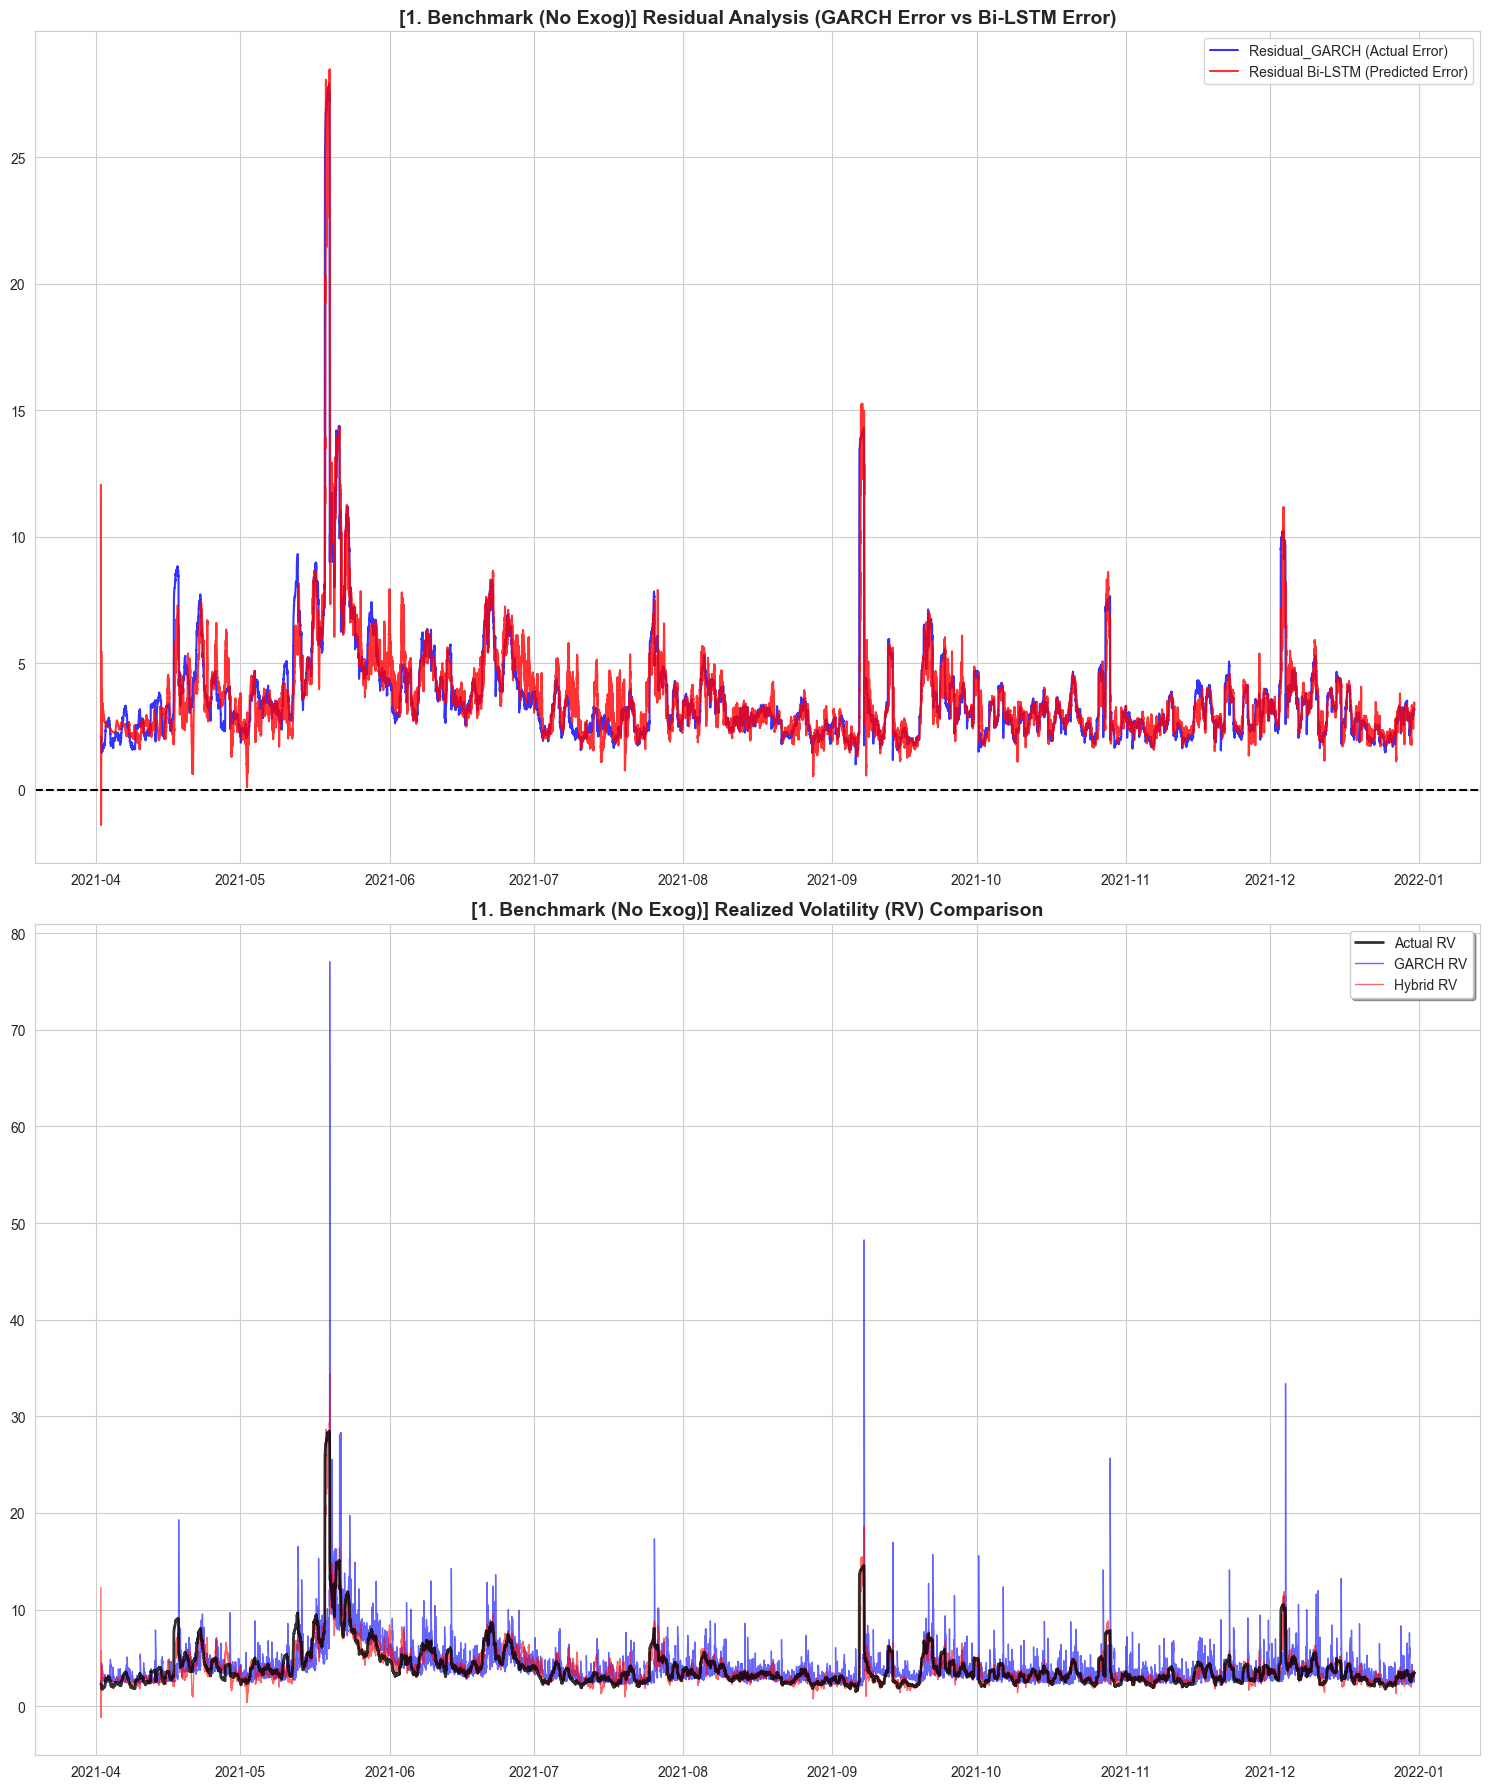


Running Scenario: 2. Hybrid (with Delta H)
------------------------------------------------------------
[INFO] Base Model Running (Exog: delta_H)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:04,  2.19it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070091
   - Beta  (GARCH) : 0.871729
   - m     (Const) : 0.198577  -> (m^2 used: 0.03943296)
   - Theta (RV_Wgt): 0.056993  -> (theta^2 used: 0.00324821)
   - W_Exog(exog_x): 0.523074  -> (w^2 used: 0.27360602)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.377737
   - Min : 0.251858
   - Max : 0.846031
   - First 5 values: [0.48179433 0.69485575 0.66023916 0.64681892 0.63239454]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061719
   - Beta  (GARCH) : 0.891641
   - m     (Const) : 0.108098  -> (m^2 used: 0.01168509)
   - Theta (RV_Wgt): 0.065459  -> (theta^2 used: 0.00428488)
   - W_Exog(exog_x): 0.362040  -> (w^2 used: 0.13107311)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.302600
   - Min : 0.180107
   - Max : 1.599681
   - First 5 values: [0.29957186 0.29581788 0.28684786 0.27968688 0.27903383]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:01<00:04,  1.56it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087343
   - Beta  (GARCH) : 0.861706
   - m     (Const) : 0.117793  -> (m^2 used: 0.01387510)
   - Theta (RV_Wgt): 0.074237  -> (theta^2 used: 0.00551107)
   - W_Exog(exog_x): 0.102133  -> (w^2 used: 0.01043110)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.544174
   - Min : 0.205845
   - Max : 6.419716
   - First 5 values: [0.31044161 0.31595478 0.30430841 0.29762971 0.28798523]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.03s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096845
   - Beta  (GARCH) : 0.858459
   - m     (Const) : 0.060421  -> (m^2 used: 0.00365069)
   - Theta (RV_Wgt): 0.069765  -> (theta^2 used: 0.00486716)
   - W_Exog(exog_x): 0.423497  -> (w^2 used: 0.17934956)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.417339
   - Min : 0.259765
   - Max : 1.191374
   - First 5 values: [0.53372062 0.51553709 0.53711044 0.51545559 0.50313979]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:07,  1.45s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092217
   - Beta  (GARCH) : 0.866041
   - m     (Const) : 0.103102  -> (m^2 used: 0.01063001)
   - Theta (RV_Wgt): 0.067214  -> (theta^2 used: 0.00451769)
   - W_Exog(exog_x): 0.416101  -> (w^2 used: 0.17313994)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285561
   - Min : 0.172185
   - Max : 1.444273
   - First 5 values: [0.37353792 0.35734488 0.34322337 0.32993746 0.31823309]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:08<00:07,  1.81s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097124
   - Beta  (GARCH) : 0.854127
   - m     (Const) : 0.101030  -> (m^2 used: 0.01020712)
   - Theta (RV_Wgt): 0.064773  -> (theta^2 used: 0.00419559)
   - W_Exog(exog_x): 0.431719  -> (w^2 used: 0.18638135)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.280920
   - Min : 0.181070
   - Max : 0.734934
   - First 5 values: [0.30638544 0.2981975  0.28976073 0.27835851 0.28346826]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:06,  2.07s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102867
   - Beta  (GARCH) : 0.836327
   - m     (Const) : 0.088582  -> (m^2 used: 0.00784679)
   - Theta (RV_Wgt): 0.065308  -> (theta^2 used: 0.00426513)
   - W_Exog(exog_x): 0.407222  -> (w^2 used: 0.16583001)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.326508
   - Min : 0.167515
   - Max : 4.028238
   - First 5 values: [0.24043493 0.25403885 0.24168602 0.24846983 0.25025957]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:12<00:03,  1.92s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115628
   - Beta  (GARCH) : 0.824545
   - m     (Const) : 0.195121  -> (m^2 used: 0.03807217)
   - Theta (RV_Wgt): 0.067223  -> (theta^2 used: 0.00451888)
   - W_Exog(exog_x): 0.113910  -> (w^2 used: 0.01297558)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277386
   - Min : 0.186576
   - Max : 2.138481
   - First 5 values: [0.2422734  0.23554952 0.23697176 0.23154184 0.24719739]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.29s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128903
   - Beta  (GARCH) : 0.784297
   - m     (Const) : 0.200278  -> (m^2 used: 0.04011116)
   - Theta (RV_Wgt): 0.063423  -> (theta^2 used: 0.00402242)
   - W_Exog(exog_x): 0.179014  -> (w^2 used: 0.03204607)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.271919
   - Min : 0.185358
   - Max : 1.175185
   - First 5 values: [0.24376167 0.28177332 0.28226136 0.26788998 0.26142017]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136233
   - Beta  (GARCH) : 0.772050
   - m     (Const) : 0.203528  -> (m^2 used: 0.04142379)
   - Theta (RV_Wgt): 0.065279  -> (theta^2 used: 0.00426132)
   - W_Exog(exog_x): 0.063402  -> (w^2 used: 0.00401984)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296755
   - Min : 0.183598
   - Max : 2.781206
   - First 5 values: [0.29089162 0.32570109 0.30846527 0.30898545 0.30596511]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1371.15it/s]


Final Data shape: (43632, 729)
Rolling Bi-LSTM Start (Train Window: 30 days, Test Period: 273)

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


Bi-LSTM Rolling Update: 100%|██████████| 39312/39312 [18:04<00:00, 36.26it/s]


RMSE Base: 4.2648 -> Hybrid: 0.9223 (78.37% Improved)


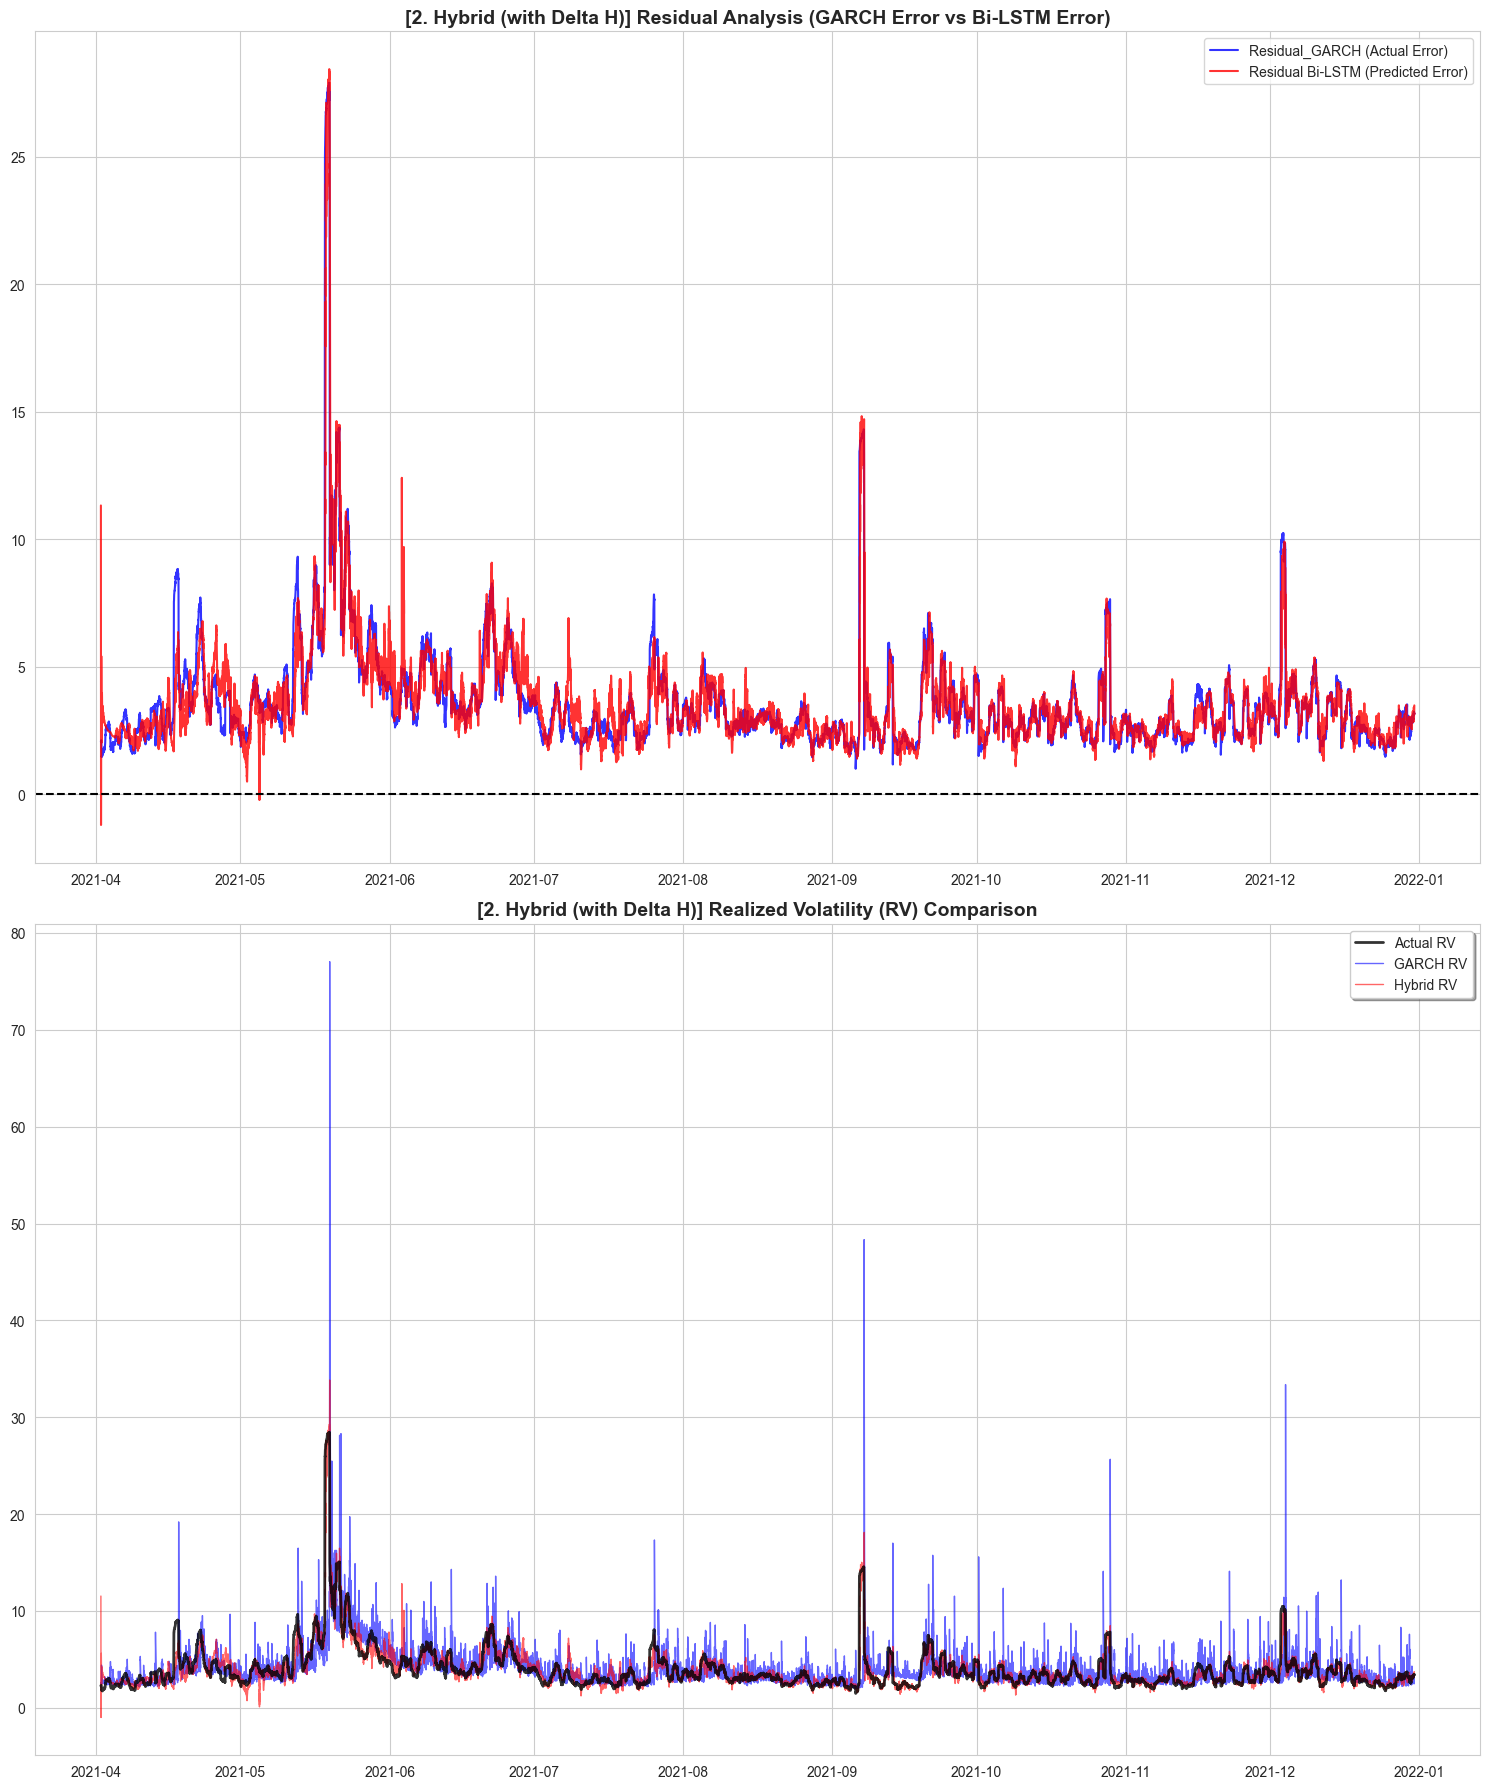


Running Scenario: 3. Hybrid (with Delta Alpha)
------------------------------------------------------------
[INFO] Base Model Running (Exog: delta_alpha)
   -> RV 데이터 기간: 2021-01-01 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> MF-DFA 데이터 기간: 2021-01-31 00:00:00+00:00 ~ 2021-12-31 00:00:00+00:00
   -> 겹치는 날짜 수: 335일


Monthly Re-fitting:   0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  10%|█         | 1/10 [00:00<00:03,  2.47it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.070106
   - Beta  (GARCH) : 0.872798
   - m     (Const) : 0.256855  -> (m^2 used: 0.06597432)
   - Theta (RV_Wgt): 0.055086  -> (theta^2 used: 0.00303450)
   - W_Exog(exog_x): 0.304598  -> (w^2 used: 0.09277996)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.376625
   - Min : 0.254813
   - Max : 0.846042
   - First 5 values: [0.47877908 0.69277914 0.65822367 0.64487822 0.63049825]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  20%|██        | 2/10 [00:01<00:04,  1.73it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.061782
   - Beta  (GARCH) : 0.891771
   - m     (Const) : 0.140976  -> (m^2 used: 0.01987426)
   - Theta (RV_Wgt): 0.065164  -> (theta^2 used: 0.00424640)
   - W_Exog(exog_x): 0.228748  -> (w^2 used: 0.05232571)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.303501
   - Min : 0.182793
   - Max : 1.600903
   - First 5 values: [0.3004635  0.29671594 0.28776322 0.28061569 0.27996095]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|███       | 3/10 [00:02<00:05,  1.29it/s]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.087387
   - Beta  (GARCH) : 0.861689
   - m     (Const) : 0.123958  -> (m^2 used: 0.01536569)
   - Theta (RV_Wgt): 0.074428  -> (theta^2 used: 0.00553952)
   - W_Exog(exog_x): 0.000382  -> (w^2 used: 0.00000015)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.543999
   - Min : 0.204958
   - Max : 6.421263
   - First 5 values: [0.30991454 0.31544766 0.30378296 0.29709548 0.287434  ]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  40%|████      | 4/10 [00:03<00:06,  1.01s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.096893
   - Beta  (GARCH) : 0.858214
   - m     (Const) : 0.053827  -> (m^2 used: 0.00289736)
   - Theta (RV_Wgt): 0.069581  -> (theta^2 used: 0.00484153)
   - W_Exog(exog_x): 0.317074  -> (w^2 used: 0.10053579)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.416163
   - Min : 0.258064
   - Max : 1.191219
   - First 5 values: [0.53234143 0.51408126 0.53571251 0.51397258 0.50160634]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 5/10 [00:05<00:06,  1.31s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.092249
   - Beta  (GARCH) : 0.865775
   - m     (Const) : 0.087821  -> (m^2 used: 0.00771255)
   - Theta (RV_Wgt): 0.066967  -> (theta^2 used: 0.00448457)
   - W_Exog(exog_x): 0.321880  -> (w^2 used: 0.10360661)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.285382
   - Min : 0.172174
   - Max : 1.444256
   - First 5 values: [0.37323709 0.3570137  0.34286826 0.32956255 0.31784327]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  60%|██████    | 6/10 [00:07<00:06,  1.64s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.097177
   - Beta  (GARCH) : 0.853864
   - m     (Const) : 0.089420  -> (m^2 used: 0.00799591)
   - Theta (RV_Wgt): 0.064573  -> (theta^2 used: 0.00416969)
   - W_Exog(exog_x): 0.330372  -> (w^2 used: 0.10914555)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.281654
   - Min : 0.182009
   - Max : 0.735256
   - First 5 values: [0.30689694 0.29868622 0.29023287 0.27882272 0.28391236]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 7/10 [00:10<00:05,  1.98s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.102813
   - Beta  (GARCH) : 0.836312
   - m     (Const) : 0.075260  -> (m^2 used: 0.00566407)
   - Theta (RV_Wgt): 0.065191  -> (theta^2 used: 0.00424990)
   - W_Exog(exog_x): 0.311166  -> (w^2 used: 0.09682454)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.325669
   - Min : 0.167784
   - Max : 4.027171
   - First 5 values: [0.24054598 0.25414151 0.24180437 0.24858469 0.25037527]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|████████  | 8/10 [00:13<00:04,  2.22s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.115626
   - Beta  (GARCH) : 0.824493
   - m     (Const) : 0.193525  -> (m^2 used: 0.03745199)
   - Theta (RV_Wgt): 0.067158  -> (theta^2 used: 0.00451013)
   - W_Exog(exog_x): 0.094579  -> (w^2 used: 0.00894513)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.277453
   - Min : 0.186656
   - Max : 2.138425
   - First 5 values: [0.24239673 0.23567779 0.23710063 0.23167495 0.24732286]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  90%|█████████ | 9/10 [00:15<00:02,  2.36s/it]

----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.128875
   - Beta  (GARCH) : 0.784329
   - m     (Const) : 0.192757  -> (m^2 used: 0.03715529)
   - Theta (RV_Wgt): 0.063186  -> (theta^2 used: 0.00399242)
   - W_Exog(exog_x): 0.160381  -> (w^2 used: 0.02572197)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.272954
   - Min : 0.187048
   - Max : 1.175324
   - First 5 values: [0.2443579  0.28227177 0.28275228 0.26840495 0.26194445]
------------------------------------------------------------
[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


----------------------------------------
[DEBUG] Optimization Result: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH (Success: True)
[DEBUG] Best Parameters:
   - Alpha (GARCH) : 0.136228
   - Beta  (GARCH) : 0.772053
   - m     (Const) : 0.203473  -> (m^2 used: 0.04140123)
   - Theta (RV_Wgt): 0.065286  -> (theta^2 used: 0.00426221)
   - W_Exog(exog_x): 0.047281  -> (w^2 used: 0.00223545)
[DEBUG] Predicted RV (gm_vol) Stats (Test Period):
   - Mean: 0.296772
   - Min : 0.183630
   - Max : 2.781154
   - First 5 values: [0.29089949 0.32570717 0.30847283 0.30899325 0.30597332]
------------------------------------------------------------
Complete 44063 Created
Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1375.46it/s]


Final Data shape: (43632, 729)
Rolling Bi-LSTM Start (Train Window: 30 days, Test Period: 273)

[INFO] Bi-LSTM Rolling Simulation Start
 -> 총 데이터: 43632, 시뮬레이션 시작 인덱스: 4320
 -> 예측 구간: 약 273일 (39312 steps)


Bi-LSTM Rolling Update: 100%|██████████| 39312/39312 [18:03<00:00, 36.28it/s]


RMSE Base: 4.2648 -> Hybrid: 0.9105 (78.65% Improved)


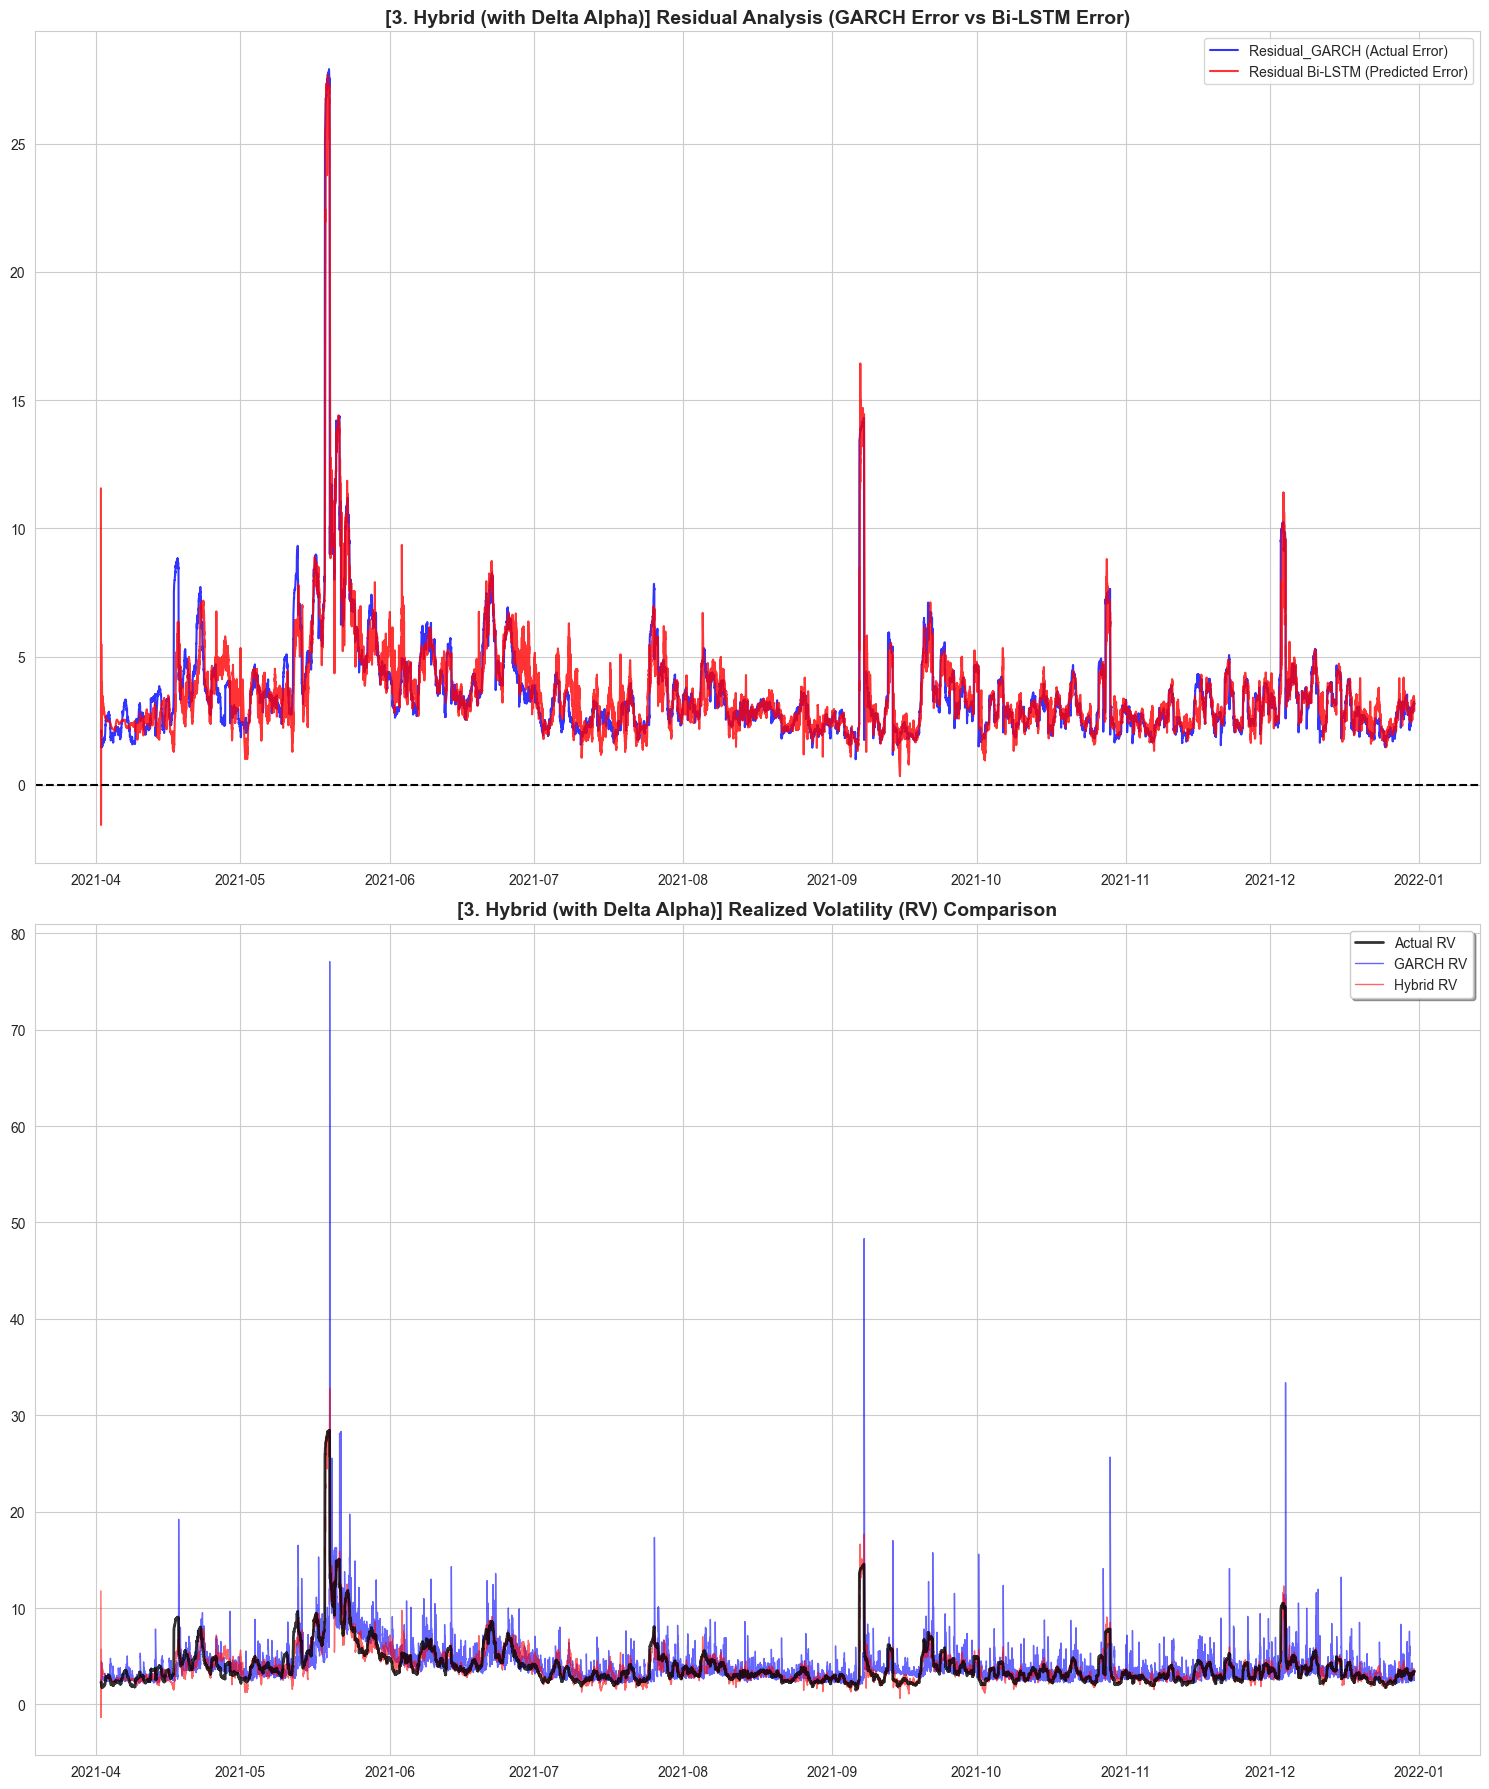


Final Leaderboard
                          Model  RMSE_Base  RMSE_Hybrid  Improvement (%)
0        1. Benchmark (No Exog)   4.266418     0.927078        78.270343
1      2. Hybrid (with Delta H)   4.264763     0.922333        78.373175
2  3. Hybrid (with Delta Alpha)   4.264791     0.910521        78.650286


In [11]:
def plot_model_result(eval_df, model_name):
    sns.set_style(style = "whitegrid")

    fig, axes = plt.subplots(2, 1, figsize = (15, 18))

    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
        
    # daily_df = eval_df[['Residual', pred_col]].resample('1D').mean()
    
    axes[0].plot(eval_df.index, eval_df['Residual'],
                 label = 'Residual_GARCH (Actual Error)', color = 'blue', alpha = 0.8)
    axes[0].plot(eval_df.index, eval_df[pred_col],
                 label = 'Residual Bi-LSTM (Predicted Error)', color = 'red', alpha = 0.8)
    axes[0].set_title(F"[{model_name}] Residual Analysis (GARCH Error vs Bi-LSTM Error)", fontsize = 14, fontweight = 'bold')
    axes[0].axhline(0, color = 'black', linestyle = '--')
    axes[0].legend(loc = 'upper right')
    
    actual_vol = eval_df['Future_Vol_24h']
    garch_vol = eval_df['Base_Vol'] * 12
    
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    axes[1].plot(eval_df.index, actual_vol, label = 'Actual RV', color = 'black', alpha = 0.8, linewidth = 2, zorder = 2)
    axes[1].plot(eval_df.index, garch_vol, label = 'GARCH RV', color = 'blue', alpha = 0.6, linewidth = 1, zorder = 1)
    axes[1].plot(eval_df.index, hybrid_vol, label = 'Hybrid RV', color = 'red', alpha = 0.6, linewidth = 1, zorder = 1)
    
    axes[1].set_title(f"[{model_name}] Realized Volatility (RV) Comparison", fontsize = 14, fontweight = 'bold')
    axes[1].legend(loc = 'upper right', frameon = True, shadow = True)
    
    plt.tight_layout()
    plt.show()

scenarios = {
    "1. Benchmark (No Exog)": None,
    "2. Hybrid (with Delta H)": "delta_H",
    "3. Hybrid (with Delta Alpha)": "delta_alpha"
}

results_summary = []

print("="*80)
print("Compare 3 GARCH-MIDAS Model")
print("="*80)

for model_name, exog_col in scenarios.items():
    print(f"\nRunning Scenario: {model_name}")
    print('-'*60)
    
    try:
        df_base = monthly_garch_midas(df_10m ,mfdfa_2021, exog_col = exog_col)
    except Exception as e:
        print(f"Error: {e}")
        continue
    
    flat_data, features = prepare_flatten_features(df_base, mfdfa_2021, lags = 144)
    
    TRAIN_WINDOW = 4320
    
    TEST_DAYS = (len(flat_data) - TRAIN_WINDOW) // 144
    
    print(f"Rolling Bi-LSTM Start (Train Window: 30 days, Test Period: {TEST_DAYS})")
    
    final_result = run_rolling_flatten_bilstm(
        flat_data, features, train_window = TRAIN_WINDOW, test_days =TEST_DAYS
    )
    
    eval_df = final_result.dropna()
    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
    else:
        raise KeyError(f"예측 컬럼을 찾을 수 없습니다! 현재 컬럼 목록: {eval_df.columns.tolist()}")
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
    rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], hybrid_vol))
    improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
    
    print(f"RMSE Base: {rmse_base:.4f} -> Hybrid: {rmse_hybrid:.4f} ({improvement:.2f}% Improved)")
    
    results_summary.append({
        "Model": model_name,
        "RMSE_Base": rmse_base,
        "RMSE_Hybrid": rmse_hybrid,
        "Improvement (%)": improvement
    })
    
    plot_model_result(eval_df, model_name)
    
print("\n" + "="*80)
print("Final Leaderboard")
print(pd.DataFrame(results_summary))

Compare 3 GARCH-MIDAS Models (Tuned: K=60, Lags=288)

Running Scenario: 1. Benchmark (No Exog)
------------------------------------------------------------
[INFO] Pre-computing MIDAS features (Recalculating Daily RV internally)...
   [Check] MIDAS Feature Variation (First 5 Days):
datetime
2021-03-02    40.185608
2021-03-03    38.853156
2021-03-04    37.520868
2021-03-05    37.481674
2021-03-06    37.002849
Freq: D, Name: midas_rv_global, dtype: float64
 -> Done. Features recalculated and merged.
[INFO] Starting Walk-Forward Validation...


Monthly Re-fitting: 100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


[Diagnosis 1] Check Input Data Variation
                     midas_rv_global  exog_midas_global
datetime                                               
2021-01-01 00:10:00        40.185608                0.0
2021-01-01 00:20:00        40.185608                0.0
2021-01-01 00:30:00        40.185608                0.0
2021-01-01 00:40:00        40.185608                0.0
2021-01-01 00:50:00        40.185608                0.0
2021-01-01 01:00:00        40.185608                0.0
2021-01-01 01:10:00        40.185608                0.0
2021-01-01 01:20:00        40.185608                0.0
2021-01-01 01:30:00        40.185608                0.0
2021-01-01 01:40:00        40.185608                0.0
------------------------------
                     midas_rv_global  exog_midas_global
datetime                                               
2021-01-11 00:10:00        40.185608                0.0
2021-01-11 00:20:00        40.185608                0.0
2021-01-11 00:30:00        40.18

Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1439.91it/s]


Final Data shape: (43498, 1449)
Rolling LSTM Start (Train Window: 30 days, Test Period: 272)

[INFO] Rolling Simulation Start
 -> 총 데이터: 43498, 시뮬레이션 시작 인덱스: 4330
 -> 예측 구간: 약 272일 (39168 steps)
RMSE Base: 4.3497 -> Hybrid: 0.7642 (82.43% Improved)


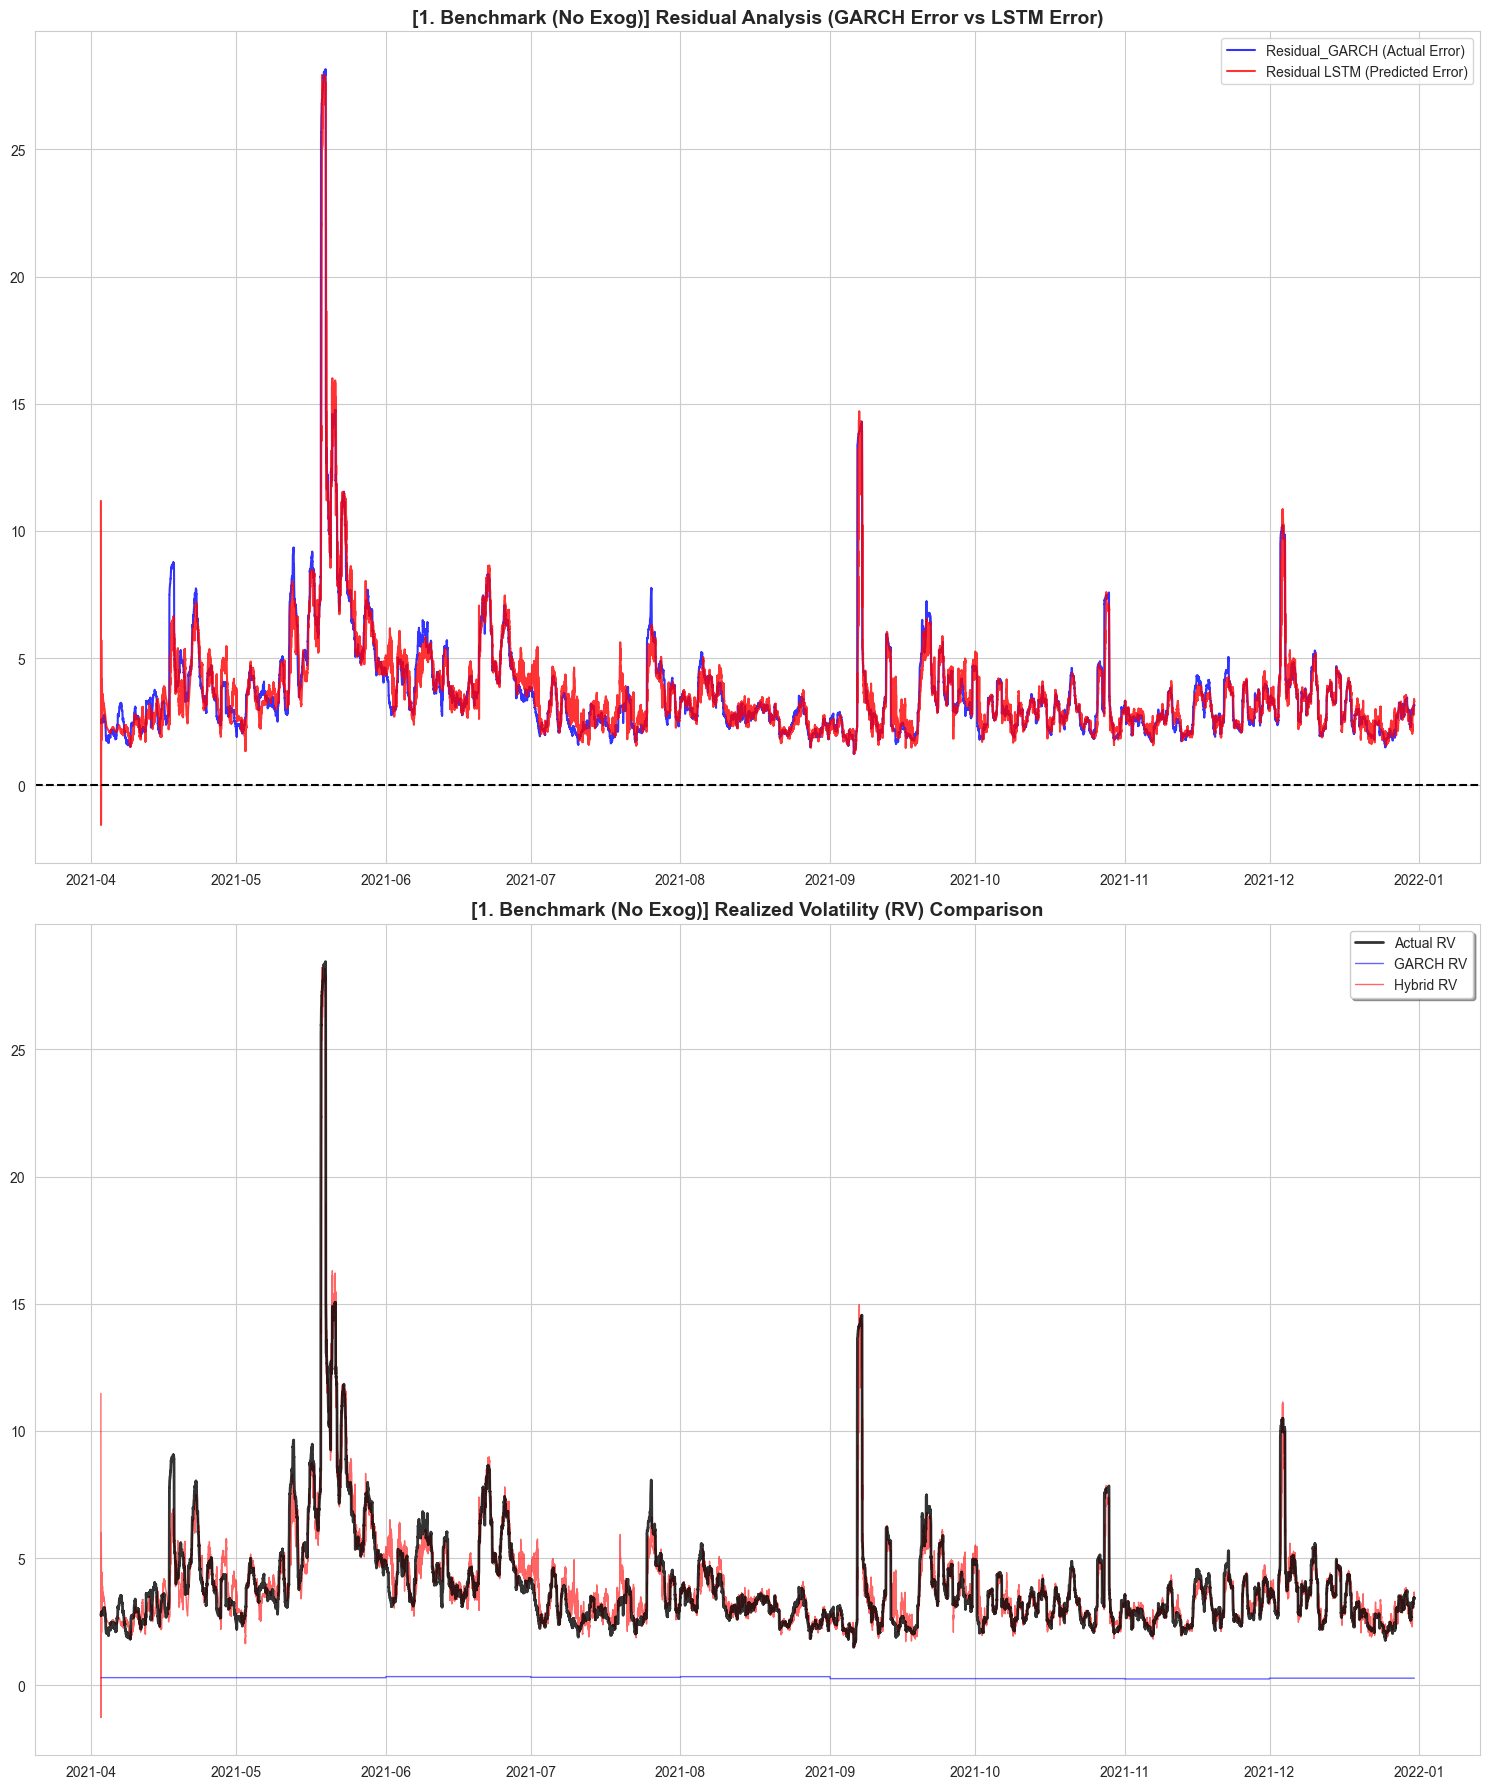


Running Scenario: 2. Hybrid (with Delta H)
------------------------------------------------------------
[INFO] Pre-computing MIDAS features (Recalculating Daily RV internally)...
   [Check] MIDAS Feature Variation (First 5 Days):
datetime
2021-03-02    40.185608
2021-03-03    38.853156
2021-03-04    37.520868
2021-03-05    37.481674
2021-03-06    37.002849
Freq: D, Name: midas_rv_global, dtype: float64
 -> Done. Features recalculated and merged.
[INFO] Starting Walk-Forward Validation...


Monthly Re-fitting: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Diagnosis 1] Check Input Data Variation
                     midas_rv_global  exog_midas_global
datetime                                               
2021-01-01 00:10:00        40.185608           0.205102
2021-01-01 00:20:00        40.185608           0.205102
2021-01-01 00:30:00        40.185608           0.205102
2021-01-01 00:40:00        40.185608           0.205102
2021-01-01 00:50:00        40.185608           0.205102
2021-01-01 01:00:00        40.185608           0.205102
2021-01-01 01:10:00        40.185608           0.205102
2021-01-01 01:20:00        40.185608           0.205102
2021-01-01 01:30:00        40.185608           0.205102
2021-01-01 01:40:00        40.185608           0.205102
------------------------------
                     midas_rv_global  exog_midas_global
datetime                                               
2021-01-11 00:10:00        40.185608           0.205102
2021-01-11 00:20:00        40.185608           0.205102
2021-01-11 00:30:00        40.18

Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1408.55it/s]


Final Data shape: (43498, 1449)
Rolling LSTM Start (Train Window: 30 days, Test Period: 272)

[INFO] Rolling Simulation Start
 -> 총 데이터: 43498, 시뮬레이션 시작 인덱스: 4330
 -> 예측 구간: 약 272일 (39168 steps)
RMSE Base: 4.3511 -> Hybrid: 0.7912 (81.82% Improved)


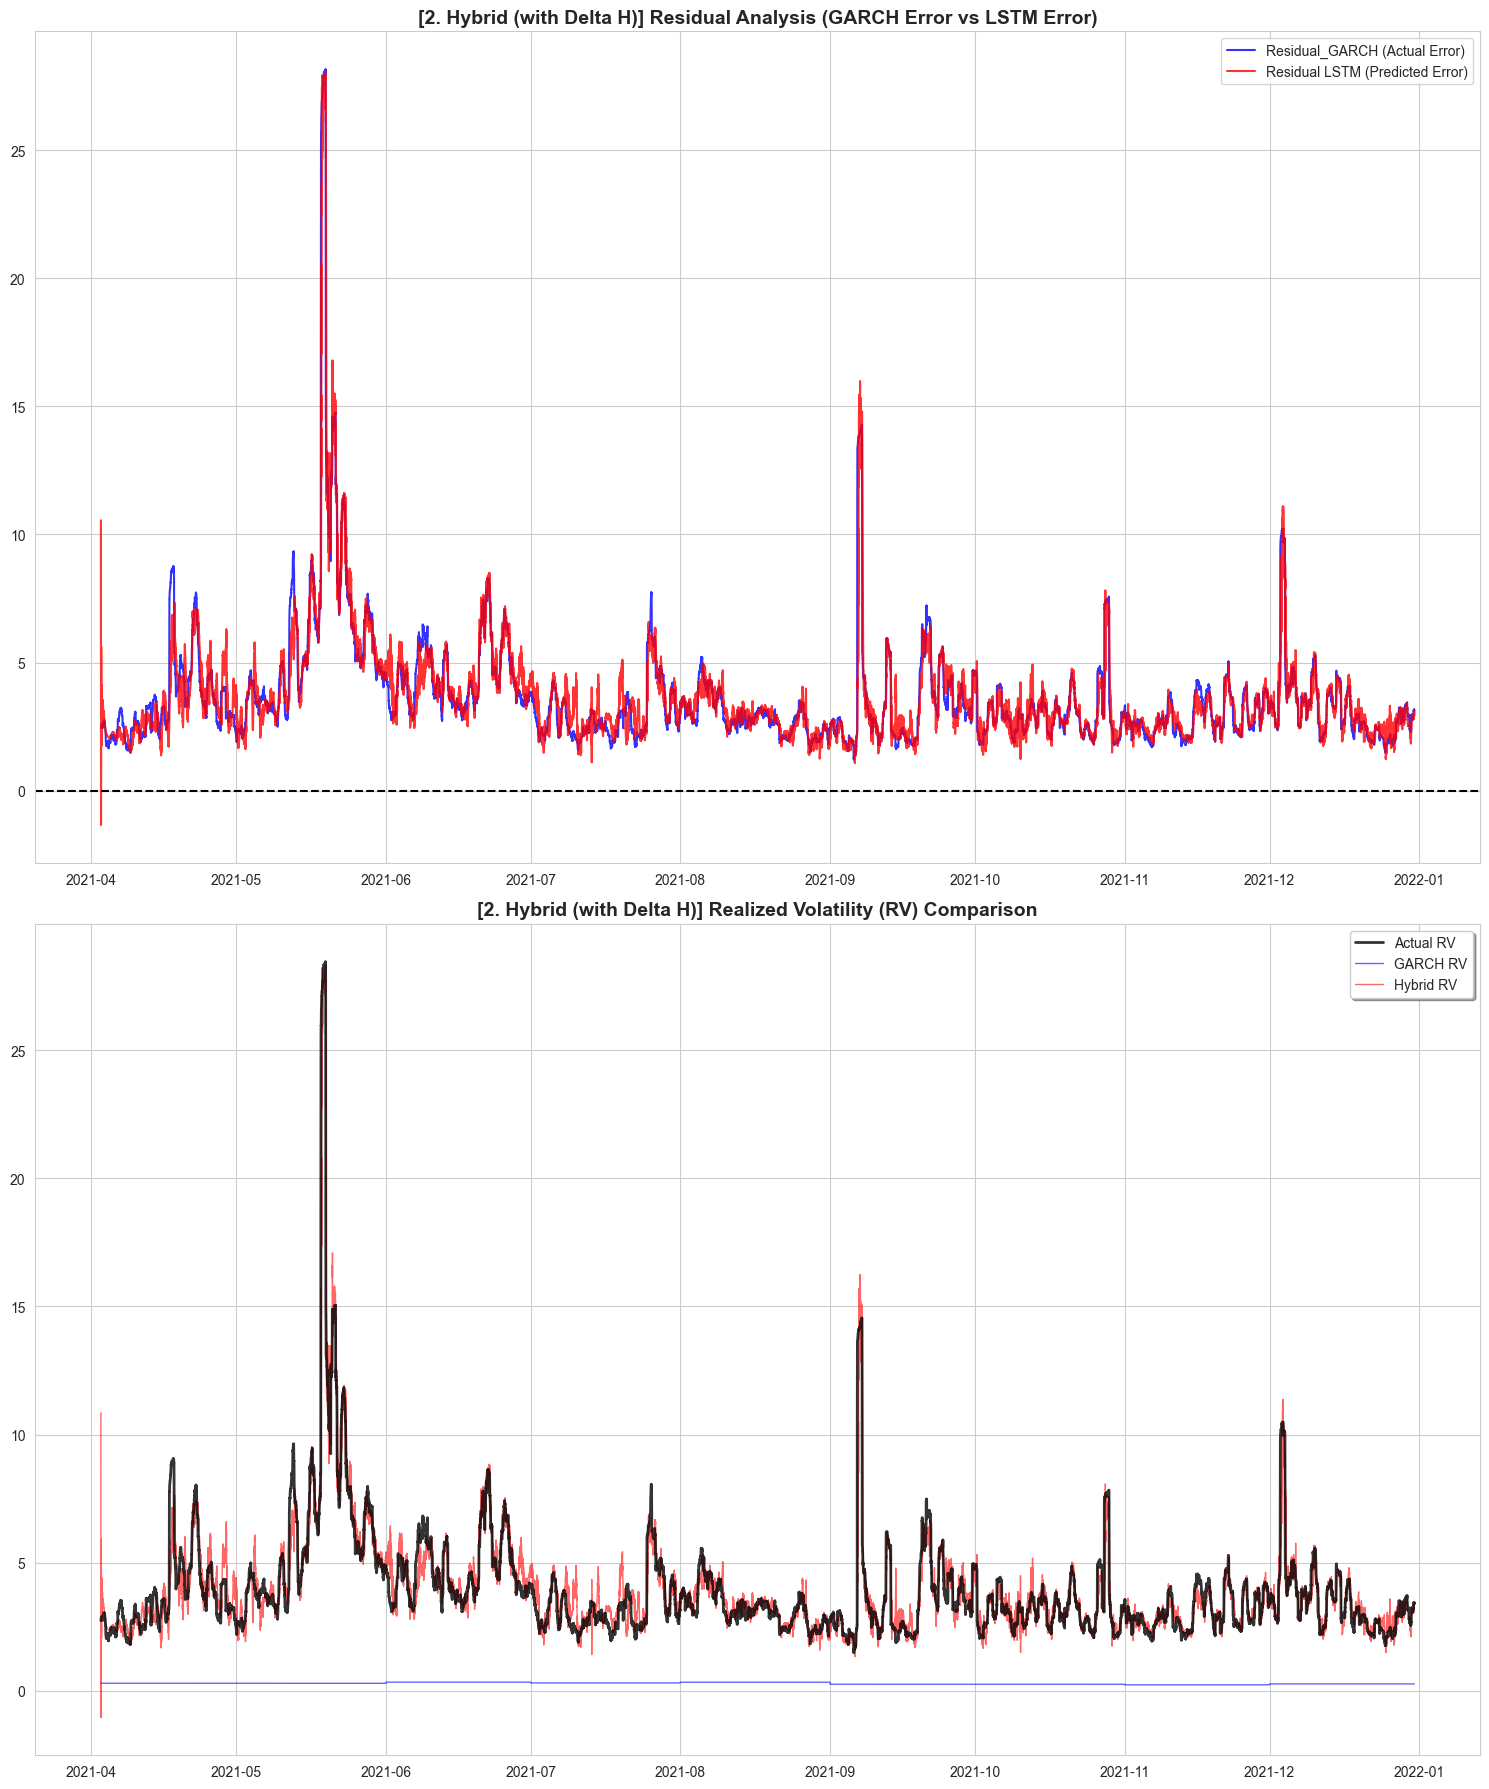


Running Scenario: 3. Hybrid (with Delta Alpha)
------------------------------------------------------------
[INFO] Pre-computing MIDAS features (Recalculating Daily RV internally)...
   [Check] MIDAS Feature Variation (First 5 Days):
datetime
2021-03-02    40.185608
2021-03-03    38.853156
2021-03-04    37.520868
2021-03-05    37.481674
2021-03-06    37.002849
Freq: D, Name: midas_rv_global, dtype: float64
 -> Done. Features recalculated and merged.
[INFO] Starting Walk-Forward Validation...


Monthly Re-fitting: 100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


[Diagnosis 1] Check Input Data Variation
                     midas_rv_global  exog_midas_global
datetime                                               
2021-01-01 00:10:00        40.185608           0.374939
2021-01-01 00:20:00        40.185608           0.374939
2021-01-01 00:30:00        40.185608           0.374939
2021-01-01 00:40:00        40.185608           0.374939
2021-01-01 00:50:00        40.185608           0.374939
2021-01-01 01:00:00        40.185608           0.374939
2021-01-01 01:10:00        40.185608           0.374939
2021-01-01 01:20:00        40.185608           0.374939
2021-01-01 01:30:00        40.185608           0.374939
2021-01-01 01:40:00        40.185608           0.374939
------------------------------
                     midas_rv_global  exog_midas_global
datetime                                               
2021-01-11 00:10:00        40.185608           0.374939
2021-01-11 00:20:00        40.185608           0.374939
2021-01-11 00:30:00        40.18

Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1349.62it/s]


Final Data shape: (43498, 1449)
Rolling LSTM Start (Train Window: 30 days, Test Period: 272)

[INFO] Rolling Simulation Start
 -> 총 데이터: 43498, 시뮬레이션 시작 인덱스: 4330
 -> 예측 구간: 약 272일 (39168 steps)
RMSE Base: 4.3585 -> Hybrid: 0.7945 (81.77% Improved)


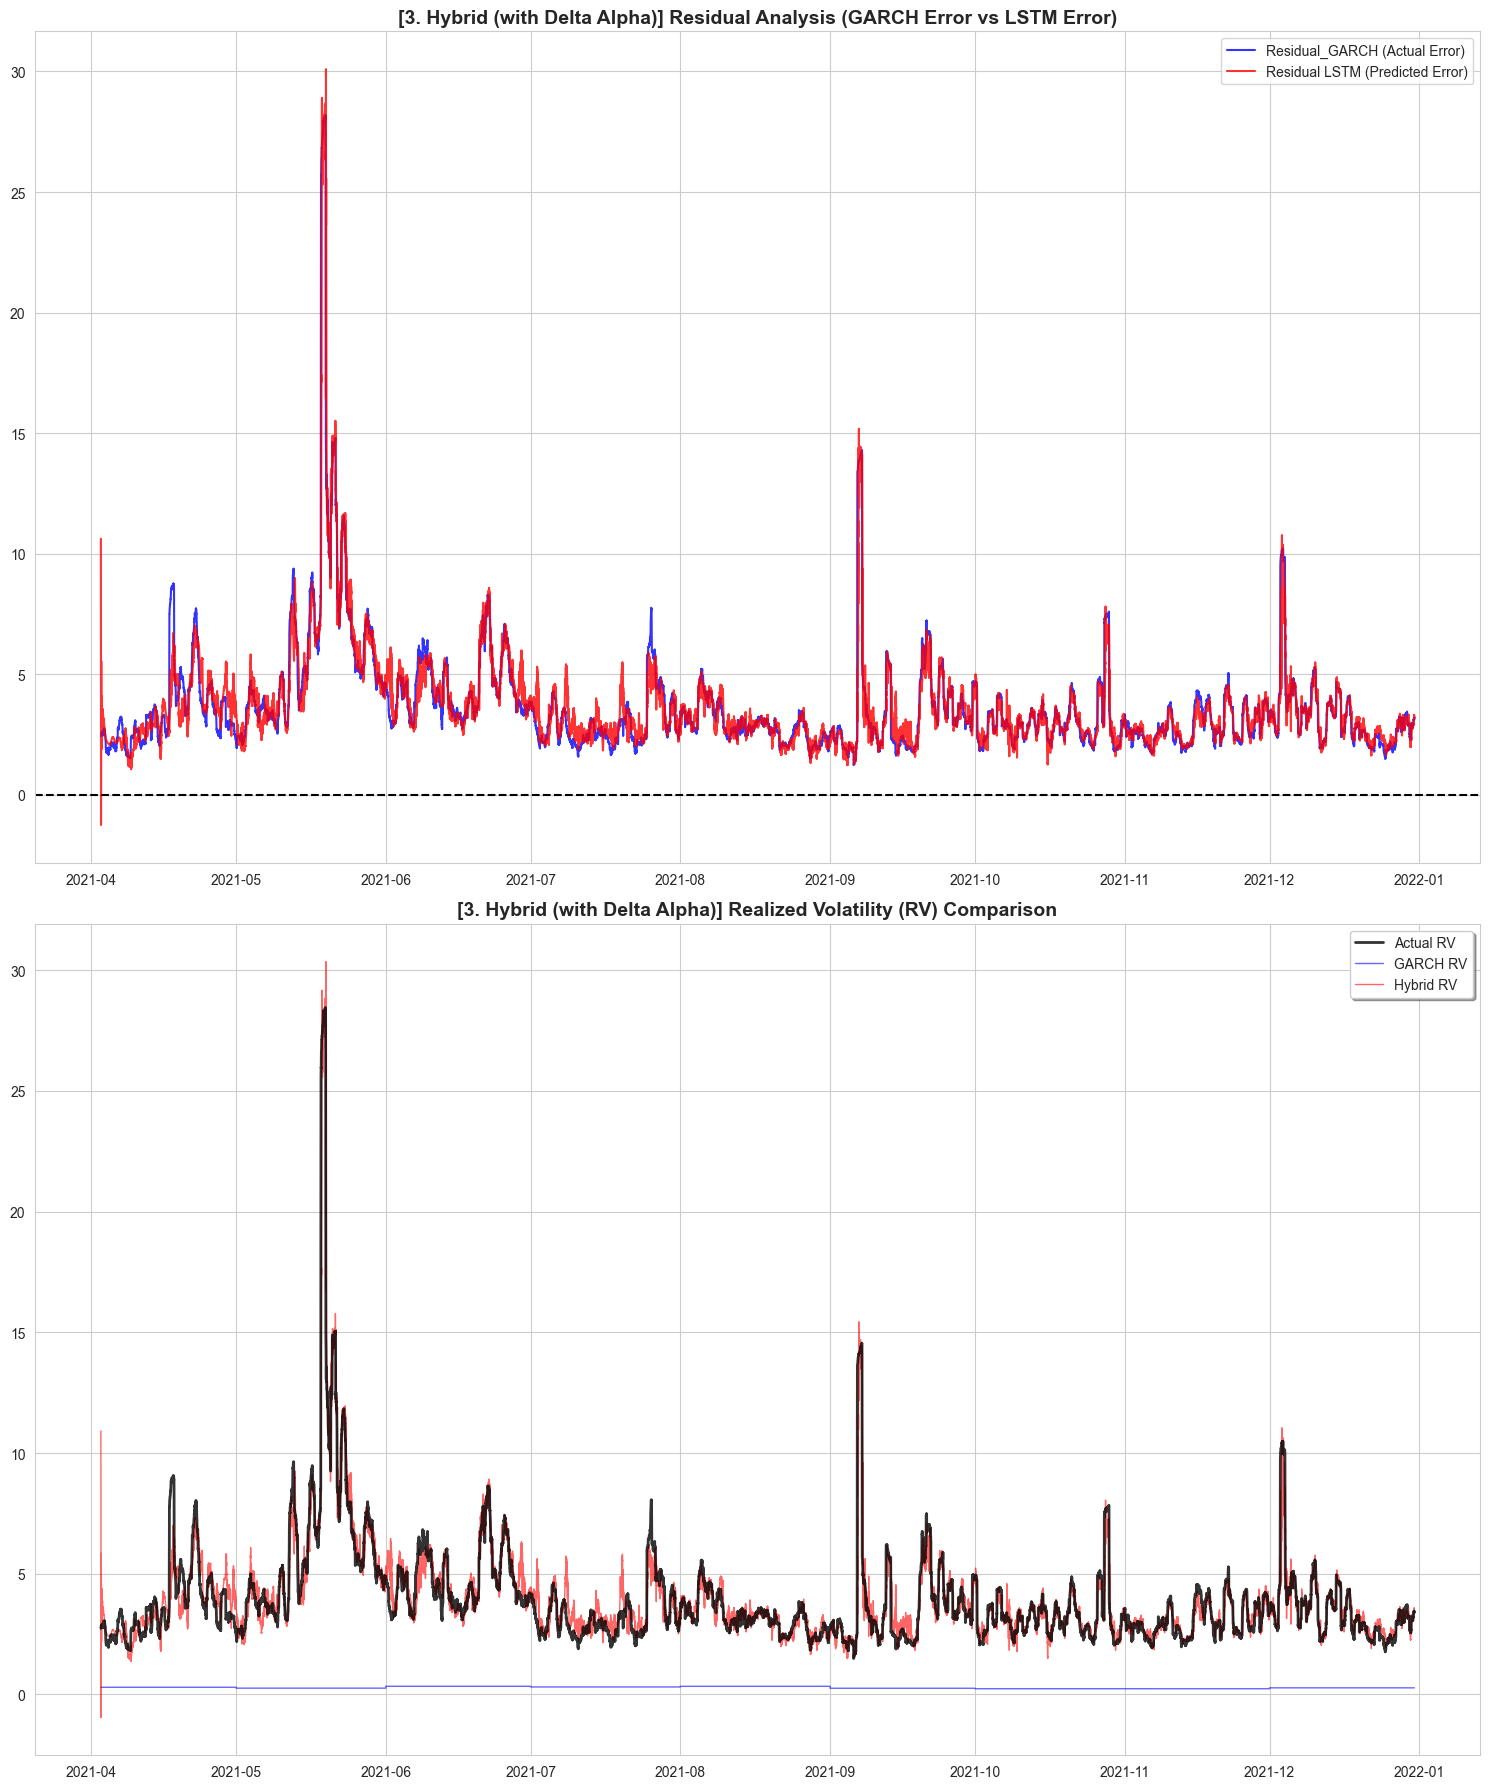


Final Leaderboard
                          Model  RMSE_Base  RMSE_Hybrid  Improvement (%)
0        1. Benchmark (No Exog)   4.349707     0.764226        82.430411
1      2. Hybrid (with Delta H)   4.351074     0.791153        81.817060
2  3. Hybrid (with Delta Alpha)   4.358514     0.794486        81.771632


In [21]:
TUNED_K = 60           # GARCH Window
TUNED_DIST = 'Normal'  # Distribution
TUNED_LAGS = 288       # LSTM Lags (2일치)
TUNED_HIDDEN = 256     # LSTM Hidden Size
TUNED_LAYERS = 2       # LSTM Layers

def plot_model_result(eval_df, model_name):
    sns.set_style(style = "whitegrid")
    fig, axes = plt.subplots(2, 1, figsize = (15, 18))
    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
    else:
        return # 컬럼 없으면 패스

    # 1. Residual Plot
    axes[0].plot(eval_df.index, eval_df['Residual'],
                 label = 'Residual_GARCH (Actual Error)', color = 'blue', alpha = 0.8)
    axes[0].plot(eval_df.index, eval_df[pred_col],
                 label = 'Residual LSTM (Predicted Error)', color = 'red', alpha = 0.8)
    axes[0].set_title(f"[{model_name}] Residual Analysis (GARCH Error vs LSTM Error)", fontsize = 14, fontweight = 'bold')
    axes[0].axhline(0, color = 'black', linestyle = '--')
    axes[0].legend(loc = 'upper right')
    
    # 2. RV Comparison Plot
    actual_vol = eval_df['Future_Vol_24h']
    garch_vol = eval_df['Base_Vol']
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    axes[1].plot(eval_df.index, actual_vol, label = 'Actual RV', color = 'black', alpha = 0.8, linewidth = 2, zorder = 2)
    axes[1].plot(eval_df.index, garch_vol, label = 'GARCH RV', color = 'blue', alpha = 0.6, linewidth = 1, zorder = 1)
    axes[1].plot(eval_df.index, hybrid_vol, label = 'Hybrid RV', color = 'red', alpha = 0.6, linewidth = 1, zorder = 1)
    
    axes[1].set_title(f"[{model_name}] Realized Volatility (RV) Comparison", fontsize = 14, fontweight = 'bold')
    axes[1].legend(loc = 'upper right', frameon = True, shadow = True)
    
    plt.tight_layout()
    plt.show()

# 시나리오 설정
scenarios = {
    "1. Benchmark (No Exog)": None,
    "2. Hybrid (with Delta H)": "delta_H",
    "3. Hybrid (with Delta Alpha)": "delta_alpha"
}

results_summary = []
daily_rv_all = (df_10m['return']**2).resample('1D').sum().to_frame('rv')

print("="*80)
print(f"Compare 3 GARCH-MIDAS Models (Tuned: K={TUNED_K}, Lags={TUNED_LAGS})")
print("="*80)

for model_name, exog_col in scenarios.items():
    print(f"\nRunning Scenario: {model_name}")
    print('-'*60)
    
    try:
        # ---------------------------------------------------------
        # [핵심 수정 1] MIDAS 변수 미리 계산 (Pre-computation)
        # ---------------------------------------------------------
        # 여기서 전체 기간에 대해 MIDAS 값을 계산해서 박아넣습니다.
        df_prepared = precompute_midas_features(
            df_10m, daily_rv_all, mfdfa_2021, 
            exog_col=exog_col, 
            midas_k=TUNED_K
        )
        
        # ---------------------------------------------------------
        # [핵심 수정 2] 루프 실행 (계산된 데이터 사용)
        # ---------------------------------------------------------
        df_base = monthly_garch_midas_tuned(
            df_prepared,        # 미리 계산된 데이터
            dist_type=TUNED_DIST
        )
        
        # 1. 먼저 데이터가 진짜 매일 변하는지 확인 (이게 안 변하면 전처리 문제)
        print("="*50)
        print("[Diagnosis 1] Check Input Data Variation")
        print("="*50)
        print(df_prepared[['midas_rv_global', 'exog_midas_global']].iloc[:10]) # 앞부분 10개
        print("-" * 30)
        print(df_prepared[['midas_rv_global', 'exog_midas_global']].iloc[1440:1450]) # 하루 뒤 10개
        print("="*50)

        # 테스트용으로 첫 번째 달 데이터만 뽑아서 돌려봄
        month_starts = df_prepared.resample('MS').first().index
        target_month = month_starts[2] # 3번째 달 (데이터 충분한 시점)

        train_sample = df_prepared[:target_month].copy()
        if 'ret_pct' not in train_sample.columns:
            train_sample['ret_pct'] = np.log(train_sample['close'] / train_sample['close'].shift(1)) * 100
        train_sample.dropna(inplace=True)

        def objective_debug(params):
            m, theta, beta_x = params
            # Scale이 튈 수 있으니 clip
            log_tau = m + theta * train_sample['midas_rv_global'] + beta_x * train_sample['exog_midas_global']
            tau = np.exp(np.clip(log_tau, -10, 10))
            return np.mean((train_sample['ret_pct']**2 - tau)**2)

        print(f"[Diagnosis 2] Optimization Test for {target_month.date()}")
        try:
            # 초기값을 조금 더 공격적으로 줘봅니다 (0.1 -> 0.5)
            res = minimize(objective_debug, [0.1, 0.5, 0.1], method='L-BFGS-B') 
            
            print(f" -> Optimization Success: {res.success}")
            print(f" -> Message: {res.message}")
            print(f" -> Best Params: m={res.x[0]:.6f}, theta={res.x[1]:.6f}, beta={res.x[2]:.6f}")
            
            if abs(res.x[1]) < 0.0001:
                print("\n🚨 CULPRIT FOUND: Theta is ZERO! (Optimizer ignored MIDAS)")
            else:
                print("\n✅ Theta is NOT zero. MIDAS is working.")
                
        except Exception as e:
            print(f"Error: {e}")
        
    except Exception as e:
        print(f"GARCH Error: {e}")
        import traceback
        traceback.print_exc()
        continue
    
    # [수정 2] 메모리 최적화 함수 사용 + 튜닝값 주입
    flat_data, features = prepare_flatten_features(
        df_base, mfdfa_2021, 
        lags=TUNED_LAGS         # Lags=288
    )
    
    TRAIN_WINDOW = 4320
    TEST_DAYS = (len(flat_data) - TRAIN_WINDOW) // 144
    
    print(f"Rolling LSTM Start (Train Window: 30 days, Test Period: {TEST_DAYS})")
    
    # [수정 3] _tuned 함수 사용 + 튜닝값 주입 + 리턴값 unpacking 수정
    final_result, _ = run_rolling_flatten_lstm_tuned(
        flat_data, features, 
        hidden_dim=TUNED_HIDDEN,  # Hidden=256
        num_layers=TUNED_LAYERS,  # Layers=2
        train_window=TRAIN_WINDOW, 
        test_days=TEST_DAYS
    )
    
    eval_df = final_result.dropna()
    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
    else:
        print("예측 컬럼 없음 Skip")
        continue
        
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
    rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], hybrid_vol))
    improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
    
    print(f"RMSE Base: {rmse_base:.4f} -> Hybrid: {rmse_hybrid:.4f} ({improvement:.2f}% Improved)")
    
    results_summary.append({
        "Model": model_name,
        "RMSE_Base": rmse_base,
        "RMSE_Hybrid": rmse_hybrid,
        "Improvement (%)": improvement
    })
    
    plot_model_result(eval_df, model_name)
    
print("\n" + "="*80)
print("Final Leaderboard")
print(pd.DataFrame(results_summary))

In [ ]:
TUNED_K = 30           # GARCH Window
TUNED_DIST = 'Normal'  # Distribution
TUNED_LAGS = 144       # LSTM Lags (1일치)
TUNED_HIDDEN = 128     # LSTM Hidden Size
TUNED_LAYERS = 2       # LSTM Layers

def plot_model_result(eval_df, model_name):
    sns.set_style(style = "whitegrid")
    fig, axes = plt.subplots(2, 1, figsize = (15, 18))
    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
    else:
        return # 컬럼 없으면 패스

    # 1. Residual Plot
    axes[0].plot(eval_df.index, eval_df['Residual'],
                 label = 'Residual_GARCH (Actual Error)', color = 'blue', alpha = 0.8)
    axes[0].plot(eval_df.index, eval_df[pred_col],
                 label = 'Residual LSTM (Predicted Error)', color = 'red', alpha = 0.8)
    axes[0].set_title(f"[{model_name}] Residual Analysis (GARCH Error vs LSTM Error)", fontsize = 14, fontweight = 'bold')
    axes[0].axhline(0, color = 'black', linestyle = '--')
    axes[0].legend(loc = 'upper right')
    
    # 2. RV Comparison Plot
    actual_vol = eval_df['Future_Vol_24h']
    garch_vol = eval_df['Base_Vol']
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    axes[1].plot(eval_df.index, actual_vol, label = 'Actual RV', color = 'black', alpha = 0.8, linewidth = 2, zorder = 2)
    axes[1].plot(eval_df.index, garch_vol, label = 'GARCH RV', color = 'blue', alpha = 0.6, linewidth = 1, zorder = 1)
    axes[1].plot(eval_df.index, hybrid_vol, label = 'Hybrid RV', color = 'red', alpha = 0.6, linewidth = 1, zorder = 1)
    
    axes[1].set_title(f"[{model_name}] Realized Volatility (RV) Comparison", fontsize = 14, fontweight = 'bold')
    axes[1].legend(loc = 'upper right', frameon = True, shadow = True)
    
    plt.tight_layout()
    plt.show()

# 시나리오 설정
scenarios = {
    "1. Benchmark (No Exog)": None,
    "2. Hybrid (with Delta H)": "delta_H",
    "3. Hybrid (with Delta Alpha)": "delta_alpha"
}

results_summary = []

print("="*80)
print(f"Compare 3 GARCH-MIDAS Models (Tuned: K={TUNED_K}, Lags={TUNED_LAGS})")
print("="*80)

for model_name, exog_col in scenarios.items():
    print(f"\nRunning Scenario: {model_name}")
    print('-'*60)
    
    try:
        # ---------------------------------------------------------
        # [핵심 수정 1] MIDAS 변수 미리 계산 (Pre-computation)
        # ---------------------------------------------------------
        # 여기서 전체 기간에 대해 MIDAS 값을 계산해서 박아넣습니다.
        df_prepared = precompute_midas_features(
            df_10m, daily_rv_all, mfdfa_2021, 
            exog_col=exog_col, 
            midas_k=TUNED_K
        )
        
        # ---------------------------------------------------------
        # [핵심 수정 2] 루프 실행 (계산된 데이터 사용)
        # ---------------------------------------------------------
        df_base = monthly_garch_midas_tuned(
            df_prepared,        # 미리 계산된 데이터
            dist_type=TUNED_DIST
        )
        
    except Exception as e:
        print(f"GARCH Error: {e}")
        import traceback
        traceback.print_exc()
        continue
    
    # [수정 2] 메모리 최적화 함수 사용 + 튜닝값 주입
    flat_data, features = prepare_flatten_features(
        df_base, mfdfa_2021, 
        lags=TUNED_LAGS         # Lags=288
    )
    
    TRAIN_WINDOW = 4320
    TEST_DAYS = (len(flat_data) - TRAIN_WINDOW) // 144
    
    print(f"Rolling LSTM Start (Train Window: 30 days, Test Period: {TEST_DAYS})")
    
    # [수정 3] _tuned 함수 사용 + 튜닝값 주입 + 리턴값 unpacking 수정
    final_result, _ = run_rolling_flatten_lstm_tuned(
        flat_data, features, 
        hidden_dim=TUNED_HIDDEN,  # Hidden=256
        num_layers=TUNED_LAYERS,  # Layers=2
        train_window=TRAIN_WINDOW, 
        test_days=TEST_DAYS
    )
    
    eval_df = final_result.dropna()
    
    if 'Predicted_Residual' in eval_df.columns:
        pred_col = 'Predicted_Residual'
    else:
        print("예측 컬럼 없음 Skip")
        continue
        
    hybrid_vol = eval_df['Base_Vol'] + eval_df[pred_col]
    
    rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
    rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], hybrid_vol))
    improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
    
    print(f"RMSE Base: {rmse_base:.4f} -> Hybrid: {rmse_hybrid:.4f} ({improvement:.2f}% Improved)")
    
    results_summary.append({
        "Model": model_name,
        "RMSE_Base": rmse_base,
        "RMSE_Hybrid": rmse_hybrid,
        "Improvement (%)": improvement
    })
    
    plot_model_result(eval_df, model_name)
    
print("\n" + "="*80)
print("Final Leaderboard")
print(pd.DataFrame(results_summary))

### Parameter Tuning

In [10]:
TUNING_CONFIG = {
    "GARCH": {
        "k_range": range(5, 61, 1),
        "dist_candidates": ['Normal', 't']
    },
    "LSTM": {
        "lags": [72, 144, 288],
        "hidden_dim": [64, 128, 256],
        "num_layers": [1, 2, 3]
    }
}


def check_and_clean_data(df, mfdfa):
    print(f"[{'Data':<10}] {'Start':<20} ~ {'End':<20} | {'Rows':<8} | {'TZ Info'}")
    print("-" * 80)
    
    # 1. 비트코인 데이터 정리
    df_clean = df.copy()
    if df_clean.index.tz is not None:
        df_clean.index = df_clean.index.tz_localize(None) # 타임존 제거
    
    # 2. MF-DFA 데이터 정리
    mf_clean = mfdfa.copy()
    if not isinstance(mf_clean.index, pd.DatetimeIndex):
        mf_clean.index = pd.to_datetime(mf_clean.index)
    if mf_clean.index.tz is not None:
        mf_clean.index = mf_clean.index.tz_localize(None) # 타임존 제거
    mf_clean.index = mf_clean.index.normalize() # 시간 제거 (00:00:00)

    # 3. 로그 출력
    print(f"{'Bitcoin':<10} {str(df_clean.index.min()):<20} ~ {str(df_clean.index.max()):<20} | {len(df_clean):<8} | Cleaned")
    print(f"{'MF-DFA':<10} {str(mf_clean.index.min()):<20} ~ {str(mf_clean.index.max()):<20} | {len(mf_clean):<8} | Cleaned")
    
    # 4. 교집합 확인
    # 비트코인 일별 변환
    daily_btc = df_clean.resample('1D').last()
    common_idx = daily_btc.index.intersection(mf_clean.index)
    
    print("-" * 80)
    if len(common_idx) == 0:
        print("[CRITICAL] 겹치는 날짜가 하나도 없습니다! 데이터를 확인해주세요.")
        return None, None
    else:
        print(f"교집합 기간: {str(common_idx.min())} ~ {str(common_idx.max())} (총 {len(common_idx)}일)")
        
    return df_clean, mf_clean

def run_fine_tuning(df_base, mfdfa_df):
    
    df_clean, mf_clean = check_and_clean_data(df_base, mfdfa_df)
    if df_clean is None: return
    
    # 2. 수익률 계산
    if 'return' not in df_clean.columns:
        df_clean['return'] = np.log(df_clean['close'] / df_clean['close'].shift(1))
        df_clean.dropna(inplace=True)
    
    daily_rv_all = (df_clean['return']**2).resample('1D').sum().to_frame('rv')
    
    df_base = df_clean.copy()
    mfdfa_df = mf_clean.copy()
    
    
    models = [
        {"name": "1. Benchmark", "col": None},
        {"name": "2. Hybrid (Delta H)", "col": "delta_H"},
        {"name": "3. Hybrid (Delta Alpha)", "col": "delta_alpha"}
    ]
    
    final_report = []
    
    print(f"{'='*80}")
    print(f"- GARCH K: 5~60 (step 1)")
    print(f"   - LSTM Search Space: {len(TUNING_CONFIG['LSTM']['lags']) * len(TUNING_CONFIG['LSTM']['hidden_dim']) * len(TUNING_CONFIG['LSTM']['num_layers'])} combinations")
    print(f"{'='*80}")
    
    for model_info in models:
        model_name = model_info['name']
        exog_col = model_info['col']
        
        print(f"Tuning Model: [{model_name}]")
        
        print(f"Step 1. Scanning GARCH Params (K = 5 ~ 60)")
        best_garch_bic = np.inf
        best_garch_params = {'k': 30, 'dist': 'Normal'}
        best_gm_df = None
        
        garch_candidates = list(itertools.product(TUNING_CONFIG['GARCH']['k_range'],
                                                  TUNING_CONFIG['GARCH']['dist_candidates']))
        
        for k, dist in tqdm(garch_candidates, desc = " > GARCH Search", leave = False):
            try:
                temp_gm_df = garch_midas_estimator(df_base, mfdfa_df, daily_rv_all, midas_k = k, dist_type = dist, exog_col = exog_col)
                
                if temp_gm_df is None or temp_gm_df.empty: continue
                temp_eval = temp_gm_df.copy()
                vol_pred = temp_eval['gm_vol'].resample('1D').mean()
                vol_true = np.sqrt((temp_eval['return']**2).resample('1D').sum())
                
                common = vol_pred.index.intersection(vol_true.index)
                mse = np.mean((vol_true[common] - vol_pred[common]) ** 2)
                
                if mse <= 0: continue
                
                n = len(common)
                num_p = 3 + (1 if dist == 't' else 0)
                bic = n * np.log(mse) + num_p * np.log(n)
                
                if bic < best_garch_bic:
                    best_garch_bic = bic
                    best_garch_params = {'k': k, 'dist': dist}
                    best_gm_df = temp_gm_df
                    
            except Exception as e:
                continue
            
        print(f"Best GARCH: K = {best_garch_params['k']}, Dist = {best_garch_params['dist']}, (BIC: {best_garch_bic:.2f})")
            
        if best_gm_df is None:
            print("GARCH Search Failed")
            best_garch_params = {'k': 30, 'dist': 'Normal'}
            best_gm_df = monthly_garch_midas_tuned(df_base, mfdfa_df, exog_col, midas_k=30, dist_type='Normal')
                
        print("Step 2. Optimizing LSTM Params")
            
        lstm_candidates = list(itertools.product(
            TUNING_CONFIG['LSTM']['lags'],
            TUNING_CONFIG['LSTM']['hidden_dim'],
            TUNING_CONFIG['LSTM']['num_layers']
        ))
            
        best_lstm_rmse = np.inf
        best_lstm_params = {'lags': 144, 'hidden': 128, 'layers': 2}
        success_count = 0
            
        for lags, hidden, layers in tqdm(lstm_candidates, desc = "LSTM Search", leave = False):
            try:
                final_data, feats = prepare_flatten_features(best_gm_df, mfdfa_df, lags = lags)
                    
                result_df, _, = run_rolling_flatten_lstm_tuned(
                    final_data, feats,
                    hidden_dim = hidden, num_layers = layers,
                    train_window = 4320, test_days = 30
                )
                    
                rmse = np.sqrt(((result_df['Future_Vol_24h'] - result_df['Hybrid_Vol'])**2).mean())
                    
                if rmse < best_lstm_rmse:
                    best_lstm_rmse = rmse
                    best_lstm_params = {'lags': lags, 'hidden': hidden, 'layers': layers}
                    success_count += 1
                    
            except Exception as e:
                # [디버깅] 첫 번째 에러만 출력해봄 (어떤 문제인지 확인용)
                if success_count == 0 and lags == lstm_candidates[0][0]: 
                    print(f"   [Debug Warning] LSTM Error: {e}")
                continue    
        print(f"Best LSTM: Lags={best_lstm_params['lags']}, Hidden={best_lstm_params['hidden']}, Layers={best_lstm_params['layers']}")
        print(f"Final Best RMSE: {best_lstm_rmse:.4f}")
            
        final_report.append({
            "Model": model_name,
            "Best_K": best_garch_params['k'],
            "Best_Dist": best_garch_params['dist'],
            "Best_Lags": best_lstm_params['lags'],
            "Best_Hidden": best_lstm_params['hidden'],
            "Best_Layers": best_lstm_params['layers'],
            "Final_RMSE": best_lstm_rmse
        })
    print("\n\n")
    print(f"{'='*100}")
    
    report_df = pd.DataFrame(final_report).sort_values(by="Final_RMSE")
    print(report_df.to_String(index = False))
    
    best_model = report_df.iloc[0]
    
    return report_df

def garch_midas_estimator(df_10m, mfdfa_df, daily_rv, midas_k=30, dist_type='Normal', exog_col=None):
    # 1. 데이터 준비 (기존 로직 준수)
    # 타임존 정리만 확실하게
    mf = mfdfa_df.copy()
    if mf.index.tz is not None: mf.index = mf.index.tz_localize(None)
    mf.index = pd.to_datetime(mf.index).normalize()
    
    dr = daily_rv.copy()
    if dr.index.tz is not None: dr.index = dr.index.tz_localize(None)
    dr.index = pd.to_datetime(dr.index).normalize()
    
    # Exog 처리
    if exog_col is None:
        df_x = pd.DataFrame(0, index=mf.index, columns=['exog_x'])
    else:
        if exog_col not in mf.columns: return None
        df_x = mf[[exog_col]].copy()
        df_x.columns = ['exog_x']
    
    df_x = df_x.resample('1D').mean()
    
    # 교집합
    common = dr.index.intersection(df_x.index)
    if len(common) < midas_k + 5: return None # 최소한의 데이터 확인
    
    d_rv = dr.loc[common]
    d_x = df_x.loc[common]
    
    # 2. MIDAS 변수 생성 (기존 함수 로직 100% 동일)
    combined = pd.merge(d_rv, d_x, left_index=True, right_index=True)
    
    # Beta Weights 함수는 외부 정의된 것 사용
    k_vals = np.linspace(1e-6, 1.0 - 1e-6, midas_k)
    weights = beta.pdf(k_vals, 1.0, 5.0)
    weights = weights / weights.sum()
    
    combined['midas_rv'] = combined['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
    
    combined['exog_x'] = combined['exog_x'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
    
    combined.dropna(inplace=True)
    
    # 3. 10분봉 매핑
    df_temp = df_10m.copy()
    if df_temp.index.tz is not None: df_temp.index = df_temp.index.tz_localize(None)
    
    # 'return'이 없으면 생성
    if 'return' not in df_temp.columns:
        df_temp['return'] = np.log(df_temp['close'] / df_temp['close'].shift(1))
    
    merged = df_temp[['return']].join(combined[['midas_rv', 'exog_x']], how='left')
    merged[['midas_rv', 'exog_x']] = merged[['midas_rv', 'exog_x']].fillna(method='ffill')
    merged.dropna(inplace=True)
    
    if len(merged) < 500: return None
    
    # 4. 최적화 (기존 로직 + dist_type 적용)
    def objective(params):
        m, theta, beta_x = params
        log_tau = m + theta * merged['midas_rv'] + beta_x * merged['exog_x']
        log_tau = np.clip(log_tau, -20, 20)
        tau = np.sqrt(log_tau)
        
        try:
            # 여기서 dist_type을 반영
            am = arch_model(merged['return'] / np.sqrt(tau), vol='Garch', p=1, q=1, dist=dist_type)
            res = am.fit(disp='off')
            return -res.loglikelihood
        except:
            return np.inf

    # 에러 숨기지 않음 (디버깅 위해)
    try:
        res = minimize(objective, [0.1, 0.1, 0.0], method='L-BFGS-B')
        best_m, best_theta, best_beta_x = res.x
        
        final_log = best_m + best_theta * merged['midas_rv'] + best_beta_x * merged['exog_x']
        merged['tau'] = np.sqrt(np.clip(final_log, -20, 20))
        
        # 최종 모델 적합
        am_final = arch_model(merged['return'] / np.sqrt(merged['tau']), vol='Garch', p=1, q=1, dist=dist_type)
        res_final = am_final.fit(disp='off')
        
        merged['gm_vol'] = np.sqrt(merged['tau'] * res_final.conditional_volatility ** 2)
        
        # ★★★ [핵심 수정] 원본의 'close' 컬럼을 반드시 붙여서 리턴 ★★★
        merged['close'] = df_temp['close']
        
        return merged
        
    except Exception as e:
        # 에러 발생 시 None 리턴하지만, 필요하면 print(e)로 확인 가능
        return None
    
leaderboard = run_fine_tuning(df_10m, mfdfa_2021)

[Data      ] Start                ~ End                  | Rows     | TZ Info
--------------------------------------------------------------------------------
Bitcoin    2021-01-01 00:10:00  ~ 2021-12-31 23:50:00  | 52559    | Cleaned
MF-DFA     2021-01-31 00:00:00  ~ 2021-12-31 00:00:00  | 48192    | Cleaned
--------------------------------------------------------------------------------
교집합 기간: 2021-01-31 00:00:00 ~ 2021-12-31 00:00:00 (총 335일)
- GARCH K: 5~60 (step 1)
   - LSTM Search Space: 27 combinations
Tuning Model: [1. Benchmark]
Step 1. Scanning GARCH Params (K = 5 ~ 60)


 > GARCH Search:  46%|████▌     | 51/112 [03:52<01:36,  1.57s/it]c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 > GARCH Search:  49%|████▉     | 55/112 [04:31<06:17,  6.62s/it]c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. Th

Best GARCH: K = 60, Dist = Normal, (BIC: 812.23)
Step 2. Optimizing LSTM Params


LSTM Search:   0%|          | 0/27 [00:00<?, ?it/s]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1419.74it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:   4%|▎         | 1/27 [01:23<36:14, 83.65s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1410.83it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:   7%|▋         | 2/27 [03:41<48:06, 115.46s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1438.18it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  11%|█         | 3/27 [06:45<58:45, 146.89s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1493.61it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  15%|█▍        | 4/27 [11:00<1:12:36, 189.40s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1501.59it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  19%|█▊        | 5/27 [18:48<1:46:16, 289.86s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1466.24it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  22%|██▏       | 6/27 [30:07<2:27:46, 422.21s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1530.01it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  26%|██▌       | 7/27 [31:32<1:44:02, 312.11s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1427.03it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  30%|██▉       | 8/27 [33:44<1:20:39, 254.74s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1525.49it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  33%|███▎      | 9/27 [36:47<1:09:38, 232.15s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1515.03it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  37%|███▋      | 10/27 [38:20<53:36, 189.21s/it] 

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1498.19it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  41%|████      | 11/27 [40:37<46:15, 173.46s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1538.17it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  44%|████▍     | 12/27 [43:46<44:31, 178.12s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1522.43it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  48%|████▊     | 13/27 [48:15<47:57, 205.51s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1544.28it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  52%|█████▏    | 14/27 [56:14<1:02:26, 288.19s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1516.12it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  56%|█████▌    | 15/27 [1:07:50<1:22:12, 411.07s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1560.05it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  59%|█████▉    | 16/27 [1:09:44<59:00, 321.82s/it]  

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1644.90it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  63%|██████▎   | 17/27 [1:12:29<45:43, 274.39s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1640.73it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  67%|██████▋   | 18/27 [1:16:00<38:18, 255.44s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1508.25it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  70%|███████   | 19/27 [1:18:01<28:39, 214.99s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1468.40it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  74%|███████▍  | 20/27 [1:20:46<23:20, 200.02s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1458.72it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  78%|███████▊  | 21/27 [1:24:18<20:22, 203.69s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1566.71it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  81%|████████▏ | 22/27 [1:29:29<19:39, 235.81s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1535.87it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  85%|████████▌ | 23/27 [1:38:07<21:22, 320.50s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1512.82it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  89%|████████▉ | 24/27 [1:50:13<22:07, 442.34s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1542.74it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  93%|█████████▎| 25/27 [1:53:04<12:01, 360.82s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1580.76it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  96%|█████████▋| 26/27 [1:56:44<05:18, 318.72s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1452.99it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


Best LSTM: Lags=288, Hidden=256, Layers=2
Final Best RMSE: 0.8291
Tuning Model: [2. Hybrid (Delta H)]
Step 1. Scanning GARCH Params (K = 5 ~ 60)


 > GARCH Search:   1%|          | 1/112 [00:01<03:03,  1.65s/it]c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 > GARCH Search:   3%|▎         | 3/112 [00:19<12:49,  7.06s/it]c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality

Best GARCH: K = 60, Dist = Normal, (BIC: 810.68)
Step 2. Optimizing LSTM Params


LSTM Search:   0%|          | 0/27 [00:00<?, ?it/s]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1719.73it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:   4%|▎         | 1/27 [01:21<35:12, 81.23s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1456.40it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:   7%|▋         | 2/27 [03:34<46:33, 111.72s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1830.31it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  11%|█         | 3/27 [06:32<56:54, 142.26s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1739.31it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  15%|█▍        | 4/27 [10:43<1:10:58, 185.13s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1760.09it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  19%|█▊        | 5/27 [18:30<1:45:10, 286.85s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1776.07it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  22%|██▏       | 6/27 [29:48<2:26:54, 419.73s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1774.55it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  26%|██▌       | 7/27 [31:14<1:43:29, 310.47s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1506.74it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  30%|██▉       | 8/27 [33:25<1:20:14, 253.42s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1798.78it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  33%|███▎      | 9/27 [36:28<1:09:24, 231.38s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1655.28it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  37%|███▋      | 10/27 [38:01<53:29, 188.82s/it] 

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1694.53it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  41%|████      | 11/27 [40:20<46:17, 173.58s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1658.39it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  44%|████▍     | 12/27 [43:29<44:31, 178.10s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1668.94it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  48%|████▊     | 13/27 [47:57<47:56, 205.44s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1702.03it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  52%|█████▏    | 14/27 [55:57<1:02:26, 288.20s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1614.23it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  56%|█████▌    | 15/27 [1:07:32<1:22:10, 410.90s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1550.25it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  59%|█████▉    | 16/27 [1:09:28<59:03, 322.11s/it]  

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1673.86it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  63%|██████▎   | 17/27 [1:12:12<45:47, 274.75s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1518.11it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  67%|██████▋   | 18/27 [1:15:45<38:24, 256.00s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1525.64it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  70%|███████   | 19/27 [1:17:46<28:43, 215.38s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1536.67it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  74%|███████▍  | 20/27 [1:20:31<23:23, 200.52s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1549.78it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  78%|███████▊  | 21/27 [1:24:04<20:24, 204.10s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1569.61it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  81%|████████▏ | 22/27 [1:29:14<19:39, 235.96s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1586.22it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  85%|████████▌ | 23/27 [1:37:52<21:22, 320.54s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1556.25it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  89%|████████▉ | 24/27 [1:49:58<22:06, 442.16s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1547.52it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  93%|█████████▎| 25/27 [1:52:55<12:05, 362.75s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1606.31it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  96%|█████████▋| 26/27 [1:56:35<05:19, 319.91s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1586.73it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


Best LSTM: Lags=288, Hidden=256, Layers=2
Final Best RMSE: 0.8818
Tuning Model: [3. Hybrid (Delta Alpha)]
Step 1. Scanning GARCH Params (K = 5 ~ 60)


 > GARCH Search:  74%|███████▍  | 83/112 [06:45<02:43,  5.63s/it]c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 > GARCH Search:  78%|███████▊  | 87/112 [07:07<01:41,  4.06s/it]c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message i

Best GARCH: K = 60, Dist = Normal, (BIC: 810.68)
Step 2. Optimizing LSTM Params


LSTM Search:   0%|          | 0/27 [00:00<?, ?it/s]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1714.89it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:   4%|▎         | 1/27 [01:21<35:13, 81.28s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1476.43it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:   7%|▋         | 2/27 [03:34<46:34, 111.79s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1760.33it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  11%|█         | 3/27 [06:32<56:52, 142.19s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1713.18it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  15%|█▍        | 4/27 [10:44<1:11:02, 185.31s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1727.28it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  19%|█▊        | 5/27 [18:31<1:45:12, 286.93s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1773.94it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  22%|██▏       | 6/27 [29:49<2:26:55, 419.80s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1729.28it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  26%|██▌       | 7/27 [31:14<1:43:28, 310.42s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1782.04it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  30%|██▉       | 8/27 [33:25<1:20:16, 253.50s/it]

Data Preprocessing: Creating Lags=72 (Safe & Optimized)


Generating Lags: 100%|██████████| 72/72 [00:00<00:00, 1745.03it/s]


Final Data shape: (39241, 369)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39241, 시뮬레이션 시작 인덱스: 34921
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  33%|███▎      | 9/27 [36:28<1:09:23, 231.33s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1653.22it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  37%|███▋      | 10/27 [38:01<53:28, 188.74s/it] 

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1750.15it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  41%|████      | 11/27 [40:20<46:16, 173.53s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1528.44it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  44%|████▍     | 12/27 [43:29<44:31, 178.09s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1708.15it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  48%|████▊     | 13/27 [47:57<47:57, 205.50s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1689.41it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  52%|█████▏    | 14/27 [55:57<1:02:26, 288.17s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1652.54it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  56%|█████▌    | 15/27 [1:07:32<1:22:11, 410.93s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1666.53it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  59%|█████▉    | 16/27 [1:09:25<58:52, 321.11s/it]  

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1728.69it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  63%|██████▎   | 17/27 [1:12:09<45:40, 274.08s/it]

Data Preprocessing: Creating Lags=144 (Safe & Optimized)


Generating Lags: 100%|██████████| 144/144 [00:00<00:00, 1730.92it/s]


Final Data shape: (39169, 729)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39169, 시뮬레이션 시작 인덱스: 34849
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  67%|██████▋   | 18/27 [1:15:42<38:20, 255.60s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1537.68it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  70%|███████   | 19/27 [1:17:43<28:40, 215.06s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1555.86it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  74%|███████▍  | 20/27 [1:20:28<23:21, 200.22s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1391.08it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  78%|███████▊  | 21/27 [1:24:01<20:23, 203.89s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1470.54it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  81%|████████▏ | 22/27 [1:29:10<19:37, 235.53s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1451.73it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  85%|████████▌ | 23/27 [1:37:47<21:20, 320.16s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1563.29it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  89%|████████▉ | 24/27 [1:49:53<22:05, 441.79s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1606.76it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  93%|█████████▎| 25/27 [1:52:44<12:00, 360.44s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1595.78it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


LSTM Search:  96%|█████████▋| 26/27 [1:56:23<05:18, 318.11s/it]

Data Preprocessing: Creating Lags=288 (Safe & Optimized)


Generating Lags: 100%|██████████| 288/288 [00:00<00:00, 1567.16it/s]


Final Data shape: (39025, 1449)

[INFO] Rolling Simulation Start
 -> 총 데이터: 39025, 시뮬레이션 시작 인덱스: 34705
 -> 예측 구간: 약 30일 (4320 steps)


Best LSTM: Lags=288, Hidden=256, Layers=2
Final Best RMSE: 0.8447





AttributeError: 'DataFrame' object has no attribute 'to_String'

In [ ]:
%debug

> c:\users\kjw02\anaconda3\lib\site-packages\pandas\core\generic.py(6299)__getattr__()
   6297         ):
   6298             return self[name]
-> 6299         return object.__getattribute__(self, name)
   6300 
   6301     @final

*** NameError: name 'report_df' is not defined


In [14]:

# ==============================================================================
# 1. GARCH Fitting 엔진 (디버깅 모드 ON 🚨)
# ==============================================================================
def fit_garch_midas_debug(df_base, mfdfa_df, daily_rv, midas_k, dist, exog_col):
    try:
        # 1. 데이터 정리
        mf = mfdfa_df.copy()
        if mf.index.tz is not None: mf.index = mf.index.tz_localize(None)
        mf.index = pd.to_datetime(mf.index).normalize()
        
        dr = daily_rv.copy()
        if dr.index.tz is not None: dr.index = dr.index.tz_localize(None)
        dr.index = pd.to_datetime(dr.index).normalize()
        
        # 2. Exog 변수 처리
        if exog_col is None:
            df_x = pd.DataFrame(0.0, index=mf.index, columns=['exog_x'])
        else:
            if exog_col not in mf.columns:
                print(f"   [Debug] Missing Column: {exog_col}")
                return None
            df_x = mf[[exog_col]].copy()
            df_x.columns = ['exog_x']
            
        df_x = df_x.resample('1D').mean().fillna(0)
        
        # 3. 교집합 확인
        common = dr.index.intersection(df_x.index)
        if len(common) < midas_k + 5: 
            # print(f"   [Debug] Not enough overlap: {len(common)} days")
            return None
        
        dr = dr.loc[common]
        d_x = df_x.loc[common]
        
        # 4. MIDAS Weight
        k_vals = np.linspace(1e-6, 1.0-1e-6, midas_k)
        beta_dist = beta.pdf(k_vals, 1.0, 5.0)
        weights = beta_dist / beta_dist.sum()
        
        # 5. MIDAS 변수 생성 (스케일링 적용)
        combined = pd.DataFrame(index=dr.index)
        combined['rv_scaled'] = dr['rv'] * 10000 
        combined['exog_x'] = d_x['exog_x']
        
        combined['midas_rv'] = combined['rv_scaled'].rolling(midas_k).apply(
            lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
        
        combined['exog_midas'] = combined['exog_x'].rolling(midas_k).apply(
            lambda x: np.dot(x, weights[::-1]), raw=True).shift(1)
        
        combined.dropna(inplace=True)
        
        # 6. 10분봉 매핑
        df_temp = df_base.copy()
        if df_temp.index.tz is not None: df_temp.index = df_temp.index.tz_localize(None)
        
        # 컬럼 확인
        if 'return' not in df_temp.columns:
            print("   [Debug] 'return' column missing in df_base")
            return None

        df_temp['ret_pct'] = df_temp['return'] * 100 
        
        merged = df_temp[['ret_pct']].join(combined[['midas_rv', 'exog_midas']], how='left')
        merged.fillna(method='ffill', inplace=True)
        merged.dropna(inplace=True)
        
        if len(merged) < 500: 
            # print(f"   [Debug] Too few rows after merge: {len(merged)}")
            return None
        
        # 7. 최적화 (Robust Mode: Nelder-Mead)
        def objective(params):
            m, theta, beta_x = params
            log_tau = m + theta * merged['midas_rv'] + beta_x * merged['exog_midas']
            tau = np.exp(np.clip(log_tau, -5, 10)) 
            return np.mean((merged['ret_pct']**2 - tau)**2)

        # 초기값 3번 시도
        initial_guesses = [[0.1, 0.1, 0.0], [0.0, 0.0, 0.0], [0.5, 0.5, 0.0]]
        res = None
        
        for guess in initial_guesses:
            try:
                # L-BFGS-B 대신 Nelder-Mead 시도 (더 튼튼함)
                res = minimize(objective, guess, method='Nelder-Mead', tol=1e-4)
                if res.success: break
            except:
                continue
                
        if res is None:
            print("   [Debug] Optimization failed for all guesses")
            return None

        m, theta, beta_x = res.x
        
        final_log = m + theta * merged['midas_rv'] + beta_x * merged['exog_midas']
        merged['tau_scaled'] = np.exp(np.clip(final_log, -5, 10))
        
        # 8. GARCH Fitting
        std_resid = merged['ret_pct'] / np.sqrt(merged['tau_scaled'])
        # NaN 체크
        if std_resid.isnull().any() or np.isinf(std_resid).any():
             print("   [Debug] NaN/Inf in residuals")
             return None

        am = arch_model(std_resid, vol='Garch', p=1, q=1, dist=dist)
        res_final = am.fit(disp='off')
        
        gm_vol_pct = np.sqrt(merged['tau_scaled'] * res_final.conditional_volatility**2)
        merged['gm_vol'] = gm_vol_pct / 100 
        merged['return'] = merged['ret_pct'] / 100
        
        return merged
        
    except Exception as e:
        # ★★★ 여기가 중요합니다: 에러 메시지 출력 ★★★
        print(f"   🚨 [ERROR] GARCH Crashed: {str(e)}")
        return None

# ==============================================================================
# 2. LSTM & Main 실행 함수
# ==============================================================================
# (LSTM 부분은 변경 없음, GARCH 함수만 교체하여 실행)

def run_system_debug(df, mfdfa):
    print("🚀 [System Debug] Tuning Started...")
    
    # 전처리
    if df.index.tz is not None: df.index = df.index.tz_localize(None)
    if 'return' not in df.columns:
        df['return'] = np.log(df['close'] / df['close'].shift(1))
        df.dropna(inplace=True)
    
    daily_rv = (df['return']**2).resample('1D').sum().to_frame('rv')
    
    models = [
        {"name": "1. Benchmark", "col": None},
        {"name": "2. Hybrid (Delta H)", "col": "delta_H"},
        {"name": "3. Hybrid (Delta Alpha)", "col": "delta_alpha"}
    ]
    
    # 디버깅을 위해 범위를 줄임 (빠른 확인용)
    k_range = [30] # 일단 30만 테스트
    dist_list = ['Normal']
    lstm_configs = [(144, 128, 2)] 
    
    final_report = []

    for model_info in models:
        m_name = model_info['name']
        col = model_info['col']
        print(f"\n🔹 Tuning: {m_name}")
        
        best_gm_df = None
        
        # GARCH Test (Debug 함수 호출)
        res = fit_garch_midas_debug(df, mfdfa, daily_rv, 30, 'Normal', col)
        
        if res is not None:
            print("   ✅ GARCH Success!")
            best_gm_df = res
        else:
            print("   ❌ GARCH Failed even in debug mode.")
            continue # 다음 모델로

        # LSTM Test
        print("   > Testing LSTM...")
        try:
            data, feats = prepare_flatten_features(best_gm_df, mfdfa, lags=144)
            res_lstm = run_rolling_flatten_lstm_tuned(data, feats, 128, 2, 4320, 30)
            rmse = np.sqrt(((res_lstm['Future_Vol_24h'] - res_lstm['Hybrid_Vol'])**2).mean())
            print(f"   ✅ LSTM Success! RMSE: {rmse:.4f}")
            
            final_report.append({"Model": m_name, "RMSE": rmse})
            
        except Exception as e:
            print(f"   🚨 [ERROR] LSTM Crashed: {str(e)}")
            
    if final_report:
        print("\nSUCCESS! Leaderboard:")
        print(pd.DataFrame(final_report))
    else:
        print("\nTotal Failure.")

# 실행
run_system_debug(df, mfdfa_2021)

🚀 [System Debug] Tuning Started...

🔹 Tuning: 1. Benchmark
   ❌ GARCH Failed even in debug mode.

🔹 Tuning: 2. Hybrid (Delta H)
   ❌ GARCH Failed even in debug mode.

🔹 Tuning: 3. Hybrid (Delta Alpha)
   ❌ GARCH Failed even in debug mode.

Total Failure.


In [ ]:
# import torch
# try:
#     import intel_extension_for_pytorch as ipex
#     print("✅ IPEX Import 성공!")
# except ImportError:
#     print("❌ IPEX Import 실패 (설치 확인 필요)")

# if hasattr(torch, 'xpu') and torch.xpu.is_available():
#     print(f"✅ Intel Arc GPU Detected: {torch.xpu.get_device_name(0)}")
# else:
#     print("⚠️ Intel GPU not found. (드라이버 문제이거나 재부팅 필요할 수 있음)")

OSError: [WinError 126] 지정된 모듈을 찾을 수 없습니다. Error loading "c:\Users\kjw02\anaconda3\Lib\site-packages\torch\lib\backend_with_compiler.dll" or one of its dependencies.